In [1]:
import os
os.chdir('../../')
!ls

food_trade


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from food_trade.demand_supply.balance_trade import get_area_codes
from food_trade.flow_prediction.get_all_features import get_trade_data, get_admin_reductions, get_transport_data, merge_data

sns.set()

In [3]:
from skimpy import skim, generate_test_data

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, GammaRegressor, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold, cross_validate, cross_val_predict, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, matthews_corrcoef, f1_score, mean_squared_error, r2_score, roc_auc_score, precision_score, recall_score
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA

import networkx as nx
from node2vec import Node2Vec as n2v

import statsmodels.api as sm

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import backend as K

2023-12-29 01:16:28.529035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/shruti/anaconda3/envs/dphil1/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
# distances between countries obtained by averaging admin distances (weighted average by production of exporter and population of importer)
# year is 2020, would another year be better? or an average over a few years (5 years?) - get more data from fao
# tariff coeffs included but averaged accross all hs commodities under cereals, also some non-zero trade pairs have NaN import tariff coeff for some reason

# try different models

# write prediction and balancing code for admin data

# elevation, electrification, nightlights, roads, building footprint?, subnational hdi from GDL, ghsl
# variables not included yet - production costs, import tariffs
# some countries and admins are missing from transport data (jasper will re-export)

In [8]:
df_country_log_false_thresh_10 = pd.read_parquet('../../data/combined_features/using_supply_mat/df_country_log_false_thresh_10.parquet.gzip')
df_country_log_true_thresh_10 = pd.read_parquet('../../data/combined_features/using_supply_mat/df_country_log_true_thresh_10.parquet.gzip')

df_country_log_false_thresh_1 = pd.read_parquet('../../data/combined_features/using_supply_mat/df_country_log_false_thresh_1.parquet.gzip')
df_country_log_true_thresh_1 = pd.read_parquet('../../data/combined_features/using_supply_mat/df_country_log_true_thresh_1.parquet.gzip')

df_country_log_false_thresh_pt001 = pd.read_parquet('../../data/combined_features/using_supply_mat/df_country_log_false_thresh_pt001.parquet.gzip')
df_country_log_true_thresh_pt001 = pd.read_parquet('../../data/combined_features/using_supply_mat/df_country_log_true_thresh_pt001.parquet.gzip')

In [9]:
cols = ['freight_USD_t', 'transport_USD_t', 'time_h',
       'distance_km', 'border_USD_t', 'customs_cost',
       'Pref_Applied_AVE', 'trade', 'from_barley_area',
       'from_maize_area', 'from_millet_area', 'from_rice_area',
       'from_sorghum_area', 'from_wheat_area', 'from_other_cereals_area',
       'from_barley_production', 'from_maize_production',
       'from_millet_production', 'from_rice_production',
       'from_sorghum_production', 'from_wheat_production',
       'from_other_cereals_production', 'from_buffaloes', 'from_cattle',
       'from_chickens', 'from_ducks', 'from_goats', 'from_horses', 'from_pigs',
       'from_sheep', 'from_pop', 'from_area', 'from_built_surface',
       'from_built_volume_total', 'from_built_volume_nres', 'to_barley_area', 'to_maize_area',
       'to_millet_area', 'to_rice_area', 'to_sorghum_area', 'to_wheat_area',
       'to_other_cereals_area', 'to_barley_production', 'to_maize_production',
       'to_millet_production', 'to_rice_production', 'to_sorghum_production',
       'to_wheat_production', 'to_other_cereals_production', 'to_buffaloes',
       'to_cattle', 'to_chickens', 'to_ducks', 'to_goats', 'to_horses',
       'to_pigs', 'to_sheep', 'to_pop', 'to_area', 'to_built_surface',
       'to_built_volume_total', 'to_built_volume_nres']

log_cols = [i+'_log' for i in cols]

In [10]:
df_country = df_country_log_false_thresh_1.merge(df_country_log_true_thresh_1.rename(columns=dict(zip(cols, log_cols))))

In [11]:
df_admin_log_false = pd.read_parquet('../../data/combined_features/df_admin_log_false.parquet.gzip')

In [12]:
df_admin_log_true = pd.read_parquet('../../data/combined_features/df_admin_log_true.parquet.gzip')

In [13]:
df_admin_log_false_ghsl = pd.read_parquet('../../data/combined_features/df_admin_log_false_ghsl.parquet.gzip')

In [14]:
df_admin_log_true_ghsl = pd.read_parquet('../../data/combined_features/df_admin_log_true_ghsl.parquet.gzip')

In [15]:
df_admin = df_admin_log_false.merge(df_admin_log_false_ghsl).merge((df_admin_log_true.merge(
    df_admin_log_true_ghsl)).rename(columns=dict(zip(cols, log_cols))))

In [16]:
trade_2017 = pd.read_csv("../../data/FAO_re_export/supply_matrix_cereals_all_2017.csv")
trade_2018 = pd.read_csv("../../data/FAO_re_export/supply_matrix_cereals_all_2018.csv")
trade_2019 = pd.read_csv("../../data/FAO_re_export/supply_matrix_cereals_all_2019.csv")
trade_2020 = pd.read_csv("../../data/FAO_re_export/supply_matrix_cereals_all_2020.csv")
trade_2021 = pd.read_csv("../../data/FAO_re_export/supply_matrix_cereals_all_2021.csv")
trade = pd.concat([trade_2017, trade_2018, trade_2019, trade_2020, trade_2021]).groupby('iso3').mean().reset_index()

trade = trade.set_index('iso3')
trade = trade.applymap(lambda x: 1 if x >=1 else 0)

trade_mat = trade.values
np.fill_diagonal(trade_mat,0)

graph = nx.from_numpy_array(trade_mat, create_using=nx.MultiDiGraph())

WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words
DIMENSIONS = 16 

g_emb = n2v(
    graph,
	dimensions=DIMENSIONS
)

WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words
DIMENSIONS = 16 

g_emb = n2v(
    graph,
	dimensions=DIMENSIONS
)

mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in graph.nodes()],
        index = graph.nodes,
        columns = ['dim_'+str(i) for i in range(DIMENSIONS)]
    )
)

emb_df['iso3'] = trade.index
emb_df['degree'] = pd.Series(list(dict(graph.degree()).values()))
emb_df['in_degree'] = pd.Series(list(dict(graph.in_degree()).values()))
emb_df['out_degree'] = pd.Series(list(dict(graph.out_degree()).values()))

Computing transition probabilities:   0%|          | 0/203 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████| 10/10 [00:00<00:00, 39.24it/s]


Computing transition probabilities:   0%|          | 0/203 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████| 10/10 [00:00<00:00, 35.70it/s]


### existance of trade links

In [17]:
id_cols = ['from_iso3', 'to_iso3']
X_cols = [
       # 'freight_USD_t', 
       'transport_USD_t',
       'time_h',
       'distance_km', 
       'border_USD_t', 
       # 'customs_cost', 
       # 'mode',
       # 'Pref_Applied_AVE'
       'from_barley_area', 
       'from_maize_area', 'from_millet_area', 'from_rice_area',
       'from_sorghum_area', 'from_wheat_area', 'from_other_cereals_area',
       'from_barley_production', 'from_maize_production',
       'from_millet_production', 'from_rice_production',
       'from_sorghum_production', 'from_wheat_production',
       'from_other_cereals_production', 'from_buffaloes', 'from_cattle',
       'from_chickens', 'from_ducks', 'from_goats', 'from_horses', 'from_pigs',
       'from_sheep', 'from_pop', 'from_area', 
       # 'from_built_surface',
       'from_built_volume_total', 
       # 'from_built_volume_nres', 
       'to_barley_area', 'to_maize_area',
       'to_millet_area', 'to_rice_area', 'to_sorghum_area', 'to_wheat_area',
       'to_other_cereals_area', 'to_barley_production', 'to_maize_production',
       'to_millet_production', 'to_rice_production', 'to_sorghum_production',
       'to_wheat_production', 'to_other_cereals_production', 'to_buffaloes',
       'to_cattle', 'to_chickens', 'to_ducks', 'to_goats', 'to_horses',
       'to_pigs', 'to_sheep', 'to_pop', 'to_area', 
       # 'to_built_surface',
       'to_built_volume_total', 
       # 'to_built_volume_nres'
]

# X_cols = ['freight_USD_t', 'transport_USD_t', 'time_h',
#        'distance_km', 'border_USD_t', 'customs_cost', #'mode',
#           'Pref_Applied_AVE', 
#           'from_barley_area_log', 
#           'from_maize_area_log', 
#           'from_millet_area_log', 
#           'from_rice_area_log',
#           'from_sorghum_area_log', 
#           'from_wheat_area_log', 
#           'from_other_cereals_area_log',
#           'from_barley_production_log', 
#           'from_maize_production_log',
#           'from_millet_production_log', 
#           'from_rice_production_log',
#           'from_sorghum_production_log', 
#           'from_wheat_production_log',
#           'from_other_cereals_production_log', 
#           'from_buffaloes_log', 
#           'from_cattle_log', 
#           'from_chickens_log', 
#           'from_ducks_log', 
#           'from_goats_log', 
#           'from_horses_log', 
#           'from_pigs_log', 
#           'from_sheep_log', 
#           'from_pop_log', 
#           'from_area_log', 
#           'from_built_surface_log', 
#           'from_built_volume_total_log', 
#           'from_built_volume_nres_log', 
#           'to_barley_area_log', 
#           'to_maize_area_log', 
#           'to_millet_area_log', 
#           'to_rice_area_log', 
#           'to_sorghum_area_log', 
#           'to_wheat_area_log', 
#           'to_other_cereals_area_log', 
#           'to_barley_production_log', 
#           'to_maize_production_log',
#           'to_millet_production_log', 
#           'to_rice_production_log', 
#           'to_sorghum_production_log', 
#           'to_wheat_production_log', 
#           'to_other_cereals_production_log', 
#           'to_buffaloes_log',   
#           'to_cattle_log', 
#           'to_chickens_log', 
#           'to_ducks_log', 
#           'to_goats_log', 
#           'to_horses_log', 
#           'to_pigs_log', 
#           'to_sheep_log', 
#           'to_pop_log', 
#           'to_area_log', 
#           'to_built_surface_log', 
#           'to_built_volume_total_log', 
#           'to_built_volume_nres_log']

y_col = 'trade_exists'

In [43]:
train.shape

(29953, 128)

In [44]:
test.shape

(7489, 128)

In [45]:
train[train['trade_exists']>0].shape

(6882, 128)

In [46]:
test[test['trade_exists']>0].shape

(1681, 128)

In [47]:
X_train = train[X_cols]
y_train = train[y_col]

X_test = test[X_cols]
y_test = test[y_col]

In [24]:
pipe = Pipeline([
        # ('scale', preprocessing.StandardScaler()),
        ('clf', HistGradientBoostingClassifier(max_iter=10000, 
                                               min_samples_leaf=100, 
                                               early_stopping=True, 
                                               scoring='f1'
                                              ))])

pipe.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                max_iter=10000,
                                                min_samples_leaf=100,
                                                scoring='f1'))])

In [127]:
# clf = LogisticRegression()
clf = HistGradientBoostingClassifier(max_iter=10000, class_weight='balanced', min_samples_leaf=100, early_stopping=True, scoring='f1')
# clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=15, min_samples_leaf=4)

clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=4, n_estimators=200)

In [128]:
y_train_pred = clf.predict(X_train)

In [129]:
accuracy_score(y_train, y_train_pred)

0.9687510433011718

In [130]:
matthews_corrcoef(y_train, y_train_pred)

0.9156266765274702

In [131]:
f1_score(y_train, y_train_pred)

0.9347916956945799

In [132]:
roc_auc_score(y_train, y_train_pred)

0.9708950684826698

In [133]:
precision_score(y_train, y_train_pred)

0.8978854389721628

In [134]:
recall_score(y_train, y_train_pred)

0.9748619587329265

In [135]:
y_test_pred = clf.predict(X_test)

In [136]:
accuracy_score(y_test, y_test_pred)

0.9264254239551342

In [137]:
matthews_corrcoef(y_test, y_test_pred)

0.7931277773398463

In [138]:
f1_score(y_test, y_test_pred)

0.8404286128004633

In [139]:
roc_auc_score(y_test, y_test_pred)

0.9039540427529855

In [140]:
precision_score(y_test, y_test_pred)

0.8188487584650113

In [141]:
recall_score(y_test, y_test_pred)

0.8631766805472932

In [142]:
y_test_pred.sum()

1772

In [143]:
y_test.shape

(7489,)

In [144]:
y_test.sum()

1681

In [145]:
train['trade_exists_pred'] = y_train_pred
test['trade_exists_pred'] = y_test_pred

In [146]:
train[(train['trade_exists']==1)]['trade'].describe()

count    6.882000e+03
mean     1.507800e+05
std      1.305227e+06
min      1.003852e+00
25%      8.886057e+00
50%      1.025636e+02
75%      2.618428e+03
max      5.724664e+07
Name: trade, dtype: float64

In [147]:
train[(train['trade_exists']==1)]['trade'].sum()

1037668129.3043363

In [148]:
train[(train['trade_exists']==1) & (train['trade_exists_pred']==0)]['trade'].describe()

count     173.000000
mean       87.647960
std       315.165590
min         1.028780
25%         1.691642
50%         3.165844
75%        10.606323
max      2400.156483
Name: trade, dtype: float64

In [149]:
train[(train['trade_exists']==1) & (train['trade_exists_pred']==0)]['trade'].sum()

15163.097107579846

In [150]:
train[(train['trade_exists']==1) & (train['trade_exists_pred']==0)].sort_values(by='trade').tail()

,from_iso3,to_iso3,freight_USD_t,transport_USD_t,time_h,distance_km,border_USD_t,customs_cost,mode,Pref_Applied_AVE,trade,trade_exists,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,freight_USD_t_log,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,Pref_Applied_AVE_log,trade_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log,trade_exists_pred
15089,COG,IRN,481.011358,163.233315,953.059444,14803.838722,23.782793,23.148560,0,19.910023,1242.322144,1,0.000000,29553.809312,3.359748e+00,3231.610324,7.167635e-01,0.000000,3531.194224,0.000000,28346.421749,1.127103e+00,1.960983e+03,4.983826e-02,0.000000e+00,2430.543491,0.000000,3.287161e+05,2.601564e+06,1.935157e+05,3.231916e+05,1071.961888,9.134091e+04,1.230832e+05,4.049940e+06,3.432132e+11,2.424896e+08,1.361810e+09,1.909794e+07,1.779305e+06,2.644617e+05,0.202846,5.668073e+05,39.661834,6.004620e+06,435.324547,3.963071e+06,1.770710e+06,0.267826,3.102348e+06,59.964050,1.453666e+07,585.452920,2.027606e+05,8.473819e+06,8.743668e+08,1.575326e+06,2.222459e+07,140093.743489,2.949073e+02,4.937372e+07,8.021875e+07,1.622792e+12,5.064543e+09,3.087468e+10,2.058280e+09,6.177968,5.101288,6.860726,9.602709,3.210150,3.184225,3.040229,7.124738,0.000000,10.294002,1.472414,8.081045,0.540441,0.000000,8.169675,0.000000,10.252291,0.754761,7.581711,0.048636,0.000000,7.796282,0.000000,12.702953,14.771624,12.173119,12.686004,6.978178,11.422365,11.720624,15.214213,26.561618,19.306469,21.032080,16.765091,14.391734,12.485456,0.184690,13.247776,3.705290,15.608040,6.078386,15.19253,14.386892,0.237304,14.947670,4.110284,16.492185,6.374092,12.219786,15.952492,20.589010,14.269973,16.916710,11.850074,5.690046,17.714929,18.200268,28.115169,22.345530,24.153202,21.445136,0
18902,URY,LCA,517.145574,107.141383,760.325043,10607.257653,21.780577,20.140920,0,6.644439,1390.968619,1,125565.593304,94259.233170,0.000000e+00,163064.694822,7.260701e+04,428143.909215,29232.611326,420306.375687,524075.025882,0.000000e+00,1.316953e+06,2.835277e+05,1.446594e+06,56062.859864,222.363150,1.176576e+07,1.676767e+07,1.960477e+05,1.628516e+04,398750.682407,2

In [151]:
test[(test['trade_exists']==1)]['trade'].describe()

count    1.681000e+03
mean     1.041671e+05
std      7.260821e+05
min      1.001808e+00
25%      8.292972e+00
50%      1.009733e+02
75%      2.381267e+03
max      1.991955e+07
Name: trade, dtype: float64

In [152]:
test[(test['trade_exists']==1)]['trade'].sum()

175104962.9655794

In [153]:
test[(test['trade_exists']==1) & (test['trade_exists_pred']==0)]['trade'].describe()

count      230.000000
mean       263.580880
std       2086.046534
min          1.004135
25%          1.817478
50%          4.170592
75%         28.683444
max      30652.829735
Name: trade, dtype: float64

In [154]:
test[(test['trade_exists']==1) & (test['trade_exists_pred']==0)]['trade'].sum()

60623.60247557638

In [155]:
test[(test['trade_exists']==1) & (test['trade_exists_pred']==0)].sort_values(by='trade').tail()

,from_iso3,to_iso3,freight_USD_t,transport_USD_t,time_h,distance_km,border_USD_t,customs_cost,mode,Pref_Applied_AVE,trade,trade_exists,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,freight_USD_t_log,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,Pref_Applied_AVE_log,trade_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log,trade_exists_pred
4559,MYS,BRN,242.401189,60.280253,109.055608,1953.553923,13.956831,13.556399,0,0.000000,2448.417110,1,0.000000,3.129441e+02,0.000000,6.563633e+05,0.000000,0.000000,40.563697,0.000000,5.101683e+02,0.000000,2.401117e+06,0.000000,0.000000,63.487066,1.232107e+05,8.171678e+05,2.112053e+08,4.682639e+07,4.805933e+05,3967.361693,1.827274e+06,1.197145e+05,3.420046e+07,3.303993e+11,2.045977e+09,1.288544e+10,2.158917e+09,0.000000e+00,0.000000,0.000000,1038.842860,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,1.787104e+03,0.000000,0.000000e+00,0.00000,3669.978808,1.014486e+03,1.267864e+07,2.006673e+05,6.189039e+03,1182.809078,3.760013e+03,3.458615e+03,4.500036e+05,5.803550e+09,5.270587e+07,2.790003e+08,3.489700e+07,5.494711,4.115458,4.700986,7.577917,2.705168,2.678031,0.000000,7.803197,0.000000,5.749215,0.00000,13.394471,0.000000,0.000000,3.727227,0.000000,6.236699,0.000000,14.691445,0.000000,0.000000,4.166465,11.721660,13.613601,19.168341,17.661957,13.082779,8.286109,14.418336,11.692874,17.347750,26.523568,21.439141,23.279363,21.492872,0.000000,0.000000,0.000000,6.946825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.488911,0.000000,0.000000,0.000000,8.208214,6.923123,16.355429,12.209408,8.730697,7.076493,8.232444,8.148913,13.017013,22.481736,17.780237,19.446723,17.367911,0
15186,OMN,IRN,171.427941,88.524628,215.157448,1934.209735,16.532565,16.022520,0,11.184550,2890.088878,1,685.910622,0.000000e+00,0.000000,0.000000e+00,1704.100896,823.521351,488.178905,1984.169791,0.000000e+00,0.000000,0.000000e+00,41020.919280,3008.995985,1293.693448,0.000000e+00,3.233732e+05,4.497552e+06,3.787818e+05,1.709005e+06,33225.457950,0.000000e+00,3.947431e+05,3.724174e+06,3.101315e+11,4.742815e+08,2.399336e

In [156]:
# importances = list(clf.feature_importances_)
# feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_cols, importances)]
# feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True) 
# [('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

In [55]:
def f_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(tf.cast(y_true, tf.float32)*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-tf.cast(y_true, tf.float32))*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-tf.cast(y_true, tf.float32))*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(tf.cast(y_true, tf.float32)*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    
    beta = 1.15

    f1 = (1 + (beta**2))*p*r / ((beta**2) * p + r + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [56]:
X_cols = ['freight_USD_t', 'transport_USD_t', 'time_h',
       'distance_km', 'border_USD_t', 'customs_cost', #'mode',
          'Pref_Applied_AVE', 
          'from_barley_area_log', 
          'from_maize_area_log', 
          'from_millet_area_log', 
          'from_rice_area_log',
          'from_sorghum_area_log', 
          'from_wheat_area_log', 
          'from_other_cereals_area_log',
          'from_barley_production_log', 
          'from_maize_production_log',
          'from_millet_production_log', 
          'from_rice_production_log',
          'from_sorghum_production_log', 
          'from_wheat_production_log',
          'from_other_cereals_production_log', 
          'from_buffaloes_log', 
          'from_cattle_log', 
          'from_chickens_log', 
          'from_ducks_log', 
          'from_goats_log', 
          'from_horses_log', 
          'from_pigs_log', 
          'from_sheep_log', 
          'from_pop_log', 
          'from_area_log', 
          'from_built_surface_log', 
          'from_built_volume_total_log', 
          'from_built_volume_nres_log', 
          'to_barley_area_log', 
          'to_maize_area_log', 
          'to_millet_area_log', 
          'to_rice_area_log', 
          'to_sorghum_area_log', 
          'to_wheat_area_log', 
          'to_other_cereals_area_log', 
          'to_barley_production_log', 
          'to_maize_production_log',
          'to_millet_production_log', 
          'to_rice_production_log', 
          'to_sorghum_production_log', 
          'to_wheat_production_log', 
          'to_other_cereals_production_log', 
          'to_buffaloes_log',   
          'to_cattle_log', 
          'to_chickens_log', 
          'to_ducks_log', 
          'to_goats_log', 
          'to_horses_log', 
          'to_pigs_log', 
          'to_sheep_log', 
          'to_pop_log', 
          'to_area_log', 
          'to_built_surface_log', 
          'to_built_volume_total_log', 
          'to_built_volume_nres_log']

y_col = 'trade_exists'

X_train = train[X_cols]
y_train = train[y_col] 

X_test = test[X_cols]
y_test = test[y_col] 

params = {'lr': 0.001,
     'batch_size': 64,
     'epochs': 100,
     'optimizer': tf.keras.optimizers.Adam,
     'dropout': 0.1,
     'dense_neurons': 64
    }

lr = params['lr']
# decay = params['decay']
batch_size = params['batch_size']
epochs = params['epochs']
optimizer = params['optimizer']
dropout = params['dropout']
dense_neurons = params['dense_neurons']

metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
activation='relu'

model = keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1])))
model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 1
model.add(layers.Dropout(dropout))
model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 2
model.add(layers.Dropout(dropout))
model.add(layers.Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer=optimizer(learning_rate=lr), metrics=metrics)

model.fit(X_train, y_train, 
          # validation_split=0.1,
          validation_data=(X_test, y_test), 
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=1)

Epoch 1/100
469/469 [==============================] - 7s 13ms/step - loss: 30.6469 - accuracy: 0.6827 - auc: 0.5520 - precision: 0.2839 - recall: 0.2577 - val_loss: 0.5733 - val_accuracy: 0.7703 - val_auc: 0.6289 - val_precision: 0.8077 - val_recall: 0.0121
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 0.9674 - accuracy: 0.7609 - auc: 0.5608 - precision: 0.3249 - recall: 0.0454 - val_loss: 0.5421 - val_accuracy: 0.7703 - val_auc: 0.6388 - val_precision: 0.8077 - val_recall: 0.0121
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 0.6685 - accuracy: 0.7712 - auc: 0.5900 - precision: 0.4453 - recall: 0.0161 - val_loss: 0.5183 - val_accuracy: 0.7693 - val_auc: 0.6429 - val_precision: 0.8333 - val_recall: 0.0058
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 0.5851 - accuracy: 0.7753 - auc: 0.5983 - precision: 0.6293 - recall: 0.0346 - val_loss: 0.5157 - val_accuracy: 0.7773 - val_auc: 0.6479 - val_precision

In [57]:
# model = keras.Sequential()
# model.add(layers.Input(shape=(X_train.shape[1])))
# model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 1
# model.add(layers.Dropout(dropout))
# model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 2
# model.add(layers.Dropout(dropout))
# model.add(layers.Dense(1, activation='sigmoid')) 

# model.compile(loss=f_loss, optimizer=optimizer(learning_rate=lr), metrics=metrics)

# model.fit(X_train, y_train, 
#           epochs=epochs, 
#           batch_size=batch_size, 
#           verbose=0)

In [58]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

235/235 [==============================] - 0s 1ms/step


In [59]:
y_train_pred[y_train_pred <= 0.5] = 0
y_train_pred[y_train_pred > 0.5] = 1
y_test_pred[y_test_pred <= 0.5] = 0.
y_test_pred[y_test_pred > 0.5] = 1.

In [60]:
accuracy_score(y_train, y_train_pred)

0.8987413614662972

In [61]:
matthews_corrcoef(y_train, y_train_pred)

0.7101338533628276

In [62]:
f1_score(y_train, y_train_pred)

0.7754165124028137

In [63]:
roc_auc_score(y_train, y_train_pred)

0.8523003390866002

In [64]:
precision_score(y_train, y_train_pred)

0.7840670859538784

In [65]:
recall_score(y_train, y_train_pred)

0.7669547385381573

In [66]:
roc_auc_score(y_test, y_test_pred)

0.8333503717956009

In [67]:
precision_score(y_test, y_test_pred)

0.7604042806183116

In [68]:
recall_score(y_test, y_test_pred)

0.7367511520737328

In [173]:
train_dfs = []
test_dfs = []
for i in range(5):  
    train, test= train_test_split(df_country, test_size=0.2, random_state=i)
    train_dfs.append(train)
    test_dfs.append(test)

In [174]:
X_cols = [
       # 'freight_USD_t', 
       'transport_USD_t',
       'time_h',
       'distance_km', 
       'border_USD_t', 
       # 'customs_cost', 
       # 'mode',
       # 'Pref_Applied_AVE'
       'from_barley_area', 
       'from_maize_area', 'from_millet_area', 'from_rice_area',
       'from_sorghum_area', 'from_wheat_area', 'from_other_cereals_area',
       'from_barley_production', 'from_maize_production',
       'from_millet_production', 'from_rice_production',
       'from_sorghum_production', 'from_wheat_production',
       'from_other_cereals_production', 'from_buffaloes', 'from_cattle',
       'from_chickens', 'from_ducks', 'from_goats', 'from_horses', 'from_pigs',
       'from_sheep', 'from_pop', 'from_area', 
       # 'from_built_surface',
       'from_built_volume_total', 
       # 'from_built_volume_nres', 
       'to_barley_area', 'to_maize_area',
       'to_millet_area', 'to_rice_area', 'to_sorghum_area', 'to_wheat_area',
       'to_other_cereals_area', 'to_barley_production', 'to_maize_production',
       'to_millet_production', 'to_rice_production', 'to_sorghum_production',
       'to_wheat_production', 'to_other_cereals_production', 'to_buffaloes',
       'to_cattle', 'to_chickens', 'to_ducks', 'to_goats', 'to_horses',
       'to_pigs', 'to_sheep', 'to_pop', 'to_area', 
       # 'to_built_surface',
       'to_built_volume_total', 
       # 'to_built_volume_nres'
]

all_metrics = []

for clf in [LogisticRegression(), 
            HistGradientBoostingClassifier(max_iter=10000, class_weight='balanced', min_samples_leaf=100, early_stopping=True, scoring='f1'), 
            RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=15, min_samples_leaf=4)]:
    acc_train = []
    prec_train = []
    rec_train = []
    mcc_train = []
    roc_auc_train = []

    acc_test = []
    prec_test = []
    rec_test = []
    mcc_test = []
    roc_auc_test = []
    
    for i in range(5):
        print(i)
        train = train_dfs[i]
        test = test_dfs[i]
        
        X_train = train[X_cols]
        y_train = train[y_col]
        
        X_test = test[X_cols]
        y_test = test[y_col]
    
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        acc_train.append(accuracy_score(y_train, y_train_pred))
        prec_train.append(precision_score(y_train, y_train_pred))
        rec_train.append(recall_score(y_train, y_train_pred))
        mcc_train.append(matthews_corrcoef(y_train, y_train_pred))
        roc_auc_train.append(roc_auc_score(y_train, y_train_pred))

        acc_test.append(accuracy_score(y_test, y_test_pred))
        prec_test.append(precision_score(y_test, y_test_pred))
        rec_test.append(recall_score(y_test, y_test_pred))
        mcc_test.append(matthews_corrcoef(y_test, y_test_pred))
        roc_auc_test.append(roc_auc_score(y_test, y_test_pred))
    
    metrics = [acc_train, prec_train, rec_train, mcc_train, roc_auc_train,
               acc_test, prec_test, rec_test, mcc_test, roc_auc_test]
    all_metrics.append(metrics)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


In [177]:
print('logistic')

print('train')
print(f'acc: {np.mean(all_metrics[0][0])}')
print(f'prec: {np.mean(all_metrics[0][1])}')
print(f'rec: {np.mean(all_metrics[0][2])}')
print(f'mcc: {np.mean(all_metrics[0][3])}')
print(f'roc_auc: {np.mean(all_metrics[0][4])}')

print('test')
print(f'acc: {np.mean(all_metrics[0][5])}')
print(f'prec: {np.mean(all_metrics[0][6])}')
print(f'rec: {np.mean(all_metrics[0][7])}')
print(f'mcc: {np.mean(all_metrics[0][8])}')
print(f'roc_auc: {np.mean(all_metrics[0][9])}')

print('grad')

print('train')
print(f'acc: {np.mean(all_metrics[1][0])}')
print(f'prec: {np.mean(all_metrics[1][1])}')
print(f'rec: {np.mean(all_metrics[1][2])}')
print(f'mcc: {np.mean(all_metrics[1][3])}')
print(f'roc_auc: {np.mean(all_metrics[1][4])}')

print('test')
print(f'acc: {np.mean(all_metrics[1][5])}')
print(f'prec: {np.mean(all_metrics[1][6])}')
print(f'rec: {np.mean(all_metrics[1][7])}')
print(f'mcc: {np.mean(all_metrics[1][8])}')
print(f'roc_auc: {np.mean(all_metrics[1][9])}')

print('rf')

print('train')
print(f'acc: {np.mean(all_metrics[2][0])}')
print(f'prec: {np.mean(all_metrics[2][1])}')
print(f'rec: {np.mean(all_metrics[2][2])}')
print(f'mcc: {np.mean(all_metrics[2][3])}')
print(f'roc_auc: {np.mean(all_metrics[2][4])}')

print('test')
print(f'acc: {np.mean(all_metrics[2][5])}')
print(f'prec: {np.mean(all_metrics[2][6])}')
print(f'rec: {np.mean(all_metrics[2][7])}')
print(f'mcc: {np.mean(all_metrics[2][8])}')
print(f'roc_auc: {np.mean(all_metrics[2][9])}')

logistic
train
acc: 0.5689914198911629
prec: 0.2872603913383161
rec: 0.5971889463116996
mcc: 0.13273067436582822
roc_auc: 0.5789092062392598
test
acc: 0.5664574709574042
prec: 0.2848636470231813
rec: 0.5929046095884787
mcc: 0.12742859661702446
roc_auc: 0.5757614530653979
grad
train
acc: 0.9224051013254098
prec: 0.7722941551295681
rec: 0.9386758123471143
mcc: 0.8028507257515901
roc_auc: 0.9281273911620513
test
acc: 0.9100814527974365
prec: 0.7502497049421004
rec: 0.9110309105109113
mcc: 0.7698348774864863
roc_auc: 0.9104177263626102
rf
train
acc: 0.9688311688311689
prec: 0.89727477178452
rec: 0.9753879710998442
mcc: 0.9156528885875443
roc_auc: 0.9711372954827127
test
acc: 0.9276004807050342
prec: 0.8229709492681838
rec: 0.8708395092908455
mcc: 0.7994769565057894
roc_auc: 0.9076358436952562


In [183]:
X_cols = [
          # 'freight_USD_t', 
          'transport_USD_t', 
          'time_h',
          'distance_km', 
          'border_USD_t', 
          # 'customs_cost',
          # 'mode',
          # 'Pref_Applied_AVE', 
          'from_barley_area_log', 
          'from_maize_area_log', 
          'from_millet_area_log', 
          'from_rice_area_log',
          'from_sorghum_area_log', 
          'from_wheat_area_log', 
          'from_other_cereals_area_log',
          'from_barley_production_log', 
          'from_maize_production_log',
          'from_millet_production_log', 
          'from_rice_production_log',
          'from_sorghum_production_log', 
          'from_wheat_production_log',
          'from_other_cereals_production_log', 
          'from_buffaloes_log', 
          'from_cattle_log', 
          'from_chickens_log', 
          'from_ducks_log', 
          'from_goats_log', 
          'from_horses_log', 
          'from_pigs_log', 
          'from_sheep_log', 
          'from_pop_log', 
          'from_area_log', 
          # 'from_built_surface_log', 
          'from_built_volume_total_log', 
          # 'from_built_volume_nres_log', 
          'to_barley_area_log', 
          'to_maize_area_log', 
          'to_millet_area_log', 
          'to_rice_area_log', 
          'to_sorghum_area_log', 
          'to_wheat_area_log', 
          'to_other_cereals_area_log', 
          'to_barley_production_log', 
          'to_maize_production_log',
          'to_millet_production_log', 
          'to_rice_production_log', 
          'to_sorghum_production_log', 
          'to_wheat_production_log', 
          'to_other_cereals_production_log', 
          'to_buffaloes_log',   
          'to_cattle_log', 
          'to_chickens_log', 
          'to_ducks_log', 
          'to_goats_log', 
          'to_horses_log', 
          'to_pigs_log', 
          'to_sheep_log', 
          'to_pop_log', 
          'to_area_log', 
          # 'to_built_surface_log', 
          'to_built_volume_total_log', 
          # 'to_built_volume_nres_log'
]

acc_train = []
prec_train = []
rec_train = []
mcc_train = []
roc_auc_train = []

acc_test = []
prec_test = []
rec_test = []
mcc_test = []
roc_auc_test = []

params = {'lr': 0.001,
     'batch_size': 64,
     'epochs': 100,
     'optimizer': tf.keras.optimizers.Adam,
     'dropout': 0.1,
     'dense_neurons': 64
    }

lr = params['lr']
# decay = params['decay']
batch_size = params['batch_size']
epochs = params['epochs']
optimizer = params['optimizer']
dropout = params['dropout']
dense_neurons = params['dense_neurons']

metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
activation='relu'

for i in range(5):
    print(i)
    train = train_dfs[i]
    test = test_dfs[i]
    
    X_train = train[X_cols]
    y_train = train[y_col]
    
    X_test = test[X_cols]
    y_test = test[y_col]
    
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1])))
    model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 1
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 2
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid')) 
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer(learning_rate=lr), metrics=metrics)
    
    model.fit(X_train, y_train, 
              # validation_split=0.1,
              validation_data=(X_test, y_test), 
              epochs=epochs, 
              batch_size=batch_size, 
              verbose=0)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    y_train_pred[y_train_pred <= 0.5] = 0
    y_train_pred[y_train_pred > 0.5] = 1
    y_test_pred[y_test_pred <= 0.5] = 0.
    y_test_pred[y_test_pred > 0.5] = 1.

    acc_train.append(accuracy_score(y_train, y_train_pred))
    prec_train.append(precision_score(y_train, y_train_pred))
    rec_train.append(recall_score(y_train, y_train_pred))
    mcc_train.append(matthews_corrcoef(y_train, y_train_pred))
    roc_auc_train.append(roc_auc_score(y_train, y_train_pred))

    acc_test.append(accuracy_score(y_test, y_test_pred))
    prec_test.append(precision_score(y_test, y_test_pred))
    rec_test.append(recall_score(y_test, y_test_pred))
    mcc_test.append(matthews_corrcoef(y_test, y_test_pred))
    roc_auc_test.append(roc_auc_score(y_test, y_test_pred))

0
235/235 [==============================] - 0s 782us/step
1
235/235 [==============================] - 0s 805us/step
2
235/235 [==============================] - 0s 718us/step
3
235/235 [==============================] - 0s 705us/step
4
235/235 [==============================] - 0s 712us/step


In [184]:
print('deep learning')

print('train')
print(f'acc: {np.mean(acc_train)}')
print(f'prec: {np.mean(prec_train)}')
print(f'rec: {np.mean(rec_train)}')
print(f'mcc: {np.mean(mcc_train)}')
print(f'roc_auc: {np.mean(roc_auc_train)}')

print('test')
print(f'acc: {np.mean(acc_test)}')
print(f'prec: {np.mean(prec_test)}')
print(f'rec: {np.mean(rec_test)}')
print(f'mcc: {np.mean(mcc_test)}')
print(f'roc_auc: {np.mean(roc_auc_test)}')

deep learning
train
acc: 0.8872900878042266
prec: 0.834139458870229
rec: 0.6410641771839113
mcc: 0.6633179730957642
roc_auc: 0.8006701659100974
test
acc: 0.8863132594471892
prec: 0.8346959021822734
rec: 0.6358693374696595
mcc: 0.660459706454003
roc_auc: 0.7982647024124063


### volume of trade

In [69]:
train =  train[train['trade_exists']==1].reset_index(drop=True)
test = test[test['trade_exists']==1].reset_index(drop=True)

In [70]:
train.head()

,from_iso3,to_iso3,freight_USD_t,transport_USD_t,time_h,distance_km,border_USD_t,customs_cost,mode,Pref_Applied_AVE,trade,trade_exists,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,freight_USD_t_log,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,Pref_Applied_AVE_log,trade_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log,trade_exists_pred
0,POL,DEU,332.693851,66.233487,108.921781,1186.721457,0.000000,0.000000,1,0.000000,5.210252e+06,1,893100.663418,621115.435554,0.0,0.000000,0.000000,2.464127e+06,3.534392e+06,3.269682e+06,3.796731e+06,0.0,0.000000e+00,0.000000,1.118079e+07,1.128888e+07,13.137936,5.726376e+06,1.177874e+08,3.652283e+06,121608.074359,290420.770479,1.486723e+07,2.611677e+05,3.918787e+07,3.112498e+11,7.345260e+09,3.097319e+10,5.714902e+09,1.597327e+06,4.463696e+05,0.000000,0.000000,5.864287,3.216160e+06,1.144251e+06,1.128342e+07,4.291469e+06,0.000000,0.000000,1.467884e+01,2.621716e+07,6.776656e+06,4038.751484,1.277077e+07,1.144322e+08,3.141564e+06,1.532900e+05,542961.538240,2.644773e+07,2.078742e+06,7.830589e+07,3.564915e+11,1.515805e+10,8.425697e+10,2.070281e+10,5.810224,4.208171,4.699769,7.079792,0.000000,0.000000,0.000000,15.466139,13.702456,13.339274,0.0,0.000000,0.000000,14.717349,15.078052,15.000204,15.149651,0.0,0.000000,0.000000,16.229707,16.239329,2.648862,15.560594,18.584392,15.110863,11.708567,12.579090,16.514670,12.472922,17.483878,26.463862,22.717321,24.156388,22.466343,14.283843,13.008905,0.000000,0.000000,1.926332,14.983699,13.950262,16.238845,15.272140,0.000000,0.000000,2.752312,17.081925,15.728994,8.303938,16.362670,18.555493,14.960232,11.940093,13.204796,17.090681,14.547274,18.176133,26.599576,23.441798,25.157137,23.753535,1
1,BIH,SEN,186.694205,104.661534,536.904838,6681.446680,23.853039,21.855136,0,5.733727,6.908363e+00,1,21797.865224,184920.268678,0.0,0.000000,0.000000,6.585484e+04,2.699896e+04,6.540585e+04,9.354779e+05,0.0,0.000000e+00,0.000000,2.412324e+05,7.927487e+04,0.000000,4.618323e+05,2.060206e+07,5.138376e+04,63731.459162,19140.107976,6.013202e+05,1.039819e+06,3.348119e+06,5.100959e+10,5.023810e+0

In [71]:
train = train.merge(emb_df, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
    'dim_0': 'from_dim_0', 
    'dim_1': 'from_dim_1', 
    'dim_2': 'from_dim_2', 
    'dim_3': 'from_dim_3', 
    'dim_4': 'from_dim_4', 
    'dim_5': 'from_dim_5', 
    'dim_6': 'from_dim_6', 
    'dim_7': 'from_dim_7',
    'dim_8': 'from_dim_8', 
    'dim_9': 'from_dim_9', 
    'dim_10': 'from_dim_10', 
    'dim_11': 'from_dim_11', 
    'dim_12': 'from_dim_12', 
    'dim_13': 'from_dim_13', 
    'dim_14': 'from_dim_14',
    'dim_15': 'from_dim_15',
    'degree': 'from_degree',
    'in_degree': 'from_in_degree',
    'out_degree': 'from_out_degree'
})

train = train.merge(emb_df, left_on='to_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
    'dim_0': 'to_dim_0', 
    'dim_1': 'to_dim_1', 
    'dim_2': 'to_dim_2', 
    'dim_3': 'to_dim_3', 
    'dim_4': 'to_dim_4', 
    'dim_5': 'to_dim_5', 
    'dim_6': 'to_dim_6', 
    'dim_7': 'to_dim_7',
    'dim_8': 'to_dim_8', 
    'dim_9': 'to_dim_9', 
    'dim_10': 'to_dim_10', 
    'dim_11': 'to_dim_11', 
    'dim_12': 'to_dim_12', 
    'dim_13': 'to_dim_13', 
    'dim_14': 'to_dim_14',
    'dim_15': 'to_dim_15',
    'degree': 'to_degree',
    'in_degree': 'to_in_degree',
    'out_degree': 'to_out_degree'
})

train.shape

(6827, 167)

In [72]:
test = test.merge(emb_df, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
    'dim_0': 'from_dim_0', 
    'dim_1': 'from_dim_1', 
    'dim_2': 'from_dim_2', 
    'dim_3': 'from_dim_3', 
    'dim_4': 'from_dim_4', 
    'dim_5': 'from_dim_5', 
    'dim_6': 'from_dim_6', 
    'dim_7': 'from_dim_7',
    'dim_8': 'from_dim_8', 
    'dim_9': 'from_dim_9', 
    'dim_10': 'from_dim_10', 
    'dim_11': 'from_dim_11', 
    'dim_12': 'from_dim_12', 
    'dim_13': 'from_dim_13', 
    'dim_14': 'from_dim_14',
    'dim_15': 'from_dim_15',
    'degree': 'from_degree',
    'in_degree': 'from_in_degree',
    'out_degree': 'from_out_degree'
})

test = test.merge(emb_df, left_on='to_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
    'dim_0': 'to_dim_0', 
    'dim_1': 'to_dim_1', 
    'dim_2': 'to_dim_2', 
    'dim_3': 'to_dim_3', 
    'dim_4': 'to_dim_4', 
    'dim_5': 'to_dim_5', 
    'dim_6': 'to_dim_6', 
    'dim_7': 'to_dim_7',
    'dim_8': 'to_dim_8', 
    'dim_9': 'to_dim_9', 
    'dim_10': 'to_dim_10', 
    'dim_11': 'to_dim_11', 
    'dim_12': 'to_dim_12', 
    'dim_13': 'to_dim_13', 
    'dim_14': 'to_dim_14',
    'dim_15': 'to_dim_15',
    'degree': 'to_degree',
    'in_degree': 'to_in_degree',
    'out_degree': 'to_out_degree'
})

test.shape

(1736, 167)

In [73]:
# fml = "trade ~ " + " + ".join([
#     # 'freight_USD_t', 
#     # 'transport_USD_t', 
#     # 'time_h',
#     # 'distance_km', 
#     # 'border_USD_t', 
#     # 'customs_cost', 
#     # 'mode',
#     # 'from_barley_area', 
#     # 'from_maize_area', 
#     # 'from_millet_area', 
#     # 'from_rice_area',
#     # 'from_sorghum_area', 
#     # 'from_wheat_area', 
#     # 'from_other_cereals_area',
#     # 'from_barley_production', 
#     # 'from_maize_production',
#     # 'from_millet_production', 
#     # 'from_rice_production_log',
#     # 'from_sorghum_production', 
#     # 'from_wheat_production',
#     # 'from_other_cereals_production', 
#     # 'from_buffaloes', 
#     # 'from_cattle',
#     # 'from_chickens', 
#     # 'from_ducks', 
#     # 'from_goats', 
#     # 'from_horses', 
#     # 'from_pigs',
#     # 'from_sheep', 
#     'from_pop', 
#     # 'to_barley_area', 
#     # 'to_maize_area',
#     # 'to_millet_area', 
#     # 'to_rice_area', 
#     # 'to_sorghum_area', 
#     # 'to_wheat_area',
#     # 'to_other_cereals_area', 
#     # 'to_barley_production', 
#     # 'to_maize_production',
#     # 'to_millet_production', 
#     # 'to_rice_production', 
#     # 'to_sorghum_production',
#     # 'to_wheat_production', 
#     # 'to_other_cereals_production', 
#     # 'to_buffaloes',
#     'to_cattle', 
#     # 'to_chickens', 
#     # 'to_ducks', 
#     # 'to_goats', 
#     # 'to_horses',
#     'to_pigs', 
#     # 'to_sheep', 
#     'to_pop'
#     ])

# mg = sm.GLM.from_formula(fml,  
#          family=sm.families.Gamma(link=sm.families.links.Log()), data=train)
# rg = mg.fit()
# print(rg.summary())
# #print(rg.scale)

In [74]:
# y_train_pred = rg.predict(train)
# s = sns.scatterplot(x=y_train, y=y_train_pred)

In [75]:
# r2_score(y_train, y_train_pred)

In [76]:
# y_test_pred = rg.predict(test)
# s = sns.scatterplot(x=y_test, y=y_test_pred)

In [77]:
# r2_score(y_test, y_test_pred)

In [78]:
####

In [79]:
fml = "trade_log ~ " + " + ".join(X_cols)
mod = sm.OLS.from_formula(fml, data=train)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              trade_log   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     89.57
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:22:05   Log-Likelihood:                -16860.
No. Observations:                6827   AIC:                         3.384e+04
Df Residuals:                    6765   BIC:                         3.427e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -23.8009      1.785    -13.337      0.000     -27.299     -20.303
freight_USD_t                         0.0004      0.000      2.657      0.008       0.000       0.001
transport_USD_t                      -0.0091      0.001     -8.778      0.000      -0.011      -0.007
time_h                               -0.0039      0.000     -9.146      0.000      -0.005      -0.003
distance_km                       -3.281e-05   2.28e-05     -1.442      0.149   -7.74e-05    1.18e-05
border_USD_t                         -0.0897      0.012     -7.383      0.000      -0.114      -0.066
customs_cost                          0.0353      0.013      2.672      0.008       0.009       0.061
Pref_Applied_AVE                      0.0034      0.001      3.353      0.001       0.001       0.005
from_barley_area_log                 -0.9380      0.147     -6.366      0.000      -1.227      -0.649
from_maize_area_log                   0.7274      0.117      6.216      0.000       0.498       0.957
from_millet_area_log                  0.2184      0.098      2.217      0.027       0.025       0.411
from_rice_area_log                   -0.1352      0.125     -1.077      0.281      -0.381       0.111
from_sorghum_area_log                -0.5390      0.105     -5.136      0.000      -0.745      -0.333
from_wheat_area_log                   0.4932      0.150      3.286      0.001       0.199       0.787
from_other_cereals_area_log           0.5236      0.175      2.991      0.003       0.180       0.867
from_barley_production_log            0.9689      0.144      6.746      0.000       0.687       1.250
from_maize_production_log            -0.5618      0.103     -5.474      0.000      -0.763      -0.361
from_millet_production_log           -0.1371      0.094     -1.464      0.143      -0.321       0.046
from_rice_production_log              0.1233      0.109      1.127      0.260      -0.091       0.338
from_sorghum_production_log           0.5387      0.095      5.690      0.000       0.353       0.724
from_wheat_production_log            -0.3381      0.140     -2.415      0.016      -0.612      -0.064
from_other_cereals_production_log    -0.4108      0.168     -2.440      0.015      -0.741      -0.081
from_buffaloes_log                    0.1289      0.012     10.476      0.000       0.105       0.153
from_cattle_log                      -0.1107      0.071     -1.560      0.119      -0.250       0.028
from_chickens_log                     0.1862      0.064      2.927      0.003       0.061       0.311
from_ducks_log                        0.1082      0.032      3.431      0.001       0.046       0.170
from_goats_log                       -0.3123      0.041     -7.636      0.000      -0.392      -0.232
from_horses_log        

In [80]:
y_train_pred = res.predict(train)

In [81]:
y_test_pred = res.predict(test)

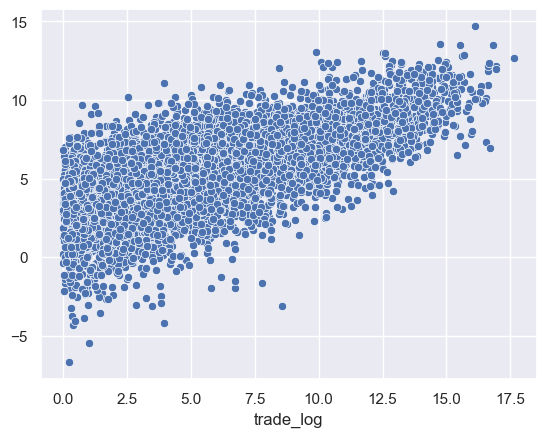

In [82]:
s = sns.scatterplot(x=train['trade_log'], y=y_train_pred)

In [83]:
r2_score(train['trade_log'], y_train_pred)

0.44680860895210683

In [84]:
r2_score(np.exp(train['trade_log']), np.exp(y_train_pred))

0.008071240911052047

In [85]:
r2_score(test['trade_log'], y_test_pred)

0.43365038578857407

In [86]:
r2_score(np.exp(test['trade_log']), np.exp(y_test_pred))

0.008584146702565243

In [87]:
# r2_score(np.exp(train['trade']), np.exp(y_train_pred))

In [88]:
# s = sns.scatterplot(x=np.exp(train['trade']), y=np.exp(y_train_pred))

In [89]:
#####
# the next few cells were used for hyperparameter tuning using grid search (but the y variable here was trade, not log trade), so we are not using this

In [90]:
# reg = HistGradientBoostingRegressor(loss='gamma')

# sel = SelectKBest(mutual_info_regression, k=20)

# pipe = Pipeline([('selector', sel), ('regressor', reg)])

# gridparam = dict(
#                 selector__k=['all'],
#                 regressor__l2_regularization=[3e2, 1e3, 3e3],
#                 regressor__learning_rate=[0.1, 0.3, 1],
#                 regressor__min_samples_leaf=[20, 50, 100],
#                 regressor__max_leaf_nodes=[None, 20, 30],
#                 regressor__max_depth=[None, 20, 50],
#                 regressor__max_iter=[5000])

# cv = GridSearchCV(pipe, gridparam, verbose=2, scoring='r2')

In [91]:
# cv.fit(X_train, y_train)

In [92]:
# cv.best_estimator_

In [93]:
# cv.best_score_

In [94]:
# predicting log trade with normal loss (not gamma loss) some times led to negative r2 for trade on test set. so seems to be unstable

# this seems to be the best, doesnt contain the network parameters either (except for node degrees), at least its relatively stable
# use this and write the balancing code now
# check once with cv that its not random (cv looks okay too, performance between 52 and 75 per cent)
# is grid search needed?

In [187]:
y_col = 'trade'

In [112]:
X_cols = [
          # 'freight_USD_t', 
          'transport_USD_t', 
          'time_h',
          'distance_km', 
          'border_USD_t', 
          # 'customs_cost', 
          # 'mode',
          # 'Pref_Applied_AVE', 
          'from_barley_area', 
          'from_maize_area', 
          'from_millet_area', 
          'from_rice_area',
          'from_sorghum_area', 
          'from_wheat_area', 
          'from_other_cereals_area',
          'from_barley_production', 
          'from_maize_production',
          'from_millet_production', 
          'from_rice_production',
          'from_sorghum_production', 
          'from_wheat_production',
          'from_other_cereals_production', 
          'from_buffaloes', 
          'from_cattle', 
          'from_chickens', 
          'from_ducks', 
          'from_goats', 
          'from_horses', 
          'from_pigs', 
          'from_sheep', 
          'from_pop', 
          'from_area', 
          # 'from_built_surface', 
          'from_built_volume_total', 
          # 'from_built_volume_nres_log', 
          'to_barley_area', 
          'to_maize_area', 
          'to_millet_area', 
          'to_rice_area', 
          'to_sorghum_area', 
          'to_wheat_area', 
          'to_other_cereals_area', 
          'to_barley_production', 
          'to_maize_production',
          'to_millet_production', 
          'to_rice_production', 
          'to_sorghum_production', 
          'to_wheat_production', 
          'to_other_cereals_production', 
          'to_buffaloes',   
          'to_cattle', 
          'to_chickens', 
          'to_ducks', 
          'to_goats', 
          'to_horses', 
          'to_pigs', 
          'to_sheep', 
          'to_pop', 
          'to_area', 
          # 'to_built_surface', 
          'to_built_volume_total', 
          # 'to_built_volume_nres_log',
          # 'from_dim_0', 
          # 'from_dim_1', 
          # 'from_dim_2', 
          # 'from_dim_3', 
          # 'from_dim_4', 
          # 'from_dim_5', 
          # 'from_dim_6', 
          # 'from_dim_7',
          # 'from_dim_8', 
          # 'from_dim_9', 
          # 'from_dim_10', 
          # 'from_dim_11', 
          # 'from_dim_12', 
          # 'from_dim_13', 
          # 'from_dim_14',
          # 'from_dim_15',
          # 'from_degree',
          'from_in_degree',
          'from_out_degree',
          # 'to_dim_0', 
          # 'to_dim_1', 
          # 'to_dim_2', 
          # 'to_dim_3', 
          # 'to_dim_4', 
          # 'to_dim_5', 
          # 'to_dim_6', 
          # 'to_dim_7',
          # 'to_dim_8', 
          # 'to_dim_9', 
          # 'to_dim_10', 
          # 'to_dim_11', 
          # 'to_dim_12', 
          # 'to_dim_13', 
          # 'to_dim_14',
          # 'to_dim_15',
          # 'to_degree',
          'to_in_degree',
          'to_out_degree'
         ]

In [113]:
def custom_r2(y, y_pred):
    # return r2_score(np.exp(y), np.exp(y_pred))
    return r2_score(np.log(y), np.log(y_pred))

In [114]:
# train, test= train_test_split(df_country, test_size=0.2)
# train =  train[train['trade_exists']==1].reset_index(drop=True)
# test = test[test['trade_exists']==1].reset_index(drop=True)

In [115]:
# train = train[
#     (train['trade']<df["trade"].quantile(0.999)) 
#     ]

# test = test[
#     (test['trade']<df["trade"].quantile(0.999)) 
#     ]

In [116]:
# train = train.merge(emb_df, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
#     'dim_0': 'from_dim_0', 
#     'dim_1': 'from_dim_1', 
#     'dim_2': 'from_dim_2', 
#     'dim_3': 'from_dim_3', 
#     'dim_4': 'from_dim_4', 
#     'dim_5': 'from_dim_5', 
#     'dim_6': 'from_dim_6', 
#     'dim_7': 'from_dim_7',
#     'dim_8': 'from_dim_8', 
#     'dim_9': 'from_dim_9', 
#     'dim_10': 'from_dim_10', 
#     'dim_11': 'from_dim_11', 
#     'dim_12': 'from_dim_12', 
#     'dim_13': 'from_dim_13', 
#     'dim_14': 'from_dim_14',
#     'dim_15': 'from_dim_15',
#     'degree': 'from_degree',
#     'in_degree': 'from_in_degree',
#     'out_degree': 'from_out_degree'
# })

# train = train.merge(emb_df, left_on='to_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
#     'dim_0': 'to_dim_0', 
#     'dim_1': 'to_dim_1', 
#     'dim_2': 'to_dim_2', 
#     'dim_3': 'to_dim_3', 
#     'dim_4': 'to_dim_4', 
#     'dim_5': 'to_dim_5', 
#     'dim_6': 'to_dim_6', 
#     'dim_7': 'to_dim_7',
#     'dim_8': 'to_dim_8', 
#     'dim_9': 'to_dim_9', 
#     'dim_10': 'to_dim_10', 
#     'dim_11': 'to_dim_11', 
#     'dim_12': 'to_dim_12', 
#     'dim_13': 'to_dim_13', 
#     'dim_14': 'to_dim_14',
#     'dim_15': 'to_dim_15',
#     'degree': 'to_degree',
#     'in_degree': 'to_in_degree',
#     'out_degree': 'to_out_degree'
# })

# test = test.merge(emb_df, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
#     'dim_0': 'from_dim_0', 
#     'dim_1': 'from_dim_1', 
#     'dim_2': 'from_dim_2', 
#     'dim_3': 'from_dim_3', 
#     'dim_4': 'from_dim_4', 
#     'dim_5': 'from_dim_5', 
#     'dim_6': 'from_dim_6', 
#     'dim_7': 'from_dim_7',
#     'dim_8': 'from_dim_8', 
#     'dim_9': 'from_dim_9', 
#     'dim_10': 'from_dim_10', 
#     'dim_11': 'from_dim_11', 
#     'dim_12': 'from_dim_12', 
#     'dim_13': 'from_dim_13', 
#     'dim_14': 'from_dim_14',
#     'dim_15': 'from_dim_15',
#     'degree': 'from_degree',
#     'in_degree': 'from_in_degree',
#     'out_degree': 'from_out_degree'
# })

# test = test.merge(emb_df, left_on='to_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
#     'dim_0': 'to_dim_0', 
#     'dim_1': 'to_dim_1', 
#     'dim_2': 'to_dim_2', 
#     'dim_3': 'to_dim_3', 
#     'dim_4': 'to_dim_4', 
#     'dim_5': 'to_dim_5', 
#     'dim_6': 'to_dim_6', 
#     'dim_7': 'to_dim_7',
#     'dim_8': 'to_dim_8', 
#     'dim_9': 'to_dim_9', 
#     'dim_10': 'to_dim_10', 
#     'dim_11': 'to_dim_11', 
#     'dim_12': 'to_dim_12', 
#     'dim_13': 'to_dim_13', 
#     'dim_14': 'to_dim_14',
#     'dim_15': 'to_dim_15',
#     'degree': 'to_degree',
#     'in_degree': 'to_in_degree',
#     'out_degree': 'to_out_degree'
# })

In [117]:
X_train = train[X_cols]
y_train = train[y_col]

X_test = test[X_cols]
y_test = test[y_col]

In [118]:
y_train.describe()

count    6.827000e+03
mean     1.416353e+05
std      1.116152e+06
min      1.003355e+00
25%      9.090895e+00
50%      1.051200e+02
75%      2.591868e+03
max      4.609050e+07
Name: trade, dtype: float64

In [119]:
y_test.describe()

count    1.736000e+03
mean     1.416067e+05
std      1.538631e+06
min      1.001808e+00
25%      7.752195e+00
50%      8.763311e+01
75%      2.537400e+03
max      5.724664e+07
Name: trade, dtype: float64

In [120]:
pipe_reg = Pipeline([                                                                                        
        # ('scale', preprocessing.StandardScaler()),
        ('reg', HistGradientBoostingRegressor(
            l2_regularization=200, 
            loss='gamma',
            max_iter= 1000,
            max_depth=5
           ))])

kfold = KFold(n_splits=4)
results = cross_validate(pipe_reg, X_train, y_train, cv=kfold, scoring={'r2 - trade': 'r2', 'r2 - log trade': make_scorer(custom_r2)})

In [121]:
results

{'fit_time': array([3.05774593, 3.10184717, 2.961272  , 2.99094296]),
 'score_time': array([0.03581738, 0.03150201, 0.03167319, 0.03113174]),
 'test_r2 - trade': array([0.22118471, 0.25162383, 0.37973286, 0.1847205 ]),
 'test_r2 - log trade': array([0.63925666, 0.62629661, 0.64763743, 0.54683917])}

In [122]:
df = df_country[df_country['trade_exists']==1].reset_index()

df = df.merge(emb_df, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
    'dim_0': 'from_dim_0', 
    'dim_1': 'from_dim_1', 
    'dim_2': 'from_dim_2', 
    'dim_3': 'from_dim_3', 
    'dim_4': 'from_dim_4', 
    'dim_5': 'from_dim_5', 
    'dim_6': 'from_dim_6', 
    'dim_7': 'from_dim_7',
    'dim_8': 'from_dim_8', 
    'dim_9': 'from_dim_9', 
    'dim_10': 'from_dim_10', 
    'dim_11': 'from_dim_11', 
    'dim_12': 'from_dim_12', 
    'dim_13': 'from_dim_13', 
    'dim_14': 'from_dim_14',
    'dim_15': 'from_dim_15',
    'degree': 'from_degree',
    'in_degree': 'from_in_degree',
    'out_degree': 'from_out_degree'
})

df = df.merge(emb_df, left_on='to_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
    'dim_0': 'to_dim_0', 
    'dim_1': 'to_dim_1', 
    'dim_2': 'to_dim_2', 
    'dim_3': 'to_dim_3', 
    'dim_4': 'to_dim_4', 
    'dim_5': 'to_dim_5', 
    'dim_6': 'to_dim_6', 
    'dim_7': 'to_dim_7',
    'dim_8': 'to_dim_8', 
    'dim_9': 'to_dim_9', 
    'dim_10': 'to_dim_10', 
    'dim_11': 'to_dim_11', 
    'dim_12': 'to_dim_12', 
    'dim_13': 'to_dim_13', 
    'dim_14': 'to_dim_14',
    'dim_15': 'to_dim_15',
    'degree': 'to_degree',
    'in_degree': 'to_in_degree',
    'out_degree': 'to_out_degree'
})

df = df[
    (df['trade']<df["trade"].quantile(0.999)) 
    # & (df['trade']>df["trade"].quantile(0.01))
    ]

pipe_reg = Pipeline([                                                                                        
        # ('scale', preprocessing.StandardScaler()),
        ('reg', HistGradientBoostingRegressor(
            l2_regularization=200, 
            loss='gamma',
            max_iter= 1000,
            max_depth=5,
           ))])

kfold = KFold(n_splits=5)
results = cross_validate(pipe_reg, df[X_cols], df[y_col], return_train_score=True,
                         cv=kfold, scoring={'r2 - trade': 'r2', 'r2 - log trade': make_scorer(custom_r2)})

In [123]:
results

{'fit_time': array([3.3829298 , 2.9368391 , 3.18128514, 3.4760592 , 3.35170507]),
 'score_time': array([0.03163624, 0.03799295, 0.03362393, 0.03369308, 0.040694  ]),
 'test_r2 - trade': array([0.25297231, 0.25983018, 0.43659032, 0.50057895, 0.38676416]),
 'train_r2 - trade': array([0.77823803, 0.75830736, 0.77891686, 0.75217328, 0.80318487]),
 'test_r2 - log trade': array([0.56274346, 0.63560706, 0.66142985, 0.60063146, 0.53330352]),
 'train_r2 - log trade': array([0.82266687, 0.81183232, 0.80834522, 0.81616877, 0.83035362])}

In [124]:
results['train_r2 - trade'].mean()

0.7741640777079197

In [125]:
results['test_r2 - trade'].mean()

0.3673471820237143

In [126]:
results['train_r2 - log trade'].mean()

0.8178733608063087

In [127]:
results['test_r2 - log trade'].mean()

0.5987430686126619

In [128]:
df['trade'].describe()

count    8.554000e+03
mean     1.139506e+05
std      7.361365e+05
min      1.001808e+00
25%      8.764736e+00
50%      1.020648e+02
75%      2.537039e+03
max      1.660901e+07
Name: trade, dtype: float64

In [129]:
df_country[df_country['trade_exists']==1]['trade'].describe()

count    8.563000e+03
mean     1.416295e+05
std      1.213643e+06
min      1.001808e+00
25%      8.809833e+00
50%      1.025027e+02
75%      2.567611e+03
max      5.724664e+07
Name: trade, dtype: float64

In [130]:
pipe_reg = Pipeline([                                                                                        
        # ('scale', preprocessing.StandardScaler()),
        ('reg', HistGradientBoostingRegressor(
            l2_regularization=200, 
            loss='gamma',
            max_iter= 1000,
            max_depth=5,
           ))])

pipe_reg.fit(X_train, y_train)

Pipeline(steps=[('reg',
                 HistGradientBoostingRegressor(l2_regularization=200,
                                               loss='gamma', max_depth=5,
                                               max_iter=1000))])

In [131]:
y_train_pred = pipe_reg.predict(X_train)

In [132]:
y_test_pred = pipe_reg.predict(X_test)

In [133]:
mean_squared_error(y_train, y_train_pred, squared=False)

574587.6588078241

In [134]:
r2_score(y_train, y_train_pred)

0.7349489671613052

In [135]:
r2_score(np.log(y_train), np.log(y_train_pred))
# r2_score(np.exp(y_train), np.exp(y_train_pred))

0.8166962663630952

In [136]:
mean_squared_error(y_test, y_test_pred, squared=False)

1200218.9963369954

In [137]:
r2_score(y_test, y_test_pred)

0.3911612136732162

In [138]:
r2_score(np.log(y_test), np.log(y_test_pred))
# r2_score(np.exp(y_test), np.exp(y_test_pred))

0.647525942224677

In [139]:
y_test.mean()

141606.65943159504

In [140]:
y_train.mean()

141635.26168107026

<Axes: xlabel='trade', ylabel='Density'>

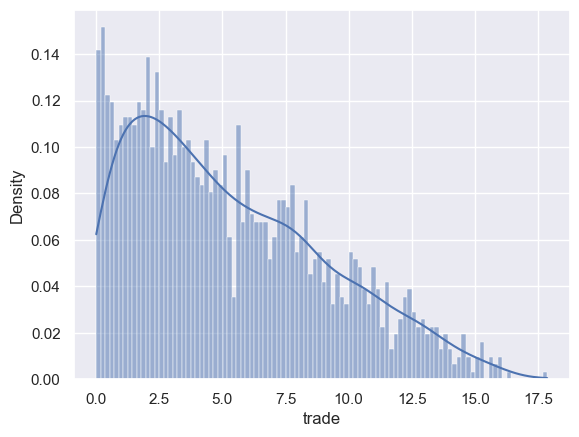

In [141]:
sns.histplot(x=np.log(y_test), kde=True, bins=100, stat='density')

<Axes: xlabel='trade', ylabel='Density'>

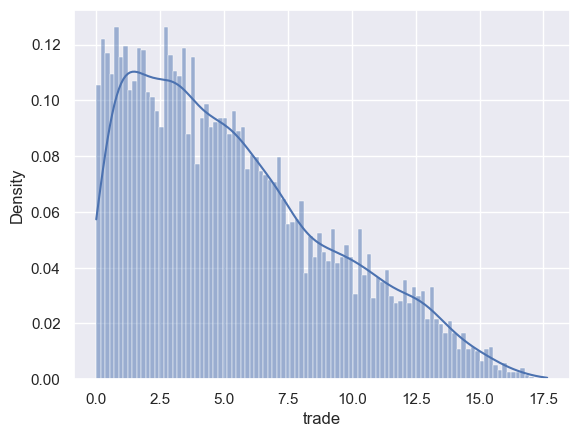

In [142]:
sns.histplot(x=np.log(y_train), kde=True, bins=100, stat='density')

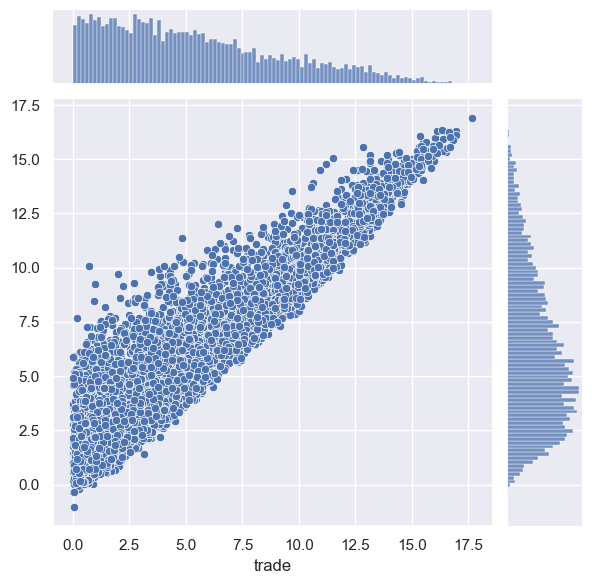

In [143]:
sns.jointplot(x=np.log(y_train), y=np.log(y_train_pred), marginal_kws=dict(stat='density', bins=100))
# plt.xlim(0,18)
# plt.ylim(0,18)

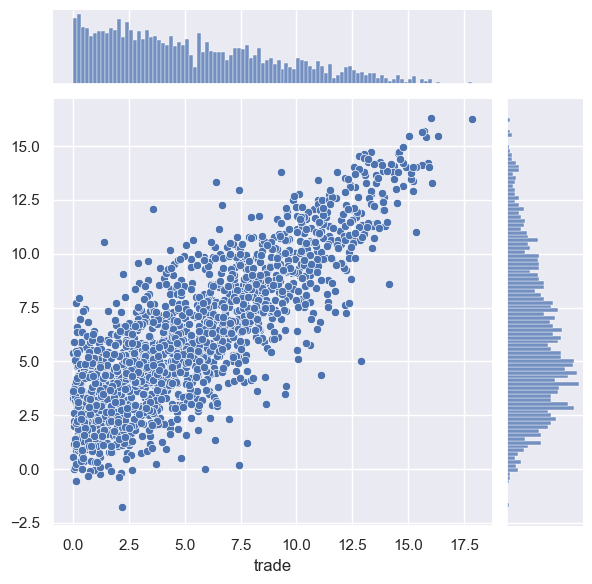

In [144]:
sns.jointplot(x=np.log(y_test), y=np.log(y_test_pred), marginal_kws=dict(stat='density', bins=100))
# plt.xlim(0,18)
# plt.ylim(0,18)

<Axes: xlabel='trade'>

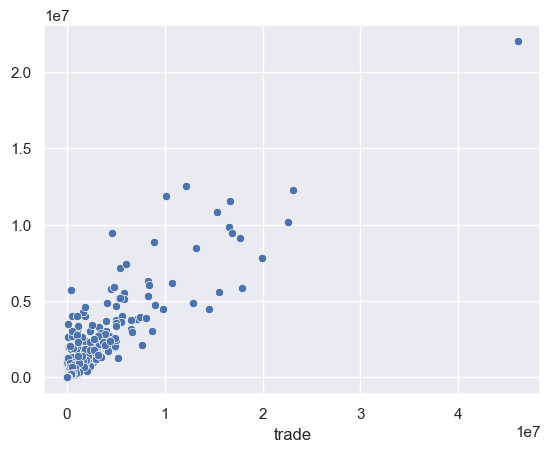

In [145]:
sns.scatterplot(x=y_train, y=y_train_pred)
# plt.xlim(0,6e7)
# plt.ylim(0,6e7)

<Axes: xlabel='trade'>

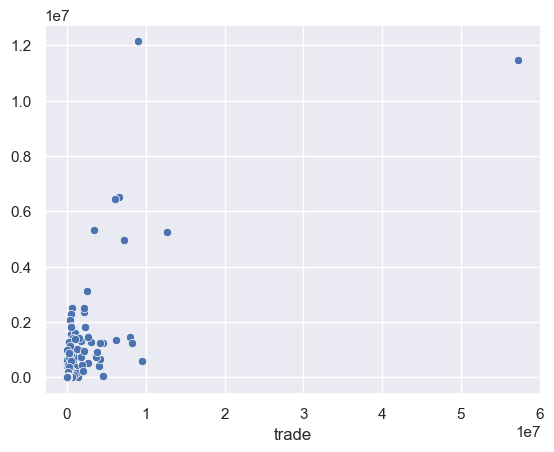

In [146]:
sns.scatterplot(x=y_test, y=y_test_pred)
# plt.xlim(0,2.5e7)
# plt.ylim(0,2.5e7)

In [147]:
# tried a deep learning approach here
# didn't work any better (both with log and non-log)

In [148]:
X_cols = ['freight_USD_t', 
          'transport_USD_t', 
          'time_h',
          'distance_km', 
          'border_USD_t', 
          'customs_cost', 
          'mode',
          'Pref_Applied_AVE', 
          'from_barley_area_log', 
          'from_maize_area_log', 
          'from_millet_area_log', 
          'from_rice_area_log',
          'from_sorghum_area_log', 
          'from_wheat_area_log', 
          'from_other_cereals_area_log',
          'from_barley_production_log', 
          'from_maize_production_log',
          'from_millet_production_log', 
          'from_rice_production_log',
          'from_sorghum_production_log', 
          'from_wheat_production_log',
          'from_other_cereals_production_log', 
          'from_buffaloes_log', 
          'from_cattle_log', 
          'from_chickens_log', 
          'from_ducks_log', 
          'from_goats_log', 
          'from_horses_log', 
          'from_pigs_log', 
          'from_sheep_log', 
          'from_pop_log', 
          'from_area_log', 
          'from_built_surface_log', 
          'from_built_volume_total_log', 
          'from_built_volume_nres_log', 
          'to_barley_area_log', 
          'to_maize_area_log', 
          'to_millet_area_log', 
          'to_rice_area_log', 
          'to_sorghum_area_log', 
          'to_wheat_area_log', 
          'to_other_cereals_area_log', 
          'to_barley_production_log', 
          'to_maize_production_log',
          'to_millet_production_log', 
          'to_rice_production_log', 
          'to_sorghum_production_log', 
          'to_wheat_production_log', 
          'to_other_cereals_production_log', 
          'to_buffaloes_log',   
          'to_cattle_log', 
          'to_chickens_log', 
          'to_ducks_log', 
          'to_goats_log', 
          'to_horses_log', 
          'to_pigs_log', 
          'to_sheep_log', 
          'to_pop_log', 
          'to_area_log', 
          'to_built_surface_log', 
          'to_built_volume_total_log', 
          'to_built_volume_nres_log',
          # 'from_dim_0', 
          # 'from_dim_1', 
          # 'from_dim_2', 
          # 'from_dim_3', 
          # 'from_dim_4', 
          # 'from_dim_5', 
          # 'from_dim_6', 
          # 'from_dim_7',
          # 'from_dim_8', 
          # 'from_dim_9', 
          # 'from_dim_10', 
          # 'from_dim_11', 
          # 'from_dim_12', 
          # 'from_dim_13', 
          # 'from_dim_14',
          # 'from_dim_15',
          'from_in_degree',
          'from_out_degree',
          # 'to_dim_0', 
          # 'to_dim_1', 
          # 'to_dim_2', 
          # 'to_dim_3', 
          # 'to_dim_4', 
          # 'to_dim_5', 
          # 'to_dim_6', 
          # 'to_dim_7',
          # 'to_dim_8', 
          # 'to_dim_9', 
          # 'to_dim_10', 
          # 'to_dim_11', 
          # 'to_dim_12', 
          # 'to_dim_13', 
          # 'to_dim_14',
          # 'to_dim_15',
          'to_in_degree',
          'to_out_degree'
         ]

y_col = 'trade'

X_train = train[X_cols]
y_train = train[y_col] 

X_test = test[X_cols]
y_test = test[y_col] 

In [149]:
params = {'lr': 0.03,
     'batch_size': 128,
     'epochs': 500,
     'optimizer': tf.keras.optimizers.Adam,
     'dropout': 0.3,
     'dense_neurons': 32
    }

In [150]:
lr = params['lr']
# decay = params['decay']
batch_size = params['batch_size']
epochs = params['epochs']
optimizer = params['optimizer']
dropout = params['dropout']
dense_neurons = params['dense_neurons']

metrics = [tfa.metrics.RSquare()]
activation='relu'

model = keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1])))
model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 1
model.add(layers.Dropout(dropout))
model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 2
model.add(layers.Dropout(dropout))
model.add(layers.Dense(1, activation='softplus')) 

model.compile(loss='mean_squared_error', optimizer=optimizer(learning_rate=lr), metrics=metrics)

In [151]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                2144      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3233 (12.63 KB)
Trainable params: 3233 (12.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [152]:
model.fit(X_train, y_train, 
          # validation_split=0.1,
          validation_data=(X_test, y_test), 
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=1)

Epoch 1/500
54/54 [==============================] - 3s 27ms/step - loss: 1255569096704.0000 - r_square: -0.0080 - val_loss: 2378957586432.0000 - val_r_square: -0.0055
Epoch 2/500
54/54 [==============================] - 0s 3ms/step - loss: 1253038358528.0000 - r_square: -0.0060 - val_loss: 2372266622976.0000 - val_r_square: -0.0026
Epoch 3/500
54/54 [==============================] - 0s 2ms/step - loss: 1250821013504.0000 - r_square: -0.0042 - val_loss: 2365796909056.0000 - val_r_square: 9.5248e-05
Epoch 4/500
54/54 [==============================] - 0s 3ms/step - loss: 1245900439552.0000 - r_square: -2.3067e-04 - val_loss: 2359468490752.0000 - val_r_square: 0.0028
Epoch 5/500
54/54 [==============================] - 0s 2ms/step - loss: 1237988540416.0000 - r_square: 0.0061 - val_loss: 2349681344512.0000 - val_r_square: 0.0069
Epoch 6/500
54/54 [==============================] - 0s 2ms/step - loss: 1237152432128.0000 - r_square: 0.0068 - val_loss: 2345830973440.0000 - val_r_square: 0.

In [153]:
model = keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1])))
model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 1
model.add(layers.Dropout(dropout))
model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 2
model.add(layers.Dropout(dropout))
model.add(layers.Dense(1, activation='softplus')) 

model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer(learning_rate=lr), metrics=metrics)

model.fit(X_train, y_train, 
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=0)

In [154]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

55/55 [==============================] - 0s 1ms/step


In [155]:
r2_score(y_train, y_train_pred)

-0.010908622299858672

In [156]:
r2_score(np.log(y_train), np.log(y_train_pred))

0.4100307092871055

In [157]:
r2_score(y_test, y_test_pred)

-0.0051926223892915235

In [158]:
r2_score(np.log(y_test), np.log(y_test_pred))

0.41788354785758386

In [159]:
# maybe removing outliers will help with performance

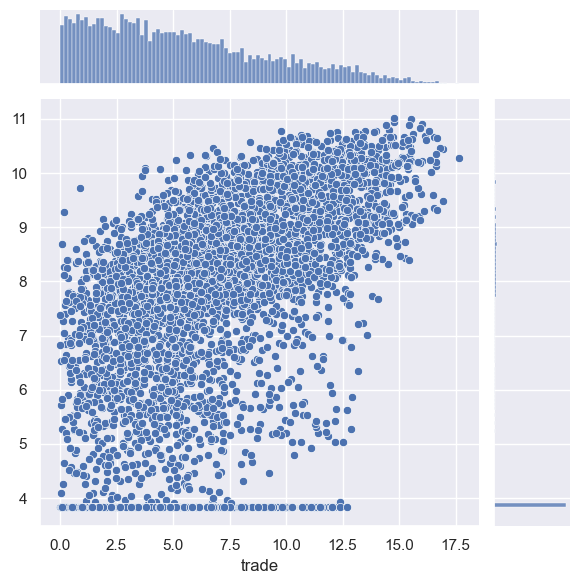

In [160]:
sns.jointplot(x=np.log(y_train), y=np.log(y_train_pred[:,0]), marginal_kws=dict(stat='density', bins=100))
# plt.xlim(0,18)
# plt.ylim(0,18)

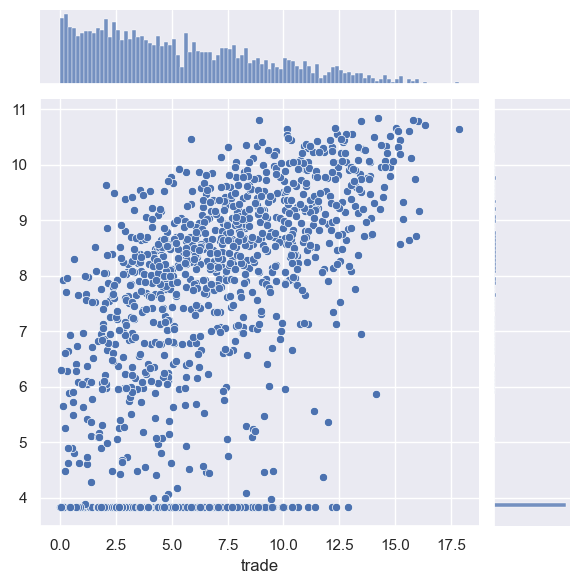

In [161]:
sns.jointplot(x=np.log(y_test), y=np.log(y_test_pred[:,0]), marginal_kws=dict(stat='density', bins=100))
# plt.xlim(0,18)
# plt.ylim(0,18)

<Axes: xlabel='trade'>

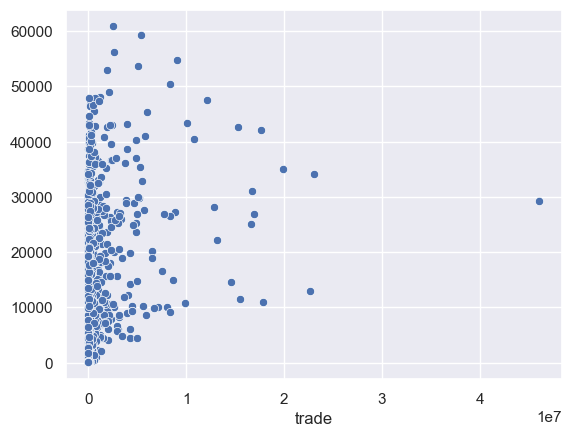

In [162]:
sns.scatterplot(x=y_train, y=y_train_pred[:,0])
# plt.xlim(0,2.5e7)
# plt.ylim(0,2.5e7)

<Axes: xlabel='trade'>

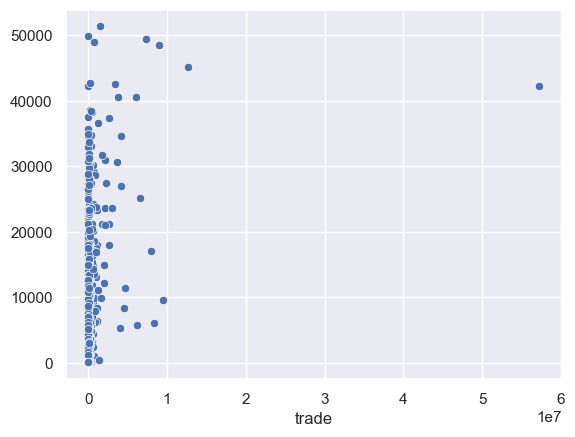

In [163]:
sns.scatterplot(x=y_test, y=y_test_pred[:,0])
# plt.xlim(0,2.5e7)
# plt.ylim(0,2.5e7)

In [251]:
X_cols = [
          # 'freight_USD_t', 
          'transport_USD_t', 
          'time_h',
          'distance_km', 
          'border_USD_t', 
          # 'customs_cost', 
          # 'mode',
          # 'Pref_Applied_AVE', 
          'from_barley_area', 
          'from_maize_area', 
          'from_millet_area', 
          'from_rice_area',
          'from_sorghum_area', 
          'from_wheat_area', 
          'from_other_cereals_area',
          'from_barley_production', 
          'from_maize_production',
          'from_millet_production', 
          'from_rice_production',
          'from_sorghum_production', 
          'from_wheat_production',
          'from_other_cereals_production', 
          'from_buffaloes', 
          'from_cattle', 
          'from_chickens', 
          'from_ducks', 
          'from_goats', 
          'from_horses', 
          'from_pigs', 
          'from_sheep', 
          'from_pop', 
          'from_area', 
          # 'from_built_surface', 
          'from_built_volume_total', 
          # 'from_built_volume_nres_log', 
          'to_barley_area', 
          'to_maize_area', 
          'to_millet_area', 
          'to_rice_area', 
          'to_sorghum_area', 
          'to_wheat_area', 
          'to_other_cereals_area', 
          'to_barley_production', 
          'to_maize_production',
          'to_millet_production', 
          'to_rice_production', 
          'to_sorghum_production', 
          'to_wheat_production', 
          'to_other_cereals_production', 
          'to_buffaloes',   
          'to_cattle', 
          'to_chickens', 
          'to_ducks', 
          'to_goats', 
          'to_horses', 
          'to_pigs', 
          'to_sheep', 
          'to_pop', 
          'to_area', 
          # 'to_built_surface', 
          'to_built_volume_total', 
          # 'to_built_volume_nres_log',
          # 'from_dim_0', 
          # 'from_dim_1', 
          # 'from_dim_2', 
          # 'from_dim_3', 
          # 'from_dim_4', 
          # 'from_dim_5', 
          # 'from_dim_6', 
          # 'from_dim_7',
          # 'from_dim_8', 
          # 'from_dim_9', 
          # 'from_dim_10', 
          # 'from_dim_11', 
          # 'from_dim_12', 
          # 'from_dim_13', 
          # 'from_dim_14',
          # 'from_dim_15',
          # 'from_degree',
          'from_in_degree',
          'from_out_degree',
          # 'to_dim_0', 
          # 'to_dim_1', 
          # 'to_dim_2', 
          # 'to_dim_3', 
          # 'to_dim_4', 
          # 'to_dim_5', 
          # 'to_dim_6', 
          # 'to_dim_7',
          # 'to_dim_8', 
          # 'to_dim_9', 
          # 'to_dim_10', 
          # 'to_dim_11', 
          # 'to_dim_12', 
          # 'to_dim_13', 
          # 'to_dim_14',
          # 'to_dim_15',
          # 'to_degree',
          'to_in_degree',
          'to_out_degree'
         ]

r2_train = []
r2_log_train = []

r2_test = []
r2_log_test = []

for i in range(5):
    print(i)

    train = train_dfs[i]
    test = test_dfs[i]
    
    train =  train[train['trade_exists']==1].reset_index(drop=True)
    test = test[test['trade_exists']==1].reset_index(drop=True)
    
    train = train.merge(emb_df, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
        'dim_0': 'from_dim_0', 
        'dim_1': 'from_dim_1', 
        'dim_2': 'from_dim_2', 
        'dim_3': 'from_dim_3', 
        'dim_4': 'from_dim_4', 
        'dim_5': 'from_dim_5', 
        'dim_6': 'from_dim_6', 
        'dim_7': 'from_dim_7',
        'dim_8': 'from_dim_8', 
        'dim_9': 'from_dim_9', 
        'dim_10': 'from_dim_10', 
        'dim_11': 'from_dim_11', 
        'dim_12': 'from_dim_12', 
        'dim_13': 'from_dim_13', 
        'dim_14': 'from_dim_14',
        'dim_15': 'from_dim_15',
        'degree': 'from_degree',
        'in_degree': 'from_in_degree',
        'out_degree': 'from_out_degree'
    })
    
    train = train.merge(emb_df, left_on='to_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
        'dim_0': 'to_dim_0', 
        'dim_1': 'to_dim_1', 
        'dim_2': 'to_dim_2', 
        'dim_3': 'to_dim_3', 
        'dim_4': 'to_dim_4', 
        'dim_5': 'to_dim_5', 
        'dim_6': 'to_dim_6', 
        'dim_7': 'to_dim_7',
        'dim_8': 'to_dim_8', 
        'dim_9': 'to_dim_9', 
        'dim_10': 'to_dim_10', 
        'dim_11': 'to_dim_11', 
        'dim_12': 'to_dim_12', 
        'dim_13': 'to_dim_13', 
        'dim_14': 'to_dim_14',
        'dim_15': 'to_dim_15',
        'degree': 'to_degree',
        'in_degree': 'to_in_degree',
        'out_degree': 'to_out_degree'
    })
    
    test = test.merge(emb_df, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
        'dim_0': 'from_dim_0', 
        'dim_1': 'from_dim_1', 
        'dim_2': 'from_dim_2', 
        'dim_3': 'from_dim_3', 
        'dim_4': 'from_dim_4', 
        'dim_5': 'from_dim_5', 
        'dim_6': 'from_dim_6', 
        'dim_7': 'from_dim_7',
        'dim_8': 'from_dim_8', 
        'dim_9': 'from_dim_9', 
        'dim_10': 'from_dim_10', 
        'dim_11': 'from_dim_11', 
        'dim_12': 'from_dim_12', 
        'dim_13': 'from_dim_13', 
        'dim_14': 'from_dim_14',
        'dim_15': 'from_dim_15',
        'degree': 'from_degree',
        'in_degree': 'from_in_degree',
        'out_degree': 'from_out_degree'
    })
    
    test = test.merge(emb_df, left_on='to_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
        'dim_0': 'to_dim_0', 
        'dim_1': 'to_dim_1', 
        'dim_2': 'to_dim_2', 
        'dim_3': 'to_dim_3', 
        'dim_4': 'to_dim_4', 
        'dim_5': 'to_dim_5', 
        'dim_6': 'to_dim_6', 
        'dim_7': 'to_dim_7',
        'dim_8': 'to_dim_8', 
        'dim_9': 'to_dim_9', 
        'dim_10': 'to_dim_10', 
        'dim_11': 'to_dim_11', 
        'dim_12': 'to_dim_12', 
        'dim_13': 'to_dim_13', 
        'dim_14': 'to_dim_14',
        'dim_15': 'to_dim_15',
        'degree': 'to_degree',
        'in_degree': 'to_in_degree',
        'out_degree': 'to_out_degree'
    })

    train = train[train['trade']<df_country[df_country['trade_exists']==1]["trade"].quantile(0.999)]
    test = test[test['trade']<df_country[df_country['trade_exists']==1]["trade"].quantile(0.999)]

    X_train = train[X_cols]
    y_train = train[y_col]
    
    X_test = test[X_cols]
    y_test = test[y_col]

    reg = HistGradientBoostingRegressor(
        l2_regularization=200, 
        loss='gamma',
        max_iter= 1000,
        max_depth=5
       )

    # reg = RandomForestRegressor(
    #     n_estimators= 200,
    #     max_depth=5
    #    )

    reg.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    
    r2_train.append(r2_score(y_train, y_train_pred))
    r2_log_train.append(r2_score(np.log(y_train+1), np.log(y_train_pred+1)))

    r2_test.append(r2_score(y_test, y_test_pred))
    r2_log_test.append(r2_score(np.log(y_test+1), np.log(y_test_pred+1)))

0
1
2
3
4


In [252]:
print('grad')

print('train')
print(f'r2 train: {np.mean(r2_train)}')
print(f'r2 train log: {np.mean(r2_log_train)}')

print('test')
print(f'r2 test: {np.mean(r2_test)}')
print(f'r2 test log: {np.mean(r2_log_test)}')

grad
train
r2 train: 0.7696828131573186
r2 train log: 0.8290715372628025
test
r2 test: 0.43541907308472066
r2 test log: 0.6657580157501067


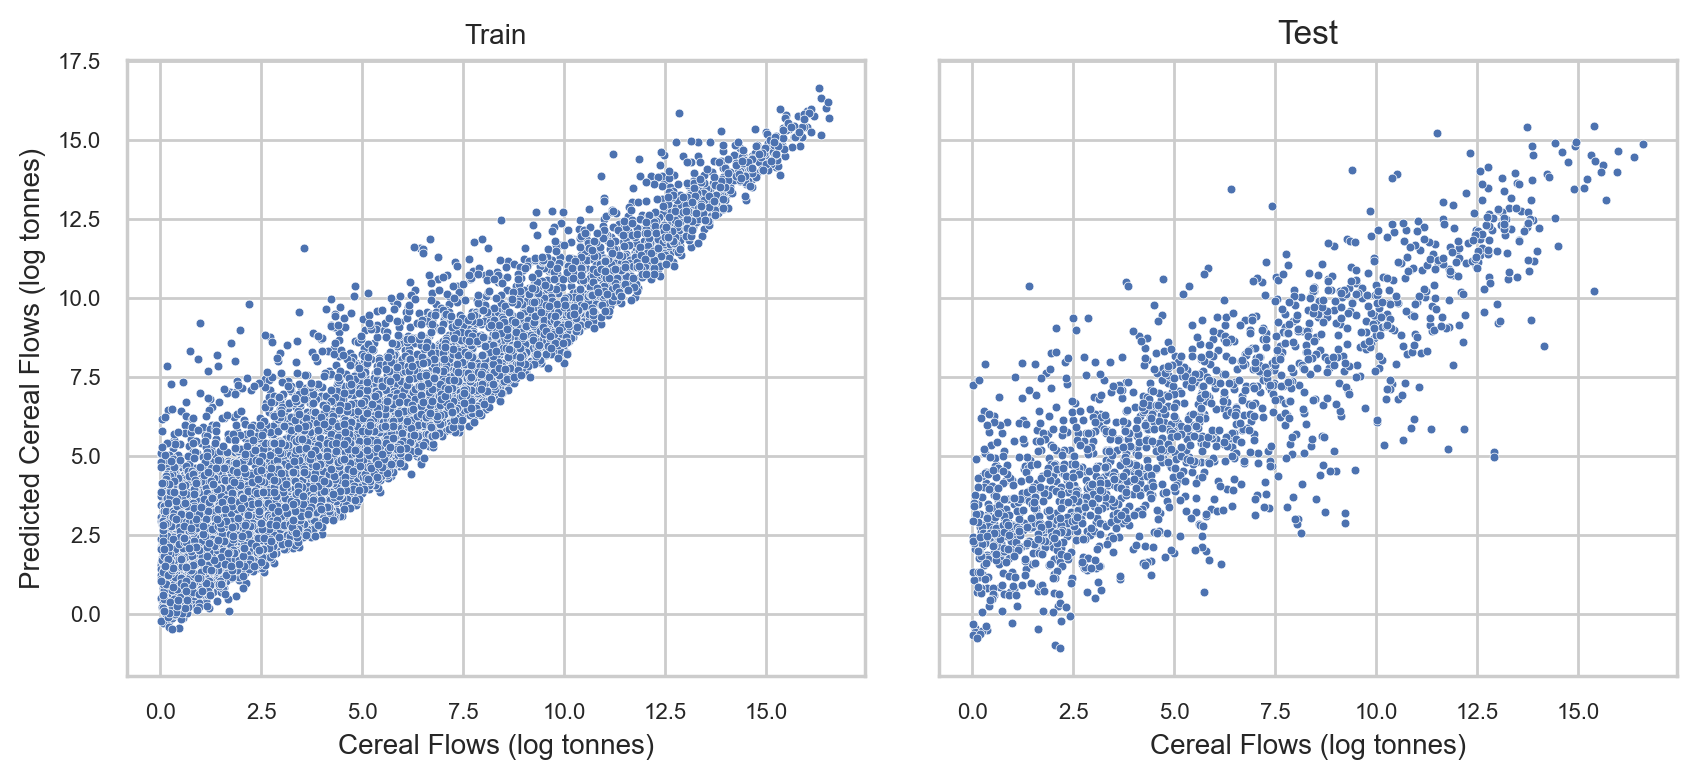

In [309]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=200, sharex=True, sharey=True)

ax = axs[0]
g = sns.scatterplot(ax=ax, x=np.log(y_train), y=np.log(y_train_pred), s=10)
ax.set_xlabel("Cereal Flows (log tonnes)", fontsize=10)
ax.set_ylabel("Predicted Cereal Flows (log tonnes)", fontsize=10)
ax.set_title("Train", fontsize=10) 
ax.tick_params(axis='both', which='major', labelsize=8)
# ax.set_xlim([0,16])
# ax.set_ylim([0,16])

ax = axs[1]
g = sns.scatterplot(ax=ax, x=np.log(y_test), y=np.log(y_test_pred), s=10)
ax.set_xlabel("Cereal Flows (log tonnes)", fontsize=10)
ax.set_ylabel("Predicted Cereal Flows (log tonnes)", fontsize=10)
ax.set_title("Test", fontsize=12) 
ax.tick_params(axis='both', which='major', labelsize=8)
# ax.set_xlim([0,16])
# ax.set_ylim([0,16])


g.figure.subplots_adjust(wspace=.1)

In [311]:
y_test.shape

(1717,)

In [223]:
print('rf')

print('train')
print(f'r2 train: {np.mean(r2_train)}')
print(f'r2 train log: {np.mean(r2_log_train)}')

print('test')
print(f'r2 test: {np.mean(r2_test)}')
print(f'r2 test log: {np.mean(r2_log_test)}')

rf
train
r2 train: 0.629123401319146
r2 train log: -1.3277540501559069
test
r2 test: 0.36506458189337454
r2 test log: -1.3387709571134938


In [244]:
X_cols = [
          # 'freight_USD_t', 
          'transport_USD_t', 
          'time_h',
          'distance_km', 
          'border_USD_t', 
          # 'customs_cost',
          # 'mode',
          # 'Pref_Applied_AVE', 
          'from_barley_area_log', 
          'from_maize_area_log', 
          'from_millet_area_log', 
          'from_rice_area_log',
          'from_sorghum_area_log', 
          'from_wheat_area_log', 
          'from_other_cereals_area_log',
          'from_barley_production_log', 
          'from_maize_production_log',
          'from_millet_production_log', 
          'from_rice_production_log',
          'from_sorghum_production_log', 
          'from_wheat_production_log',
          'from_other_cereals_production_log', 
          'from_buffaloes_log', 
          'from_cattle_log', 
          'from_chickens_log', 
          'from_ducks_log', 
          'from_goats_log', 
          'from_horses_log', 
          'from_pigs_log', 
          'from_sheep_log', 
          'from_pop_log', 
          'from_area_log', 
          # 'from_built_surface_log', 
          'from_built_volume_total_log', 
          # 'from_built_volume_nres_log', 
          'to_barley_area_log', 
          'to_maize_area_log', 
          'to_millet_area_log', 
          'to_rice_area_log', 
          'to_sorghum_area_log', 
          'to_wheat_area_log', 
          'to_other_cereals_area_log', 
          'to_barley_production_log', 
          'to_maize_production_log',
          'to_millet_production_log', 
          'to_rice_production_log', 
          'to_sorghum_production_log', 
          'to_wheat_production_log', 
          'to_other_cereals_production_log', 
          'to_buffaloes_log',   
          'to_cattle_log', 
          'to_chickens_log', 
          'to_ducks_log', 
          'to_goats_log', 
          'to_horses_log', 
          'to_pigs_log', 
          'to_sheep_log', 
          'to_pop_log', 
          'to_area_log', 
          # 'to_built_surface_log', 
          'to_built_volume_total_log', 
          # 'to_built_volume_nres_log'
]

r2_train = []
r2_log_train = []

r2_test = []
r2_log_test = []

for i in range(5):
    print(i)

    train = train_dfs[i]
    test = test_dfs[i]
    
    train =  train[train['trade_exists']==1].reset_index(drop=True)
    test = test[test['trade_exists']==1].reset_index(drop=True)

    train = train[train['trade']<df_country[df_country['trade_exists']==1]["trade"].quantile(0.999)]
    test = test[test['trade']<df_country[df_country['trade_exists']==1]["trade"].quantile(0.999)]

    fml = "trade_log ~ " + " + ".join(X_cols)
    mod = sm.OLS.from_formula(fml, data=train)
    res = mod.fit()
    y_train_pred = res.predict(train)
    y_test_pred = res.predict(test)

    r2_train.append(r2_score(np.exp(train['trade_log']), np.exp(y_train_pred)))
    r2_log_train.append(r2_score(train['trade_log'], y_train_pred))

    r2_test.append(r2_score(np.exp(test['trade_log']), np.exp(y_test_pred)))
    r2_log_test.append(r2_score(test['trade_log'], y_test_pred))

0
1
2
3
4


In [245]:
print('lin reg')

print('train')
print(f'r2 train: {np.mean(r2_train)}')
print(f'r2 train log: {np.mean(r2_log_train)}')

print('test')
print(f'r2 test: {np.mean(r2_test)}')
print(f'r2 test log: {np.mean(r2_log_test)}')

lin reg
train
r2 train: 0.008287337409243856
r2 train log: 0.4394800866284633
test
r2 test: -0.00736215266120146
r2 test log: 0.42871636449283335


In [238]:
X_cols = [
          # 'freight_USD_t', 
          'transport_USD_t', 
          'time_h',
          'distance_km', 
          'border_USD_t', 
          # 'customs_cost',
          # 'mode',
          # 'Pref_Applied_AVE', 
          'from_barley_area_log', 
          'from_maize_area_log', 
          'from_millet_area_log', 
          'from_rice_area_log',
          'from_sorghum_area_log', 
          'from_wheat_area_log', 
          'from_other_cereals_area_log',
          'from_barley_production_log', 
          'from_maize_production_log',
          'from_millet_production_log', 
          'from_rice_production_log',
          'from_sorghum_production_log', 
          'from_wheat_production_log',
          'from_other_cereals_production_log', 
          'from_buffaloes_log', 
          'from_cattle_log', 
          'from_chickens_log', 
          'from_ducks_log', 
          'from_goats_log', 
          'from_horses_log', 
          'from_pigs_log', 
          'from_sheep_log', 
          'from_pop_log', 
          'from_area_log', 
          # 'from_built_surface_log', 
          'from_built_volume_total_log', 
          # 'from_built_volume_nres_log', 
          'to_barley_area_log', 
          'to_maize_area_log', 
          'to_millet_area_log', 
          'to_rice_area_log', 
          'to_sorghum_area_log', 
          'to_wheat_area_log', 
          'to_other_cereals_area_log', 
          'to_barley_production_log', 
          'to_maize_production_log',
          'to_millet_production_log', 
          'to_rice_production_log', 
          'to_sorghum_production_log', 
          'to_wheat_production_log', 
          'to_other_cereals_production_log', 
          'to_buffaloes_log',   
          'to_cattle_log', 
          'to_chickens_log', 
          'to_ducks_log', 
          'to_goats_log', 
          'to_horses_log', 
          'to_pigs_log', 
          'to_sheep_log', 
          'to_pop_log', 
          'to_area_log', 
          # 'to_built_surface_log', 
          'to_built_volume_total_log', 
          # 'to_built_volume_nres_log',
          'from_dim_0', 
          'from_dim_1', 
          'from_dim_2', 
          'from_dim_3', 
          'from_dim_4', 
          'from_dim_5', 
          'from_dim_6', 
          'from_dim_7',
          'from_dim_8', 
          'from_dim_9', 
          'from_dim_10', 
          'from_dim_11', 
          'from_dim_12', 
          'from_dim_13', 
          'from_dim_14',
          'from_dim_15',
          # 'from_degree',
          'from_in_degree',
          'from_out_degree',
          'to_dim_0', 
          'to_dim_1', 
          'to_dim_2', 
          'to_dim_3', 
          'to_dim_4', 
          'to_dim_5', 
          'to_dim_6', 
          'to_dim_7',
          'to_dim_8', 
          'to_dim_9', 
          'to_dim_10', 
          'to_dim_11', 
          'to_dim_12', 
          'to_dim_13', 
          'to_dim_14',
          'to_dim_15',
          # 'to_degree',
          'to_in_degree',
          'to_out_degree'
]

r2_train = []
r2_log_train = []

r2_test = []
r2_log_test = []

for i in range(5):
    print(i)

    train = train_dfs[i]
    test = test_dfs[i]
    
    train =  train[train['trade_exists']==1].reset_index(drop=True)
    test = test[test['trade_exists']==1].reset_index(drop=True)
    
    train = train.merge(emb_df, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
        'dim_0': 'from_dim_0', 
        'dim_1': 'from_dim_1', 
        'dim_2': 'from_dim_2', 
        'dim_3': 'from_dim_3', 
        'dim_4': 'from_dim_4', 
        'dim_5': 'from_dim_5', 
        'dim_6': 'from_dim_6', 
        'dim_7': 'from_dim_7',
        'dim_8': 'from_dim_8', 
        'dim_9': 'from_dim_9', 
        'dim_10': 'from_dim_10', 
        'dim_11': 'from_dim_11', 
        'dim_12': 'from_dim_12', 
        'dim_13': 'from_dim_13', 
        'dim_14': 'from_dim_14',
        'dim_15': 'from_dim_15',
        'degree': 'from_degree',
        'in_degree': 'from_in_degree',
        'out_degree': 'from_out_degree'
    })
    
    train = train.merge(emb_df, left_on='to_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
        'dim_0': 'to_dim_0', 
        'dim_1': 'to_dim_1', 
        'dim_2': 'to_dim_2', 
        'dim_3': 'to_dim_3', 
        'dim_4': 'to_dim_4', 
        'dim_5': 'to_dim_5', 
        'dim_6': 'to_dim_6', 
        'dim_7': 'to_dim_7',
        'dim_8': 'to_dim_8', 
        'dim_9': 'to_dim_9', 
        'dim_10': 'to_dim_10', 
        'dim_11': 'to_dim_11', 
        'dim_12': 'to_dim_12', 
        'dim_13': 'to_dim_13', 
        'dim_14': 'to_dim_14',
        'dim_15': 'to_dim_15',
        'degree': 'to_degree',
        'in_degree': 'to_in_degree',
        'out_degree': 'to_out_degree'
    })
    
    test = test.merge(emb_df, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
        'dim_0': 'from_dim_0', 
        'dim_1': 'from_dim_1', 
        'dim_2': 'from_dim_2', 
        'dim_3': 'from_dim_3', 
        'dim_4': 'from_dim_4', 
        'dim_5': 'from_dim_5', 
        'dim_6': 'from_dim_6', 
        'dim_7': 'from_dim_7',
        'dim_8': 'from_dim_8', 
        'dim_9': 'from_dim_9', 
        'dim_10': 'from_dim_10', 
        'dim_11': 'from_dim_11', 
        'dim_12': 'from_dim_12', 
        'dim_13': 'from_dim_13', 
        'dim_14': 'from_dim_14',
        'dim_15': 'from_dim_15',
        'degree': 'from_degree',
        'in_degree': 'from_in_degree',
        'out_degree': 'from_out_degree'
    })
    
    test = test.merge(emb_df, left_on='to_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
        'dim_0': 'to_dim_0', 
        'dim_1': 'to_dim_1', 
        'dim_2': 'to_dim_2', 
        'dim_3': 'to_dim_3', 
        'dim_4': 'to_dim_4', 
        'dim_5': 'to_dim_5', 
        'dim_6': 'to_dim_6', 
        'dim_7': 'to_dim_7',
        'dim_8': 'to_dim_8', 
        'dim_9': 'to_dim_9', 
        'dim_10': 'to_dim_10', 
        'dim_11': 'to_dim_11', 
        'dim_12': 'to_dim_12', 
        'dim_13': 'to_dim_13', 
        'dim_14': 'to_dim_14',
        'dim_15': 'to_dim_15',
        'degree': 'to_degree',
        'in_degree': 'to_in_degree',
        'out_degree': 'to_out_degree'
    })

    train = train[train['trade']<df_country[df_country['trade_exists']==1]["trade"].quantile(0.999)]
    test = test[test['trade']<df_country[df_country['trade_exists']==1]["trade"].quantile(0.999)]
    
    X_train = train[X_cols]
    y_train = train[y_col]
    
    X_test = test[X_cols]
    y_test = test[y_col]

    params = {'lr': 0.03,
         'batch_size': 128,
         'epochs': 500,
         'optimizer': tf.keras.optimizers.Adam,
         'dropout': 0.3,
         'dense_neurons': 32
        }
    
    lr = params['lr']
    # decay = params['decay']
    batch_size = params['batch_size']
    epochs = params['epochs']
    optimizer = params['optimizer']
    dropout = params['dropout']
    dense_neurons = params['dense_neurons']
    
    metrics = [tfa.metrics.RSquare()]
    activation='relu'
    
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1])))
    model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 1
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 2
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='softplus')) 
    
    model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer(learning_rate=lr), metrics=metrics)
    
    model.fit(X_train, y_train, 
              # validation_split=0.1,
              validation_data=(X_test, y_test), 
              epochs=epochs, 
              batch_size=batch_size, 
              verbose=0)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    r2_train.append(r2_score(y_train, y_train_pred))
    r2_log_train.append(r2_score(np.log(y_train+1), np.log(y_train_pred+1)))

    r2_test.append(r2_score(y_test, y_test_pred))
    r2_log_test.append(r2_score(np.log(y_test+1), np.log(y_test_pred+1)))

0
54/54 [==============================] - 0s 903us/step
1
55/55 [==============================] - 0s 3ms/step
2
54/54 [==============================] - 0s 905us/step
3
53/53 [==============================] - 0s 827us/step
4
54/54 [==============================] - 0s 854us/step


In [239]:
print('deep learning')

print('train')
print(f'r2 train: {np.mean(r2_train)}')
print(f'r2 train log: {np.mean(r2_log_train)}')

print('test')
print(f'r2 test: {np.mean(r2_test)}')
print(f'r2 test log: {np.mean(r2_log_test)}')

deep learning
train
r2 train: -0.01665130784326756
r2 train log: 0.46372017308900465
test
r2 test: -0.0150254024330287
r2 test log: 0.4534159229101925


### train on all data

In [37]:
X_cols1 = [
          # 'freight_USD_t', 
          'transport_USD_t', 
          'time_h',
          'distance_km', 
          'border_USD_t', 
          # 'customs_cost', 
          # 'mode',
          # 'Pref_Applied_AVE', 
          'from_barley_area', 
          'from_maize_area', 
          'from_millet_area', 
          'from_rice_area',
          'from_sorghum_area', 
          'from_wheat_area', 
          'from_other_cereals_area',
          'from_barley_production', 
          'from_maize_production',
          'from_millet_production', 
          'from_rice_production',
          'from_sorghum_production', 
          'from_wheat_production',
          'from_other_cereals_production', 
          'from_buffaloes', 
          'from_cattle', 
          'from_chickens', 
          'from_ducks', 
          'from_goats', 
          'from_horses', 
          'from_pigs', 
          'from_sheep', 
          'from_pop', 
          'from_area', 
          # 'from_built_surface', 
          'from_built_volume_total', 
          # 'from_built_volume_nres', 
          'to_barley_area', 
          'to_maize_area', 
          'to_millet_area', 
          'to_rice_area', 
          'to_sorghum_area', 
          'to_wheat_area', 
          'to_other_cereals_area', 
          'to_barley_production', 
          'to_maize_production',
          'to_millet_production', 
          'to_rice_production', 
          'to_sorghum_production', 
          'to_wheat_production', 
          'to_other_cereals_production', 
          'to_buffaloes',   
          'to_cattle', 
          'to_chickens', 
          'to_ducks', 
          'to_goats', 
          'to_horses', 
          'to_pigs', 
          'to_sheep', 
          'to_pop', 
          'to_area', 
          # 'to_built_surface', 
          'to_built_volume_total', 
          # 'to_built_volume_nres'
        ]

X_train = df_country[X_cols1]
y_train = df_country['trade_exists']

clf = HistGradientBoostingClassifier(max_iter=10000, class_weight='balanced', 
                                     min_samples_leaf=100, early_stopping=True, scoring='f1', random_state=0)
#clf = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_leaf=4)
clf.fit(X_train, y_train)

HistGradientBoostingClassifier(class_weight='balanced', early_stopping=True,
                               max_iter=10000, min_samples_leaf=100,
                               random_state=0, scoring='f1')

In [166]:
df_country = df_country[df_country['trade_exists']==1].reset_index(drop=True)

df_country = df_country.merge(emb_df, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
    'dim_0': 'from_dim_0', 
    'dim_1': 'from_dim_1', 
    'dim_2': 'from_dim_2', 
    'dim_3': 'from_dim_3', 
    'dim_4': 'from_dim_4', 
    'dim_5': 'from_dim_5', 
    'dim_6': 'from_dim_6', 
    'dim_7': 'from_dim_7',
    'dim_8': 'from_dim_8', 
    'dim_9': 'from_dim_9', 
    'dim_10': 'from_dim_10', 
    'dim_11': 'from_dim_11', 
    'dim_12': 'from_dim_12', 
    'dim_13': 'from_dim_13', 
    'dim_14': 'from_dim_14',
    'dim_15': 'from_dim_15',
    'degree': 'from_degree',
    'in_degree': 'from_in_degree',
    'out_degree': 'from_out_degree'
})

df_country = df_country.merge(emb_df, left_on='to_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
    'dim_0': 'to_dim_0', 
    'dim_1': 'to_dim_1', 
    'dim_2': 'to_dim_2', 
    'dim_3': 'to_dim_3', 
    'dim_4': 'to_dim_4', 
    'dim_5': 'to_dim_5', 
    'dim_6': 'to_dim_6', 
    'dim_7': 'to_dim_7',
    'dim_8': 'to_dim_8', 
    'dim_9': 'to_dim_9', 
    'dim_10': 'to_dim_10', 
    'dim_11': 'to_dim_11', 
    'dim_12': 'to_dim_12', 
    'dim_13': 'to_dim_13', 
    'dim_14': 'to_dim_14',
    'dim_15': 'to_dim_15',
    'degree': 'to_degree',
    'in_degree': 'to_in_degree',
    'out_degree': 'to_out_degree'
})

df_country.shape

(8563, 166)

In [167]:
X_cols2 = [
          # 'freight_USD_t', 
          'transport_USD_t', 
          'time_h',
          'distance_km', 
          'border_USD_t', 
          # 'customs_cost', 
          # 'mode',
          # 'Pref_Applied_AVE', 
          'from_barley_area', 
          'from_maize_area', 
          'from_millet_area', 
          'from_rice_area',
          'from_sorghum_area', 
          'from_wheat_area', 
          'from_other_cereals_area',
          'from_barley_production', 
          'from_maize_production',
          'from_millet_production', 
          'from_rice_production',
          'from_sorghum_production', 
          'from_wheat_production',
          'from_other_cereals_production', 
          'from_buffaloes', 
          'from_cattle', 
          'from_chickens', 
          'from_ducks', 
          'from_goats', 
          'from_horses', 
          'from_pigs', 
          'from_sheep', 
          'from_pop', 
          'from_area', 
          # 'from_built_surface', 
          'from_built_volume_total', 
          # 'from_built_volume_nres_log', 
          'to_barley_area', 
          'to_maize_area', 
          'to_millet_area', 
          'to_rice_area', 
          'to_sorghum_area', 
          'to_wheat_area', 
          'to_other_cereals_area', 
          'to_barley_production', 
          'to_maize_production',
          'to_millet_production', 
          'to_rice_production', 
          'to_sorghum_production', 
          'to_wheat_production', 
          'to_other_cereals_production', 
          'to_buffaloes',   
          'to_cattle', 
          'to_chickens', 
          'to_ducks', 
          'to_goats', 
          'to_horses', 
          'to_pigs', 
          'to_sheep', 
          'to_pop', 
          'to_area', 
          # 'to_built_surface', 
          'to_built_volume_total', 
          # 'to_built_volume_nres_log',
          # 'from_dim_0', 
          # 'from_dim_1', 
          # 'from_dim_2', 
          # 'from_dim_3', 
          # 'from_dim_4', 
          # 'from_dim_5', 
          # 'from_dim_6', 
          # 'from_dim_7',
          # 'from_dim_8', 
          # 'from_dim_9', 
          # 'from_dim_10', 
          # 'from_dim_11', 
          # 'from_dim_12', 
          # 'from_dim_13', 
          # 'from_dim_14',
          # 'from_dim_15',
          # 'from_degree',
          'from_in_degree',
          'from_out_degree',
          # 'to_dim_0', 
          # 'to_dim_1', 
          # 'to_dim_2', 
          # 'to_dim_3', 
          # 'to_dim_4', 
          # 'to_dim_5', 
          # 'to_dim_6', 
          # 'to_dim_7',
          # 'to_dim_8', 
          # 'to_dim_9', 
          # 'to_dim_10', 
          # 'to_dim_11', 
          # 'to_dim_12', 
          # 'to_dim_13', 
          # 'to_dim_14',
          # 'to_dim_15',
          # 'to_degree',
          'to_in_degree',
          'to_out_degree'
         ]

In [168]:
X_train = df_country[df_country['trade']<df_country["trade"].quantile(0.999)][X_cols2]
y_train = df_country[df_country['trade']<df_country["trade"].quantile(0.999)]['trade']

pipe_reg = Pipeline([                                                                                        
        # ('scale', preprocessing.StandardScaler()),
        ('reg', HistGradientBoostingRegressor(
            l2_regularization=200, 
            loss='gamma',
            max_iter= 1000,
            max_depth=5,
            random_state=0
           ))])

pipe_reg.fit(X_train, y_train)

Pipeline(steps=[('reg',
                 HistGradientBoostingRegressor(l2_regularization=200,
                                               loss='gamma', max_depth=5,
                                               max_iter=1000,
                                               random_state=0))])

### predict on admin level data

In [169]:
domestic = df_admin[(df_admin['from_iso3']==df_admin['to_iso3'])].reset_index(drop=True)
international = df_admin[(df_admin['from_iso3']!=df_admin['to_iso3'])].reset_index(drop=True)

In [27]:
domestic.shape

(115024, 127)

In [171]:
international.shape

(12226925, 127)

In [38]:
trade_exists_domestic = clf.predict_proba(domestic[X_cols1])
domestic['trade_exists'] = trade_exists_domestic[:,1]

In [39]:
domestic[domestic['trade_exists']>0.4].shape

(53467, 128)

In [40]:
domestic['from_iso3'].nunique()

154

In [41]:
domestic[domestic['trade_exists']>0.4]['from_iso3'].nunique()

136

In [176]:
set(domestic['from_iso3'].unique().tolist()).difference(set(domestic[domestic['trade_exists']>0.4]['from_iso3'].unique().tolist()))

{'BDI',
 'BHR',
 'BLZ',
 'BRN',
 'BTN',
 'DJI',
 'ERI',
 'GAB',
 'GNB',
 'GNQ',
 'GUY',
 'HKG',
 'MAC',
 'MNE',
 'PNG',
 'QAT',
 'SOM',
 'TLS'}

In [177]:
domestic[domestic['from_iso3'].isin(
    set(domestic['from_iso3'].unique().tolist()).difference(set(domestic[domestic['trade_exists']>0.4]['from_iso3'].unique().tolist()))
)].describe()

,freight_USD_t,transport_USD_t,time_h,distance_km,border_USD_t,mode,customs_cost,Pref_Applied_AVE,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,freight_USD_t_log,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,Pref_Applied_AVE_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log,trade_exists
count,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.0,2646.0,2646.0,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2.646000e+03,2646.000000,2.646000e+03,2646.000000,2646.000000,2.646000e+03,2.646000e+03,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2.646000e+03,2646.000000,2.646000e+03,2646.000000,2646.000000,2.646000e+03,2.646000e+03,2.646000e+03,2.646000e+03,2.646000e+03,2.646000e+03,2.646000e+03,2.646000e+03,2.646000e+03,2.646000e+03,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.0,2646.0,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000
mean,169.430989,76.758825,33.171754,692.542917,0.229328,2.0,0.0,0.0,121.658982,2638.693795,237.866011,1096.725212,2205.764705,258.993111,194.607533,211.229335,4473.488673,162.768607,2897.840572,1164.016764,385.527948,234.361115,424.181779,45626.171584,1.666444e+05,14589.344510,9.569923e+04,1135.0759

In [178]:
domestic.describe()

,freight_USD_t,transport_USD_t,time_h,distance_km,border_USD_t,mode,customs_cost,Pref_Applied_AVE,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,freight_USD_t_log,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,Pref_Applied_AVE_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log,trade_exists
count,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.0,115024.0,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,1.150240e+05,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.0,115024.0,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000,115024.000000
mean,388.066263,112.606924,59.871594,1270.176901,0.129075,1.787766,0.0,0.0,1.505823e+04,5.184305e+04,5.514201e+03,4.2

In [179]:
# domestic.loc[domestic['trade_exists']>0.4, 'trade_exists'] = 1
# domestic.loc[domestic['trade_exists']<=0.4, 'trade_exists'] = 0
# domestic['trade_exists'].value_counts()

In [180]:
set(domestic['from_id'].unique().tolist()).difference(set(domestic['to_id'].unique().tolist()))

{'CHL.11_1', 'SSD.7_1'}

In [181]:
set(domestic['to_id'].unique().tolist()).difference(set(domestic['from_id'].unique().tolist()))

set()

In [182]:
# removing these 2 admins for now (for balance between from and to admins, maybe these would become available if Jasper reruns his code
domestic = domestic[~domestic['from_id'].isin(['CHL.11_1', 'SSD.7_1'])].reset_index(drop=True)
# domestic['trade_exists'].value_counts()

In [183]:
domestic_sub = domestic[domestic['trade_exists']>0.4].reset_index(drop=True)

In [184]:
set(df_admin['from_id'].unique().tolist()).difference(set(df_admin['to_id'].unique().tolist()))

{'ATG.2_1', 'MUS.11_1', 'NZL.10_1', 'NZL.13_1'}

In [185]:
set(df_admin['to_id'].unique().tolist()).difference(set(df_admin['from_id'].unique().tolist()))

set()

In [186]:
df_admin.head()

,from_id,to_id,from_iso3,to_iso3,freight_USD_t,transport_USD_t,time_h,distance_km,border_USD_t,mode,customs_cost,Pref_Applied_AVE,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,freight_USD_t_log,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,Pref_Applied_AVE_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log
0,AUT.8_1,MAC.2_1,AUT,MAC,1786.885931,161.461497,584.901152,16028.698647,9.272432,0,9.272432,0.0,458.934178,717.066249,0.0,0.0,0.0,633.283323,375.994232,2620.043515,7324.174693,0.0,0.0,0.0,3755.874036,1905.018069,0.694945,70325.575529,174575.294161,805.795816,3843.075509,2748.561283,22061.105341,12503.462300,382256.544840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.230514,98823.526981,901.646235,0.0,0.0,483.868491,0.0,431374.121074,2.570180e+09,6.227161e+07,3.265074e+08,6.063089e+07,1.061128e+07,2.736963e+06,8.853288e+07,1.732315e+07,7.488789,5.090441,6.373151,9.682198,2.329464,2.329464,0.0,6.131083,6.576562,0.0,0.0,0.0,6.452496,5.932230,7.871328,8.899072,0.0,0.0,0.0,8.231343,7.552772,0.52765,11.160905,12.070117,6.693071,8.254288,7.919197,10.001617,9.433841,12.853850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.723301,11.501101,6.805331,0.0,0.0,6.183878,0.0,12.974733,21.667242,17.947016,19.603963,17.920315,16.177428,14.82236,18.298885,16.667554
1,CHE.3_1,MAC.2_1,CHE,MAC,1794.156285,176.839537,580.953565,16112.451035,12.072401,0,9.772401,0.0,14.875701,8.424411,0.0,0.0,0.0,29.256125,4.994553,94.610203,69.264920,0.0,0.0,0.0,125.240064,21.091898,0.000000,8694.539744,38966.465622,24.110545,453.595503,249.772282,11510.669705,2949.181998,18071.463081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.230514,98823.526981,901.646235,0.0,0.0,483.868491,0.0,431374.121074,1.742646e+08,3.567120e+06,1.275603e+07,1.122216e+06,1.061128e+07,2.736963e+06,8.853288e+07,1.732315e+07,7.492847,5.180882,6.366391,9.687410,2.570503,2.376987,0.0,2.764790,2.243303,0.0,0.0,0.0,3.409699,1.790851,4.560280,4.252273,0.0,0.0,0.0,4.838185,3.095211,0.00000,9.070566,10.570482,3.223288,6.119408,5.524545,9.351117,7.989622,9.802

In [187]:
# this is not working as all the countries in this data are disconnected

In [188]:
# df = domestic[~domestic['from_id'].isin(['CHL.11_1', 'SSD.7_1'])][['from_id', 'to_id', 'trade_exists']]
# df = pd.pivot(df, index=['from_id'], columns = 'to_id',values = 'trade_exists').reset_index()
# df = df.drop('from_id', axis=1)
# df.shape

In [189]:
# df = df.fillna(0)
# trade_mat_admin = df.values
# print(trade_mat_admin.shape)
# trade_mat_admin[0:100,0:100]

In [190]:
# graph_admin = nx.from_numpy_array(trade_mat_admin, create_using=nx.MultiDiGraph())
# plt.clf()
# plt.hist(list(dict(graph_admin.degree()).values()),bins=150)
# plt.title('Degree Distribution')
# plt.show()

In [191]:
# WINDOW = 1 # Node2Vec fit window
# MIN_COUNT = 1 # Node2Vec min. count
# BATCH_WORDS = 4 # Node2Vec batch words

# g_emb_admin = n2v(
#     graph_admin,
# 	dimensions=16
# )

# mdl_admin = g_emb_admin.fit(
#     window=WINDOW,
#     min_count=MIN_COUNT,
#     batch_words=BATCH_WORDS
# )

In [192]:
# emb_df_admin  = (
#     pd.DataFrame(
#         [mdl_admin.wv.get_vector(str(n)) for n in graph_admin.nodes()],
#         index = graph_admin.nodes,
#         columns = ['dim_'+str(i) for i in range(DIMENSIONS)]
#     )
# )

# emb_df_admin['id'] = df_admin['from_id']
# emb_df_admin['degree'] = pd.Series(list(dict(graph_admin.degree()).values()))

In [193]:
# domestic_sub = domestic_sub.merge(emb_df_admin, left_on='from_id', right_on='id').drop('id', axis=1).rename(columns={
#     'dim_0': 'from_dim_0', 
#     'dim_1': 'from_dim_1', 
#     'dim_2': 'from_dim_2', 
#     'dim_3': 'from_dim_3', 
#     'dim_4': 'from_dim_4', 
#     'dim_5': 'from_dim_5', 
#     'dim_6': 'from_dim_6', 
#     'dim_7': 'from_dim_7',
#     'dim_8': 'from_dim_8', 
#     'dim_9': 'from_dim_9', 
#     'dim_10': 'from_dim_10', 
#     'dim_11': 'from_dim_11', 
#     'dim_12': 'from_dim_12', 
#     'dim_13': 'from_dim_13', 
#     'dim_14': 'from_dim_14',
#     'dim_15': 'from_dim_15',
#     'degree': 'from_degree'
# })

# domestic_sub = domestic_sub.merge(emb_df_admin, left_on='to_id', right_on='id').drop('id', axis=1).rename(columns={
#     'dim_0': 'to_dim_0', 
#     'dim_1': 'to_dim_1', 
#     'dim_2': 'to_dim_2', 
#     'dim_3': 'to_dim_3', 
#     'dim_4': 'to_dim_4', 
#     'dim_5': 'to_dim_5', 
#     'dim_6': 'to_dim_6', 
#     'dim_7': 'to_dim_7',
#     'dim_8': 'to_dim_8', 
#     'dim_9': 'to_dim_9', 
#     'dim_10': 'to_dim_10', 
#     'dim_11': 'to_dim_11', 
#     'dim_12': 'to_dim_12', 
#     'dim_13': 'to_dim_13', 
#     'dim_14': 'to_dim_14',
#     'dim_15': 'to_dim_15',
#     'degree': 'to_degree'
# })

# domestic_sub.shape

In [194]:
out_deg = domestic_sub.groupby(['from_iso3', 'from_id']).count()[['trade_exists']].reset_index().rename(columns={
    'from_iso3': 'iso3', 'from_id': 'id', 'trade_exists':'out_degree'})
in_deg = domestic_sub.groupby(['to_iso3', 'to_id']).count()[['trade_exists']].reset_index().rename(columns={
    'to_iso3': 'iso3', 'to_id': 'id', 'trade_exists':'in_degree'})

deg = out_deg.merge(in_deg, how='outer')
deg = deg.fillna(0)
# deg = deg.merge(emb_df[['iso3', 'in_degree', 'out_degree']], how='left')
# deg = deg.fillna(0)
# deg['in_degree'] = deg['in_degree_dom'] + deg['in_degree']
# deg['out_degree'] = deg['out_degree_dom'] + deg['out_degree']
# deg = deg.drop(['in_degree_dom', 'out_degree_dom'], axis=1)

In [195]:
deg.shape

(2585, 4)

In [196]:
deg[deg['out_degree']==181]

,iso3,id,out_degree,in_degree
520,GBR,GBR.1.108_1,181.0,102.0
534,GBR,GBR.1.16_1,181.0,76.0
536,GBR,GBR.1.18_1,181.0,106.0
544,GBR,GBR.1.25_1,181.0,110.0
545,GBR,GBR.1.26_1,181.0,71.0
551,GBR,GBR.1.31_1,181.0,97.0
555,GBR,GBR.1.35_1,181.0,100.0
568,GBR,GBR.1.48_1,181.0,95.0
572,GBR,GBR.1.51_1,181.0,100.0
573,GBR,GBR.1.52_1,181.0,91.0


In [197]:
deg[deg['iso3']=='GBR'].shape

(182, 4)

In [198]:
deg.describe()

,out_degree,in_degree
count,2585.000000,2585.000000
mean,20.683559,20.683559
std,30.392576,22.075083
min,0.000000,0.000000
25%,1.000000,6.000000
50%,12.000000,13.000000
75%,26.000000,27.000000
max,181.000000,158.000000


In [199]:
domestic_sub = domestic_sub.merge(deg, left_on='from_id', right_on='id').drop(['id', 'iso3'], axis=1).rename(columns={
    'in_degree': 'from_in_degree',
    'out_degree': 'from_out_degree'
})

domestic_sub = domestic_sub.merge(deg, left_on='to_id', right_on='id').drop(['id', 'iso3'], axis=1).rename(columns={
    'in_degree': 'to_in_degree',
    'out_degree': 'to_out_degree'
})

domestic_sub.shape

(53467, 132)

In [200]:
domestic_sub.head()

,from_id,to_id,from_iso3,to_iso3,freight_USD_t,transport_USD_t,time_h,distance_km,border_USD_t,mode,customs_cost,Pref_Applied_AVE,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,freight_USD_t_log,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,Pref_Applied_AVE_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log,trade_exists,from_out_degree,from_in_degree,to_out_degree,to_in_degree
0,ISR.3_1,ISR.7_1,ISR,ISR,280.154747,12.390221,20.773957,75.393225,0.0,2,0.0,0.0,40.868338,246.674924,0.0,0.0,498.074137,3462.628131,0.0,62.510375,6982.872212,0.0,0.0,2627.084165,10302.506768,0.0,0.000000,107029.212646,5.681532e+06,36881.301790,15964.495674,335.116279,33693.505315,21215.881906,1.019256e+06,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,9.022159e+08,7.419318e+07,6.472075e+08,8.324602e+07,1.776653e+08,4.741272e+07,6.130816e+08,5.299703e+07,5.638905,2.594525,3.080715,4.335894,0.0,0.0,0.0,3.734530,5.512117,0.0,0.0,6.212755,8.150072,0.0,4.151203,8.851359,0.0,0.0,7.874010,9.240240,0.0,0.000000,11.580866,15.552732,10.515487,9.678185,5.817457,10.425090,9.962552,13.834585,0.0,3.884728,0.0,0.0,4.684916,6.388054,0.0,0.0,7.186463,0.0,0.0,6.346324,7.469945,0.0,0.0,7.778546,13.585861,9.019359,6.625059,3.892669,8.702665,8.542887,14.154726,20.620364,18.122183,20.288177,18.237311,18.995412,17.674401,20.234009,17.785747,0.912062,6.0,5.0,5.0,5.0
1,ISR.5_1,ISR.7_1,ISR,ISR,289.161955,15.204269,21.254440,123.718851,0.0,2,0.0,0.0,1116.504851,1253.799154,0.0,0.0,1814.817938,17135.733745,0.0,914.748178,27919.530168,0.0,0.0,8721.815455,46793.099197,0.0,0.000000,132616.611933,1.598637e+07,70963.935850,65538.456890,1200.186230,78495.344362,125484.868632,1.511050e+06,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,3.541419e+09,1.210903e+08,8.161101e+08,7.492764e+07,1.776653e+08,4.741272e+0

In [201]:
international_sub = international.merge(df_country[['from_iso3', 'to_iso3', 'from_in_degree', 'from_out_degree', 
                                                    'to_in_degree', 'to_out_degree']], how='right')
international_sub.shape

(4319546, 131)

In [202]:
# international_sub = international_sub.merge(deg, left_on='from_id', right_on='id', how='left').drop('iso3', axis=1).rename(columns={
#     'in_degree': 'from_in_degree_dom',
#     'out_degree': 'from_out_degree_dom'
# })

# international_sub = international_sub.merge(deg, left_on='to_id', right_on='id', how='left').drop('iso3', axis=1).rename(columns={
#     'in_degree': 'to_in_degree_dom',
#     'out_degree': 'to_out_degree_dom'
# })

In [203]:
# international_sub.shape

In [204]:
international_sub = international_sub.fillna(0)

# international_sub['from_in_degree'] = np.where((international_sub['from_in_degree_dom'] >= international_sub['from_in_degree']), 
#                                     international_sub['from_in_degree_dom'], international_sub['from_in_degree'])

# international_sub['from_out_degree'] = np.where((international_sub['from_out_degree_dom'] >= international_sub['from_out_degree']), 
#                                     international_sub['from_out_degree_dom'], international_sub['from_out_degree'])

# international_sub['to_in_degree'] = np.where((international_sub['to_in_degree_dom'] >= international_sub['to_in_degree']), 
#                                     international_sub['to_in_degree_dom'], international_sub['to_in_degree'])

# international_sub['to_out_degree'] = np.where((international_sub['to_out_degree_dom'] >= international_sub['to_out_degree']), 
#                                     international_sub['to_out_degree_dom'], international_sub['to_out_degree'])

In [205]:
# international_sub = international_sub.drop(['from_in_degree_dom', 'from_out_degree_dom',
#                                             'to_in_degree_dom', 'to_out_degree_dom'], axis=1)

In [206]:
trade_exists_international = clf.predict_proba(international_sub[X_cols1])
international_sub['trade_exists'] = trade_exists_international[:,1]

In [207]:
international_sub[international_sub['trade_exists']>0.4][['from_iso3', 'to_iso3']].drop_duplicates().shape

(5105, 2)

In [208]:
df_country[df_country['trade_exists']==1].shape

(8563, 166)

In [209]:
international_sub.head()

,from_id,to_id,from_iso3,to_iso3,freight_USD_t,transport_USD_t,time_h,distance_km,border_USD_t,mode,customs_cost,Pref_Applied_AVE,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,freight_USD_t_log,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,Pref_Applied_AVE_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log,from_in_degree,from_out_degree,to_in_degree,to_out_degree,trade_exists
0,ARE.1_1,AGO.11_1,ARE,AGO,282.924481,82.565609,894.271497,12543.362763,14.621716,0,14.621716,8.074024,20.588572,0.0,0.0,0.0,20.654040,8.825194,11.496151,51.29386,0.0,0.0,0.0,477.677251,22.709912,22.558597,0.0,40350.419675,1.099322e+07,73355.504468,1.134660e+06,241.672494,0.0,1.106250e+06,2.428550e+06,0.0,13275.346398,573.083731,8224.44219,1665.42627,0.0,0.0,0.0,14055.310884,131.927867,11164.607479,483.844455,0.0,0.0,0.0,18889.898627,4.752116e+06,12621.935635,33178.384804,28.617902,111887.235239,14544.306753,1.642747e+07,5.972317e+10,2.918109e+08,1.892818e+09,3.355436e+08,2.474345e+09,3.165281e+08,2.083018e+09,6.120443e+07,5.648708,4.425632,6.797127,9.437027,2.748662,2.748662,2.205416,3.072164,0.0,0.0,0.0,3.075192,2.28495,2.525421,3.956879,0.0,0.0,0.0,6.171027,3.165893,3.159491,0.0,10.605382,16.212790,11.203086,13.941845,5.491713,0.0,13.916488,14.702805,0.0,9.493739,6.352775,9.014987,7.418437,0.0,0.0,0.0,9.550827,4.889807,9.320594,6.183828,0.0,0.0,0.0,9.846436,15.374101,9.443271,10.409684,3.388379,11.625256,9.585024,16.614466,24.812986,19.491617,21.361332,19.631262,21.629241,19.572923,21.457083,17.92973,79,42,55,2,0.046635
1,ARE.3_1,AGO.11_1,ARE,AGO,271.234199,67.735403,909.389334,12354.198391,14.621716,0,14.621716,6.841976,0.000000,0.0,0.0,0.0,0.030713,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.705902,0.000000,0.000000,0.0,8920.715114,3.292609e+06,7753.553395,7.679530e+04,82.547705,0.0,3.657336e+04,3.500251e+06,0.0,13275.346398,573.083731,8224.44219,1665.42627,0.0,0.0,0.0,14055.310884,131.927867,11164.607479,483.844455,0.0,0.0,0.0,18889.898627,4.752116e+06,12621.935635,33178.384804,28.617902,111887.235239,14544.306753,1.642747e+07,4.046735e+09,1.912534e+08,1.826518e+09

In [210]:
domestic_sub.head()

,from_id,to_id,from_iso3,to_iso3,freight_USD_t,transport_USD_t,time_h,distance_km,border_USD_t,mode,customs_cost,Pref_Applied_AVE,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,freight_USD_t_log,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,Pref_Applied_AVE_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log,trade_exists,from_out_degree,from_in_degree,to_out_degree,to_in_degree
0,ISR.3_1,ISR.7_1,ISR,ISR,280.154747,12.390221,20.773957,75.393225,0.0,2,0.0,0.0,40.868338,246.674924,0.0,0.0,498.074137,3462.628131,0.0,62.510375,6982.872212,0.0,0.0,2627.084165,10302.506768,0.0,0.000000,107029.212646,5.681532e+06,36881.301790,15964.495674,335.116279,33693.505315,21215.881906,1.019256e+06,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,9.022159e+08,7.419318e+07,6.472075e+08,8.324602e+07,1.776653e+08,4.741272e+07,6.130816e+08,5.299703e+07,5.638905,2.594525,3.080715,4.335894,0.0,0.0,0.0,3.734530,5.512117,0.0,0.0,6.212755,8.150072,0.0,4.151203,8.851359,0.0,0.0,7.874010,9.240240,0.0,0.000000,11.580866,15.552732,10.515487,9.678185,5.817457,10.425090,9.962552,13.834585,0.0,3.884728,0.0,0.0,4.684916,6.388054,0.0,0.0,7.186463,0.0,0.0,6.346324,7.469945,0.0,0.0,7.778546,13.585861,9.019359,6.625059,3.892669,8.702665,8.542887,14.154726,20.620364,18.122183,20.288177,18.237311,18.995412,17.674401,20.234009,17.785747,0.912062,6.0,5.0,5.0,5.0
1,ISR.5_1,ISR.7_1,ISR,ISR,289.161955,15.204269,21.254440,123.718851,0.0,2,0.0,0.0,1116.504851,1253.799154,0.0,0.0,1814.817938,17135.733745,0.0,914.748178,27919.530168,0.0,0.0,8721.815455,46793.099197,0.0,0.000000,132616.611933,1.598637e+07,70963.935850,65538.456890,1200.186230,78495.344362,125484.868632,1.511050e+06,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,3.541419e+09,1.210903e+08,8.161101e+08,7.492764e+07,1.776653e+08,4.741272e+0

In [211]:
international_sub = international_sub[['from_id', 'to_id', 'from_iso3', 'to_iso3', 'trade_exists'] + X_cols2]
domestic_sub = domestic_sub[['from_id', 'to_id', 'from_iso3', 'to_iso3', 'trade_exists'] + X_cols2]

In [212]:
international_sub.shape

(4319546, 63)

In [213]:
domestic_sub.shape

(53467, 63)

In [214]:
trade_admin = pd.concat([domestic_sub, international_sub])

In [215]:
trade_admin.shape

(4373013, 63)

In [216]:
trade_admin.head()

,from_id,to_id,from_iso3,to_iso3,trade_exists,transport_USD_t,time_h,distance_km,border_USD_t,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,from_area,from_built_volume_total,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,to_area,to_built_volume_total,from_in_degree,from_out_degree,to_in_degree,to_out_degree
0,ISR.3_1,ISR.7_1,ISR,ISR,0.912062,12.390221,20.773957,75.393225,0.0,40.868338,246.674924,0.0,0.0,498.074137,3462.628131,0.0,62.510375,6982.872212,0.0,0.0,2627.084165,10302.506768,0.0,0.000000,107029.212646,5.681532e+06,36881.301790,15964.495674,335.116279,33693.505315,21215.881906,1.019256e+06,9.022159e+08,6.472075e+08,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,1.776653e+08,6.130816e+08,5.0,6.0,5.0,5.0
1,ISR.5_1,ISR.7_1,ISR,ISR,0.914577,15.204269,21.254440,123.718851,0.0,1116.504851,1253.799154,0.0,0.0,1814.817938,17135.733745,0.0,914.748178,27919.530168,0.0,0.0,8721.815455,46793.099197,0.0,0.000000,132616.611933,1.598637e+07,70963.935850,65538.456890,1200.186230,78495.344362,125484.868632,1.511050e+06,3.541419e+09,8.161101e+08,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,1.776653e+08,6.130816e+08,5.0,6.0,5.0,5.0
2,ISR.4_1,ISR.7_1,ISR,ISR,0.816937,10.016073,20.355555,34.621999,0.0,47.626565,606.302209,0.0,0.0,1395.200801,8255.315304,0.0,112.060522,17970.462476,0.0,0.0,7726.630952,25375.376340,0.0,0.000000,62232.444298,7.116808e+06,34795.751918,2341.854373,454.802051,28051.119718,29493.096622,2.478706e+06,1.255407e+09,1.185718e+09,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,1.776653e+08,6.130816e+08,5.0,5.0,5.0,5.0
3,ISR.6_1,ISR.7_1,ISR,ISR,0.770472,11.438348,20.654253,59.046723,0.0,24.493635,158.620190,0.0,0.0,346.195929,2187.797771,0.0,40.951673,4270.416275,0.0,0.0,1732.844925,6512.100526,0.0,0.000000,15871.348445,2.635435e+06,5466.998465,7973.261255,218.597874,12058.516745,22012.342103,1.163457e+06,5.944080e+08,2.227529e+08,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,1.776653e+08,6.130816e+08,5.0,5.0,5.0,5.0
4,ISR.2_1,ISR.7_1,ISR,ISR,0.876168,17.561377,21.809923,164.197453,0.0,568.791347,1702.449677,0.0,0.0,4318.863538,22794.054946,0.0,1301.060113,45826.482588,0.0,0.0,22470.215081,66662.446946,0.0,4.402134,97156.885171,8.551411e+06,33836.588818,28687.001550,1707.534554,52408.164072,269457.546364,1.267063e+06,1.449369e+10,9.264002e+08,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,1.776653e+08,6.130816e+08,5.0,6.0,5.0,5.0


In [217]:
trade_admin['trade'] = pipe_reg.predict(trade_admin[X_cols2])

In [218]:
trade_admin.head()

,from_id,to_id,from_iso3,to_iso3,trade_exists,transport_USD_t,time_h,distance_km,border_USD_t,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,from_area,from_built_volume_total,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,to_area,to_built_volume_total,from_in_degree,from_out_degree,to_in_degree,to_out_degree,trade
0,ISR.3_1,ISR.7_1,ISR,ISR,0.912062,12.390221,20.773957,75.393225,0.0,40.868338,246.674924,0.0,0.0,498.074137,3462.628131,0.0,62.510375,6982.872212,0.0,0.0,2627.084165,10302.506768,0.0,0.000000,107029.212646,5.681532e+06,36881.301790,15964.495674,335.116279,33693.505315,21215.881906,1.019256e+06,9.022159e+08,6.472075e+08,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,1.776653e+08,6.130816e+08,5.0,6.0,5.0,5.0,181.864856
1,ISR.5_1,ISR.7_1,ISR,ISR,0.914577,15.204269,21.254440,123.718851,0.0,1116.504851,1253.799154,0.0,0.0,1814.817938,17135.733745,0.0,914.748178,27919.530168,0.0,0.0,8721.815455,46793.099197,0.0,0.000000,132616.611933,1.598637e+07,70963.935850,65538.456890,1200.186230,78495.344362,125484.868632,1.511050e+06,3.541419e+09,8.161101e+08,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,1.776653e+08,6.130816e+08,5.0,6.0,5.0,5.0,124.792598
2,ISR.4_1,ISR.7_1,ISR,ISR,0.816937,10.016073,20.355555,34.621999,0.0,47.626565,606.302209,0.0,0.0,1395.200801,8255.315304,0.0,112.060522,17970.462476,0.0,0.0,7726.630952,25375.376340,0.0,0.000000,62232.444298,7.116808e+06,34795.751918,2341.854373,454.802051,28051.119718,29493.096622,2.478706e+06,1.255407e+09,1.185718e+09,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,1.776653e+08,6.130816e+08,5.0,5.0,5.0,5.0,150.377709
3,ISR.6_1,ISR.7_1,ISR,ISR,0.770472,11.438348,20.654253,59.046723,0.0,24.493635,158.620190,0.0,0.0,346.195929,2187.797771,0.0,40.951673,4270.416275,0.0,0.0,1732.844925,6512.100526,0.0,0.000000,15871.348445,2.635435e+06,5466.998465,7973.261255,218.597874,12058.516745,22012.342103,1.163457e+06,5.944080e+08,2.227529e+08,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,1.776653e+08,6.130816e+08,5.0,5.0,5.0,5.0,202.674366
4,ISR.2_1,ISR.7_1,ISR,ISR,0.876168,17.561377,21.809923,164.197453,0.0,568.791347,1702.449677,0.0,0.0,4318.863538,22794.054946,0.0,1301.060113,45826.482588,0.0,0.0,22470.215081,66662.446946,0.0,4.402134,97156.885171,8.551411e+06,33836.588818,28687.001550,1707.534554,52408.164072,269457.546364,1.267063e+06,1.449369e+10,9.264002e+08,0.0,47.653728,0.0,0.0,107.30119,593.69804,0.0,0.0,1320.420484,0.0,0.0,569.392282,1753.511047,0.0,0.0,2387.797891,794811.071436,8260.479101,752.7489,48.041621,6017.929105,5129.134058,1.403844e+06,1.776653e+08,6.130816e+08,5.0,6.0,5.0,5.0,130.964305


In [219]:
trade_admin['trade'].describe()

count    4.373013e+06
mean     1.685726e+03
std      9.149337e+03
min      6.110342e-02
25%      2.291937e+01
50%      1.114766e+02
75%      7.360293e+02
max      1.781157e+06
Name: trade, dtype: float64

In [220]:
trade_admin[trade_admin['from_iso3']==trade_admin['to_iso3']]['trade'].describe()

count     53467.000000
mean       2416.439141
std        5320.484470
min           0.966786
25%         102.971990
50%         377.178259
75%        2530.970884
max      224388.198798
Name: trade, dtype: float64

In [221]:
trade_admin[trade_admin['from_iso3']!=trade_admin['to_iso3']]['trade'].describe()

count    4.319546e+06
mean     1.676681e+03
std      9.186373e+03
min      6.110342e-02
25%      2.258166e+01
50%      1.093098e+02
75%      7.250354e+02
max      1.781157e+06
Name: trade, dtype: float64

In [222]:
trade_admin[(trade_admin['from_iso3']!=trade_admin['to_iso3']) 
             & (trade_admin['trade_exists']>0.4)]['trade'].describe()

count    4.442330e+05
mean     6.994327e+03
std      2.389169e+04
min      1.359537e-01
25%      2.693084e+02
50%      1.402137e+03
75%      5.775507e+03
max      1.781157e+06
Name: trade, dtype: float64

In [223]:
trade_admin[(trade_admin['from_iso3']!=trade_admin['to_iso3'])][['from_iso3','to_iso3']].drop_duplicates().shape

(8563, 2)

In [224]:
trade_admin[(trade_admin['from_iso3']!=trade_admin['to_iso3'])
     & (trade_admin['trade_exists']>0.4)][['from_iso3','to_iso3']].drop_duplicates().shape

(5105, 2)

In [225]:
4.319546e+06*1.676681e+03

7242500706.826

In [226]:
4.442330e+05*6.994327e+03

3107110866.191

In [227]:
df_country['trade'].sum()

1212773092.2699158

### matching

In [228]:
df_country = df_country_log_false_thresh_1.merge(df_country_log_true_thresh_1.rename(columns=dict(zip(cols, log_cols))))
df_country.shape

(37442, 128)

In [229]:
trade = pd.concat([trade_2017, trade_2018, trade_2019, trade_2020, trade_2021]).groupby('iso3').mean().reset_index()

In [230]:
trade['cons'] = trade.drop('iso3', axis=1).sum().values

In [231]:
cons = trade[['iso3', 'cons']]
cons = cons.merge(df_country[['from_iso3', 'from_buffaloes_log', 'from_cattle_log', 'from_chickens_log', 'from_ducks_log', 'from_goats_log',
                              'from_horses_log', 'from_pigs_log', 'from_sheep_log', 'from_pop_log']].drop_duplicates(), 
                  left_on='iso3', right_on='from_iso3').drop('from_iso3', axis=1)

In [764]:
fml = "cons ~ " + " + ".join([
    'from_buffaloes_log', 
    'from_cattle_log', 
    'from_chickens_log', 
    'from_ducks_log', 
    'from_goats_log', 
    'from_horses_log', 
    'from_pigs_log', 
    'from_sheep_log',           
    'from_pop_log']) + " - 1 "
# cons_mod = sm.OLS.from_formula(fml, data=cons)
cons_mod = sm.GLM.from_formula(fml, family=sm.families.Gamma(link=sm.families.links.Log()), data=cons)
res = cons_mod.fit()
res.summary(cons_mod)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Generalized Linear Model Regression Results                                            
===================================================================================================================================
Dep. Variable:     <statsmodels.genmod.generalized_linear_model.GLM object at 0x1b1338310>   No. Observations:                  194
Model:                                                                                 GLM   Df Residuals:                      185
Model Family:                                                                        Gamma   Df Model:                            8
Link Function:                                                                         Log   Scale:                         0.65404
Method:                                                                               IRLS   Log-Likelihood:                -3200.0
Date:                                                                     Thu, 28 Dec 2023   Deviance:                       207.41
Time:                                                                             00:56:18   Pearson chi2:                     121.
No. Iterations:                                                                         37   Pseudo R-squ. (CS):             0.9987
Covariance Type:                                                                 nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
from_buffaloes_log     0.0412      0.013      3.229      0.001       0.016       0.066
from_cattle_log        0.0774      0.045      1.726      0.084      -0.011       0.165
from_chickens_log      0.0847      0.036      2.340      0.019       0.014       0.156
from_ducks_log         0.0720      0.033      2.197      0.028       0.008       0.136
from_goats_log        -0.1658      0.033     -5.006      0.000      -0.231      -0.101
from_horses_log       -0.0212      0.033     -0.645      0.519      -0.086       0.043
from_pigs_log          0.0154      0.019      0.812      0.417      -0.022       0.053
from_sheep_log         0.1423      0.033      4.293      0.000       0.077       0.207
from_pop_log           0.7866      0.027     29.377      0.000       0.734       0.839
======================================================================================
"""

0.8296307282160327


(0.0, 2500000000.0)

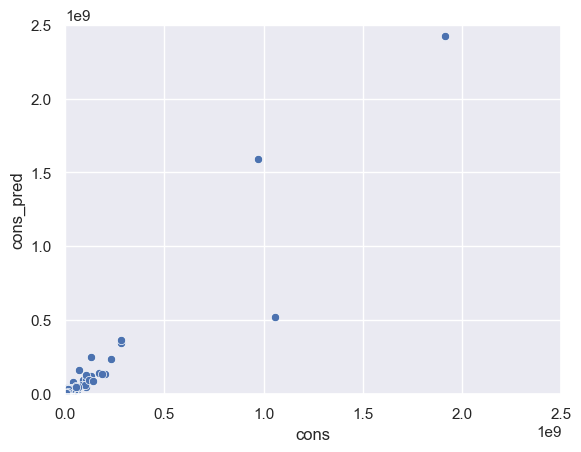

In [765]:
cons['cons_pred'] = res.predict(cons[[
    'from_buffaloes_log', 
    'from_cattle_log', 
    'from_chickens_log', 
    'from_ducks_log',
    'from_goats_log', 
    'from_horses_log', 
    'from_pigs_log', 
    'from_sheep_log', 
    'from_pop_log']])
print(r2_score(cons['cons'], cons['cons_pred']))
sns.scatterplot(x=cons['cons'], y=cons['cons_pred'])
plt.xlim(0,2.5e9)
plt.ylim(0,2.5e9)

0.7702495907427314


(0.0, 25.0)

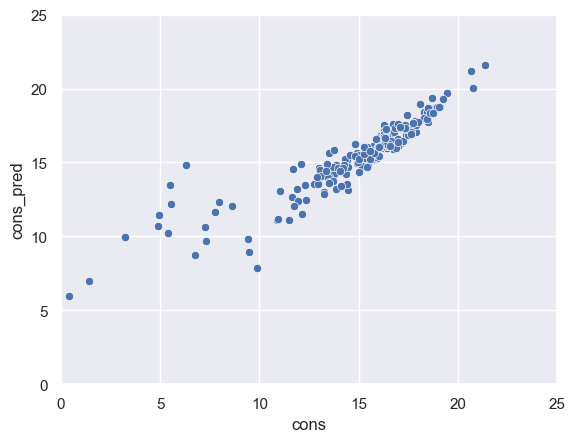

In [766]:
print(r2_score(np.log(cons['cons']+1), np.log(cons['cons_pred']+1)))
sns.scatterplot(x=np.log(cons['cons']+1), y=np.log(cons['cons_pred']+1))
plt.xlim(0,25)
plt.ylim(0,25)

In [233]:
df_admin['from_id'].nunique()

3520

In [234]:
# production
def _clean_cols(filepath):
    df_admin = pd.read_csv(filepath).drop(['system:index', '.geo', 'admin', 'admin_name', 'country', 'latitude', 'longitude'], axis=1)
    col = [c for c in df_admin.columns.tolist() if c not in ['iso3', 'ID']][0]
    # agg at country level 
    df_country = df_admin[['iso3', col]].groupby('iso3').sum().reset_index()
    df_admin = df_admin.merge(df_country.rename(columns={col: col+'_total'}))
    return df_admin

barley_p_admin = _clean_cols('../../data/admin_reductions/barley_production.csv')
maize_p_admin = _clean_cols('../../data/admin_reductions/maize_production.csv')
millet_p_admin = _clean_cols('../../data/admin_reductions/millet_production.csv')
rice_p_admin = _clean_cols('../../data/admin_reductions/rice_production.csv')
sorghum_p_admin = _clean_cols('../../data/admin_reductions/sorghum_production.csv')
wheat_p_admin = _clean_cols('../../data/admin_reductions/wheat_production.csv')
other_p_admin = _clean_cols('../../data/admin_reductions/other_cereals_production.csv')

In [235]:
productions_admin = barley_p_admin.merge(maize_p_admin, how='left').merge(millet_p_admin, how='left').merge(rice_p_admin, how='left').merge(
    sorghum_p_admin, how='left').merge(wheat_p_admin, how='left').merge(other_p_admin, how='left')

In [236]:
productions_admin['production_admin'] = productions_admin['barley_production'] + productions_admin['maize_production'] \
+ productions_admin['millet_production'] + productions_admin['rice_production'] + productions_admin['sorghum_production'] \
+ productions_admin['wheat_production'] + productions_admin['other_cereals_production']
productions_admin['production_total'] = productions_admin['barley_production_total'] + productions_admin['maize_production_total'] \
+ productions_admin['millet_production_total'] + productions_admin['rice_production_total'] + productions_admin['sorghum_production_total'] \
+ productions_admin['wheat_production_total'] + productions_admin['other_cereals_production_total']

In [237]:
productions_admin = productions_admin[['ID', 'iso3', 'production_admin', 'production_total']]

In [238]:
productions_admin.shape

(3787, 4)

In [239]:
productions_admin['iso3'].nunique()

240

In [240]:
fao_prod_2017 = pd.read_csv("../../data/FAO_prod_mat/prod_matrix_cereals_all_2017.csv").rename(columns={'prod': 'prod_2017'})
fao_prod_2018 = pd.read_csv("../../data/FAO_prod_mat/prod_matrix_cereals_all_2018.csv").rename(columns={'prod': 'prod_2018'})
fao_prod_2019 = pd.read_csv("../../data/FAO_prod_mat/prod_matrix_cereals_all_2019.csv").rename(columns={'prod': 'prod_2019'})
fao_prod_2020 = pd.read_csv("../../data/FAO_prod_mat/prod_matrix_cereals_all_2020.csv").rename(columns={'prod': 'prod_2020'})
fao_prod_2021 = pd.read_csv("../../data/FAO_prod_mat/prod_matrix_cereals_all_2021.csv").rename(columns={'prod': 'prod_2021'})

In [241]:
fao_prod = fao_prod_2017.merge(fao_prod_2018, on='iso3').merge(fao_prod_2019, on='iso3').merge(
    fao_prod_2020, on='iso3').merge(fao_prod_2021, on='iso3')
fao_prod['fao_prod'] = (fao_prod['prod_2017'] + fao_prod['prod_2018'] + fao_prod['prod_2019'] \
+ fao_prod['prod_2020'] + fao_prod['prod_2021']) / 5

In [242]:
fao_prod.shape

(203, 7)

In [243]:
productions_admin = productions_admin.merge(fao_prod[['iso3', 'fao_prod']])

In [244]:
productions_admin['production_admin_est'] = productions_admin['production_admin'] / productions_admin['production_total'] \
* productions_admin['fao_prod']

In [245]:
productions_admin = productions_admin.fillna(0)

In [246]:
cons_admin = productions_admin.merge(df_admin[['from_iso3', 'from_id', 'from_buffaloes_log', 'from_cattle_log', 'from_chickens_log', 
                                               'from_ducks_log', 'from_goats_log', 'from_horses_log', 'from_pigs_log', 
                                               'from_sheep_log', 'from_pop_log']].drop_duplicates(), 
                  left_on=['ID', 'iso3'], right_on=['from_id', 'from_iso3']).drop(['from_id', 'from_iso3'], axis=1)

In [247]:
cons_admin.shape

(3520, 15)

In [248]:
cons_admin['cons'] = res.predict(cons_admin[[
                                             'from_buffaloes_log', 'from_cattle_log', 'from_chickens_log', 'from_ducks_log', 
                                             'from_goats_log', 'from_horses_log',  # dropped from regression model
                                             'from_pigs_log', 'from_sheep_log', 
                                             'from_pop_log']])

In [249]:
cons_admin['exp_max'] = cons_admin['production_admin_est'] - cons_admin['cons']

In [250]:
cons_admin[cons_admin['exp_max']>0].sort_values(by=['exp_max']).tail()

,ID,iso3,production_admin,production_total,fao_prod,production_admin_est,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,cons,exp_max
233,CHN.1_1,CHN,4.198584e+07,5.880600e+08,1.842042e+09,1.315166e+08,13.898751,15.389824,18.884032,16.439081,16.052855,7.628266,16.751418,11.856545,17.907354,5.139415e+07,8.012246e+07
1356,USA.16_1,USA,3.192292e+07,4.596170e+08,1.308388e+09,9.087476e+07,10.034891,15.210956,17.335507,10.023489,11.039360,11.926678,16.929626,11.890987,14.978817,5.039505e+06,8.583525e+07
1354,USA.14_1,USA,3.626226e+07,4.596170e+08,1.308388e+09,1.032275e+08,9.654158,13.975424,13.202773,9.747946,10.467617,11.968428,15.408939,10.796189,16.415503,8.854716e+06,9.437280e+07
1374,USA.44_1,USA,4.792558e+07,4.596170e+08,1.308388e+09,1.364294e+08,12.109384,16.261296,18.737716,11.744342,13.813139,13.942291,11.461472,13.297842,17.245235,3.065253e+07,1.057769e+08
1384,USA.28_1,USA,3.949515e+07,4.596170e+08,1.308388e+09,1.124306e+08,10.176538,15.704337,13.631953,9.542610,10.295009,11.875689,14.848400,11.187564,14.492245,2.515981e+06,1.099146e+08


In [251]:
print(cons.shape)
print(cons_admin.shape)
print(cons_admin.groupby('iso3').sum()[['cons']].reset_index().rename(columns={'cons': 'cons_admin_total'}).merge(cons[['iso3', 'cons']]).shape)

(194, 11)
(3520, 17)
(194, 3)


In [738]:
cons_comp = cons_admin.groupby('iso3').sum()[['cons']].reset_index().rename(columns={'cons': 'cons_admin_total'}).merge(cons[['iso3', 'cons']])

0.8778722001244617


(0.0, 2000000000.0)

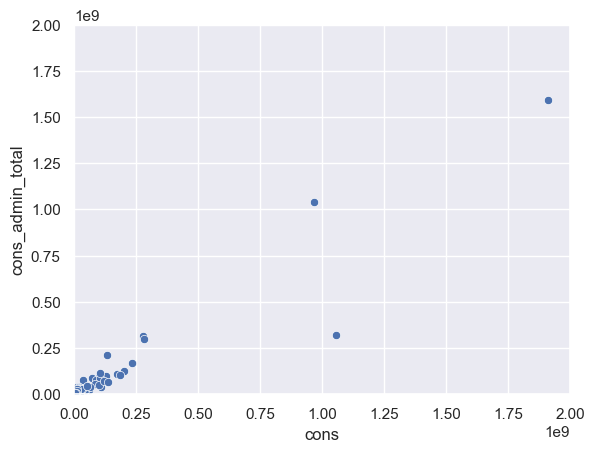

In [741]:
print(r2_score(cons_comp['cons'], cons_comp['cons_admin_total']))
sns.scatterplot(x=cons_comp['cons'], y=cons_comp['cons_admin_total'])
plt.xlim(0,2e9)
plt.ylim(0,2e9)

0.7790151477161015


(0.0, 25.0)

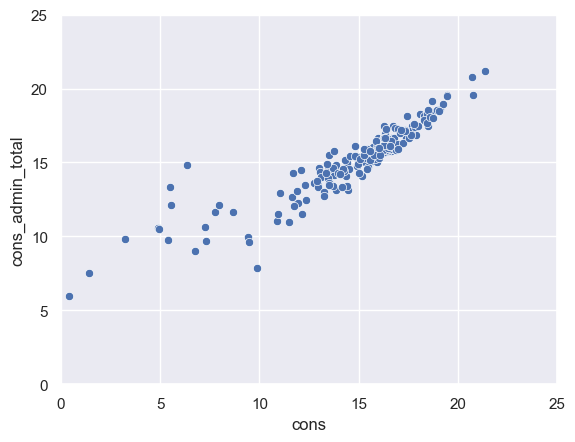

In [740]:
print(r2_score(np.log(cons_comp['cons']+1), np.log(cons_comp['cons_admin_total']+1)))
sns.scatterplot(x=np.log(cons_comp['cons']+1), y=np.log(cons_comp['cons_admin_total']+1))
plt.xlim(0,25)
plt.ylim(0,25)

In [255]:
# ignoring 4 admins as they don't have any entries in to_id in df_admin
cons_admin = cons_admin[~cons_admin['ID'].isin(['ATG.2_1', 'MUS.11_1', 'NZL.10_1', 'NZL.13_1'])]

df_ids = df_admin[['from_id', 'from_iso3']].drop_duplicates().sort_values(by='from_id')
df_ids = df_ids[~df_ids['from_id'].isin(['ATG.2_1', 'MUS.11_1', 'NZL.10_1', 'NZL.13_1'])].reset_index(drop=True)
df_ids = df_ids.rename(columns={'from_id': 'id', 'from_iso3': 'iso3'})
df_ids.shape

(3516, 2)

In [256]:
# add all admins to from and to columns
df_mat = df_admin[['from_id', 'from_iso3', 'to_id', 'to_iso3']].merge(df_ids, left_on='from_id', right_on='id', how='right')
df_mat = df_mat.drop(['from_id', 'from_iso3'], axis=1).rename(columns={'id': 'from_id', 'iso3': 'from_iso3'})
df_mat = df_mat.sort_values(by='from_id')

def _add_all_admins(m):
    m = m.merge(df_ids, left_on='to_id', right_on='id', how='right')
    m = m.drop(['to_id', 'to_iso3', 'from_id', 'from_iso3'], axis=1).rename(columns={'id': 'to_id', 'iso3': 'to_iso3'})
    m = m.sort_values(by='to_id')
    return m

df_mat = df_mat.groupby(['from_id', 'from_iso3']).apply(lambda g: _add_all_admins(g)).reset_index()

In [257]:
# merge with trade exists and trade (both domestic and international) - all possible trades, for domestic all trades, whatever the probability
df_mat = df_mat.drop('level_2', axis=1)
df_mat = df_mat.merge(pd.concat(
    [domestic[['from_id', 'to_id', 'trade_exists']], 
     trade_admin[trade_admin['from_iso3']!=trade_admin['to_iso3']].reset_index(drop=True)[['from_id', 'to_id', 'trade_exists']]]), how='left')
df_mat = df_mat.merge(trade_admin[['from_id', 'to_id', 'trade']], how='left')
df_mat = df_mat.fillna(0)
df_mat.to_csv(f'../../data/admin_predictions/df_mat_raw.csv', index=False)
df_mat['exclude'] = 0
df_mat['trade_real'] = 0

In [258]:
cons_admin = cons_admin.sort_values(by='ID').reset_index(drop=True)
prod_val = cons_admin['production_admin_est'].values
cons_val = cons_admin['cons'].values

In [259]:
# create a matrix for keeping track of admin - est prod, est cons, est trade max, current cons, current trade
admin_current_status = cons_admin[['ID', 'iso3', 'production_admin_est', 'cons', 'exp_max']]
admin_current_status['current_cons'] = admin_current_status['production_admin_est']
admin_current_status['current_exp'] = 0
admin_current_status['current_imp'] = 0

/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_7330/415400924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_cons'] = admin_current_status['production_admin_est']
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_7330/415400924.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_exp'] = 0
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_7330/415400924.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

In [260]:
exporters = df_country[['from_iso3', 'to_iso3', 'trade']].groupby('from_iso3').sum()[['trade']].sort_values(
    by='trade', ascending=False).reset_index().rename(columns={'from_iso3': 'iso3'})
exporters = exporters[exporters['trade']>0].reset_index(drop=True)
exporters = exporters.merge(cons_admin.groupby('iso3').agg({'exp_max':['sum', 'max']}).xs('exp_max', axis=1, drop_level=True).reset_index()).rename(
    columns={'sum':'exp_est_sum', 'max': 'exp_est_max'})

In [261]:
def process_mats(df_mat, prod_val, admin_current_status, df_ids, df_country):

    print(df_mat[['trade', 'trade_real']].sum())
    
    # make 3 3516*3516 mats - real trade mat that will be filled, ml pred probs, ml pred trades 
    df_mat = df_mat.sort_values(by=['from_id', 'to_id'])
    df_mat_probs = pd.pivot(df_mat, index=['from_id'], columns = 'to_id',values = 'trade_exists').reset_index().drop('from_id', axis=1).to_numpy()
    df_mat_trade = pd.pivot(df_mat, index=['from_id'], columns = 'to_id',values = 'trade').reset_index().drop('from_id', axis=1).to_numpy()
    df_mat_real = pd.pivot(df_mat, index=['from_id'], columns = 'to_id',values = 'trade_real').reset_index().drop('from_id', axis=1).to_numpy()
    
    # fill in diagonal elements (domestic supply)
    exports_pred = df_mat_real.sum(axis=1)
    imports_pred = df_mat_real.sum(axis=0)
    dom_sup_pred = prod_val - exports_pred
    np.fill_diagonal(df_mat_real, dom_sup_pred)
    
    # matrix for keeping track of admin - est prod, est cons, est trade max, current cons, current trade
    admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
    admin_current_status['current_exp'] = exports_pred
    admin_current_status['current_imp'] = imports_pred
    admin_current_status['exp_max'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp'] - admin_current_status['cons'] 
    
    df_mat_real_pd = pd.DataFrame(df_mat_real, columns = df_ids['id'].values.tolist())
    df_mat_real_pd['from_id'] = pd.Series(df_ids['id'].values.tolist(), index=df_mat_real_pd.index)
    first_column = df_mat_real_pd.pop('from_id')
    df_mat_real_pd.insert(0, 'from_id', first_column)
    df_mat_real_pd = df_mat_real_pd.melt(id_vars=['from_id'], value_vars=df_ids['id'].values.tolist()).rename(columns={'variable': 'to_id', 'value': 'trade'})
    df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='from_id', right_on='id').rename(columns={'iso3': 'from_iso3'}).drop('id', axis=1)
    df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='to_id', right_on='id').rename(columns={'iso3': 'to_iso3'}).drop('id', axis=1)
    df_mat_real_pd = df_mat_real_pd[df_mat_real_pd['from_iso3']!=df_mat_real_pd['to_iso3']]
    
    trade_bal_pred = df_mat_real_pd.groupby(['from_iso3', 'to_iso3']).sum()[['trade']].reset_index()
    trade_bal_pred = trade_bal_pred.rename(columns={'trade': 'trade_pred'}).merge(df_country[['from_iso3', 'to_iso3', 'trade']])

    print(len(trade_bal_pred[trade_bal_pred['trade_pred']>trade_bal_pred['trade']+0.1]))
    print(trade_bal_pred[trade_bal_pred['trade_pred']>trade_bal_pred['trade']+0.1]['from_iso3'].nunique())
    
    return df_mat, df_mat_probs, df_mat_trade, df_mat_real, admin_current_status, trade_bal_pred

In [262]:
def sel_trades(df, cons_admin, constrain=True, prob_thresh=0.4, exclude=True, scale=False):

    # spread out production for each admin row (decreasing order of ml preds until all allowed trade is used up)
    trade_max = cons_admin[cons_admin['ID']==df['from_id'].values[0]]['exp_max'].values[0]

    if constrain:
        if trade_max<=0:
            df['trade_real'] = 0
            return df

    if len(df[df['trade_exists']>prob_thresh])>0:
        d = df[df['trade_exists']>prob_thresh]
    else:
        # d = df[df['trade_exists']>df["trade_exists"].quantile(0.4)] # commented this out and added the next two lines to export the second set of results 
        df['trade_real'] = 0
        return df

    if exclude:
        d = d[d['exclude']==0]

    if d['trade'].sum()>trade_max:
        d['trade'] = d['trade'] * trade_max/d['trade'].sum()
    
    df = df.merge(d.rename(columns={'trade': 'trade_real'}), how='left').fillna(0)
    
    return df

In [263]:
def remove_trades(df, trade_total):

    d = df[df['trade_real']>0]
    df = df.drop('trade_real', axis=1)
    d = d.sort_values(by='trade_real', ascending=False)
    d['trade_total'] = d['trade_real'].cumsum()
    d['trade_total_copy'] = d['trade_total']
    d.loc[d['trade_total_copy']>trade_total, 'trade_total_copy'] = trade_total
    d = d.drop_duplicates(subset=['trade_total_copy'], keep='first')
    d['trade_real'] = d['trade_real'] + d['trade_total_copy'] - d['trade_total']
    d = d.drop(['trade_total', 'trade_total_copy', 'trade'], axis=1)
    df = df.merge(d[['from_id', 'to_id', 'trade_real']], how='left').fillna(0)
    df.loc[df['trade_real']==0, 'exclude'] = 1
    df.loc[(df['trade_real']!=df['trade']) & (df['exclude']==0), 'trade'] = df[(df['trade_real']!=df['trade']) & (df['exclude']==0)]['trade_real']
    return df

In [264]:
# loop = True
# i = 0

# while loop:

#     # add dropped trades to other countries
#     df_mat = df_mat.drop('trade_real', axis=1).groupby('from_id').apply(lambda g: sel_trades(g, cons_admin=admin_current_status)).reset_index(drop=True)
#     df_mat, df_mat_probs, df_mat_trade, df_mat_real, admin_current_status, trade_bal_pred = process_mats(
#         df_mat, prod_val, admin_current_status, df_ids, df_country)
                                                                                                                                              
#     np.save(f'../../data/admin_predictions/df_mat_real_{i}.npy', df_mat_real)
#     admin_current_status.to_csv(f'../../data/admin_predictions/adm_current_status_{i}.csv', index=False)
#     df_mat.to_csv(f'../../data/admin_predictions/df_mat_{i}.csv', index=False)                                                                                                  
                                                                                                                                              
#     if len(trade_bal_pred[trade_bal_pred['trade_pred']>trade_bal_pred['trade']+0.1])==0:
#         loop = False
#     else:
#         # in decreasing order of exporter prominence, transfer trade from countries receiving too much to countries receiving too little (from the same admins so that row balance isnt disturbed)
#         for exporter in exporters['iso3'].values:
#             df_exp = trade_bal_pred[trade_bal_pred['from_iso3']==exporter]
#             df_over_exp = df_exp[df_exp['trade']+0.1<df_exp['trade_pred']]
        
#             if len(df_over_exp)>0:
#                 df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']
#                 df_over_exp = df_over_exp.sort_values(by='diff')
            
#                 df_mat_extract = df_mat.merge(df_over_exp[['from_iso3', 'to_iso3']], how='right')
#                 df_mat_extract = df_mat_extract.groupby(['from_iso3','to_iso3']).apply(lambda g: remove_trades(g, 
#                                  df_over_exp[(df_over_exp['from_iso3']==g['from_iso3'].values[0]) 
#                                  & (df_over_exp['to_iso3']==g['to_iso3'].values[0])]['trade'].values[0])).reset_index(drop=True)
#                 df_mat = pd.concat([df_mat, df_mat_extract], axis=0).drop_duplicates(subset=['from_id', 'to_id'], keep=False)
#                 df_mat = pd.concat([df_mat, df_mat_extract], axis=0).sort_values(by=['from_id', 'to_id'])

#     i+=1
    
#     if i==5:
#         loop = False
#         df_mat, df_mat_probs, df_mat_trade, df_mat_real, admin_current_status, trade_bal_pred = process_mats(
#             df_mat, prod_val, admin_current_status, df_ids, df_country)
#         np.save(f'../../data/admin_predictions/df_mat_real_{i}.npy', df_mat_real)
#         admin_current_status.to_csv(f'../../data/admin_predictions/adm_current_status_{i}.csv', index=False)
#         df_mat.to_csv(f'../../data/admin_predictions/df_mat_{i}.csv', index=False)        

In [289]:
# data uptil here has been saved
df_mat_real = np.load('../../data/admin_predictions/df_mat_real_3.npy')
admin_current_status = pd.read_csv('../../data/admin_predictions/adm_current_status_3.csv')
df_mat = pd.read_csv('../../data/admin_predictions/df_mat_3.csv')

df_mat_real_pd = pd.DataFrame(df_mat_real, columns = df_ids['id'].values.tolist())
df_mat_real_pd['from_id'] = pd.Series(df_ids['id'].values.tolist(), index=df_mat_real_pd.index)
first_column = df_mat_real_pd.pop('from_id')
df_mat_real_pd.insert(0, 'from_id', first_column)
df_mat_real_pd = df_mat_real_pd.melt(id_vars=['from_id'], value_vars=df_ids['id'].values.tolist()).rename(columns={'variable': 'to_id', 'value': 'trade'})
df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='from_id', right_on='id').rename(columns={'iso3': 'from_iso3'}).drop('id', axis=1)
df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='to_id', right_on='id').rename(columns={'iso3': 'to_iso3'}).drop('id', axis=1)
df_mat_real_pd = df_mat_real_pd[df_mat_real_pd['from_iso3']!=df_mat_real_pd['to_iso3']]

trade_bal_pred = df_mat_real_pd.groupby(['from_iso3', 'to_iso3']).sum()[['trade']].reset_index()
trade_bal_pred = trade_bal_pred.rename(columns={'trade': 'trade_pred'}).merge(df_country[['from_iso3', 'to_iso3', 'trade']])

In [290]:
trade_bal_pred['diff']= trade_bal_pred['trade'] - trade_bal_pred['trade_pred']
print(len(trade_bal_pred[trade_bal_pred['diff']>=1]))
print(trade_bal_pred[trade_bal_pred['diff']>=1]['diff'].sum()) 

admin_current_status['available'] = 1
admin_current_status.loc[admin_current_status['exp_max']<1, 'available'] = 0
admin_current_status.loc[admin_current_status['exp_max'].round()<=admin_current_status['current_exp'].round(), 'available'] = 0 
admin_current_status['prod_imp'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp']
print(admin_current_status['available'].value_counts()) 

5112
418346071.1783918
available
0    1877
1    1639
Name: count, dtype: int64


In [291]:
# go in decreasing order of trade_diff
def fill_trade(df_mat, admin_current_status, from_iso3, to_iso3, diff, prob_thresh=0.4):

    def _down_scale(df, var='exp_max'):
        max_val = df[var].values[0] - df['current_exp'].values[0] + df['trade_real'].sum()
        if df['trade'].sum()>max_val:
            if max_val<0:
                df['trade'] = 0
            else:
                df['trade'] = df['trade'] * max_val/df['trade'].sum()
        return df

    d = df_mat[(df_mat['from_iso3']==from_iso3) & (df_mat['to_iso3']==to_iso3)]
    # using admin_current_status, remove all admins from exporter that have reached capacity
    d = d.merge(admin_current_status, left_on='from_id', right_on='ID', how='left').drop(['ID', 'iso3'], axis=1)
    admins_full = d[(d['available']==0)]['from_id'].unique()
    
    # if any are left
    if len(d[~d['from_id'].isin(admins_full)])>0:
        d = d[~d['from_id'].isin(admins_full)]
        # are any currently exporting? if yes, scale those up to meet the total required, take whatever possible
        if len(d[d['trade_exists']>prob_thresh])>0:
            d = d[d['trade_exists']>prob_thresh]
            if d['trade'].sum()>0:
                print('reached 1a')
                diff = diff + d['trade_real'].sum()
                d['trade'] = d['trade'] * diff/d['trade'].sum()
                d = d.groupby('from_id').apply(lambda g: _down_scale(g)).reset_index(drop=True)
            # if no trades on these links are>0, take whatever possible prioritizing trade from regions with most excess to those with most deficit
            else:
                print('reached 1b')
                d = d.merge(admin_current_status[['ID', 'exp_max']].rename(columns={
                    'ID': 'to_id', 'exp_max': 'to_exp_max'
                }), how='left')
                if len(d[d['to_exp_max']<0])>0:
                    d = d[d['to_exp_max']<0]
                    d['trade'] = d['to_exp_max'].abs() 
                else:
                    d['trade'] = (diff + d['trade_real'].sum()) / len(d)
                diff = diff + d['trade_real'].sum()
                d['trade'] = d['trade'] * diff/d['trade'].sum()
                d = d.groupby('from_id').apply(lambda g: _down_scale(g)).reset_index(drop=True)
        # if none are currently exporting, 
        else:
            #i.e. all trade probs are less than 0.4, take all trades>0, scale those to meet total required, take whatever possible
            if d['trade'].sum()>0:
                print('reached 2a')
                diff = diff + d['trade_real'].sum()
                d['trade'] = d['trade'] * diff/d['trade'].sum()
                d = d.groupby('from_id').apply(lambda g: _down_scale(g)).reset_index(drop=True)
            # if no trades on remaining links are>0, take whatever possible prioritizing trade from regions with most excess to those with most deficit
            else:
                print('reached 2b')
                d = d.merge(admin_current_status[['ID', 'exp_max']].rename(columns={
                    'ID': 'to_id', 'exp_max': 'to_exp_max'
                }), how='left')
                if len(d[d['to_exp_max']<0])>0:
                    d = d[d['to_exp_max']<0]
                    d['trade'] = d['to_exp_max'].abs() 
                else:
                    d['trade'] = (diff + d['trade_real'].sum()) / len(d)
                diff = diff + d['trade_real'].sum()
                d['trade'] = d['trade'] * diff/d['trade'].sum()
                d = d.groupby('from_id').apply(lambda g: _down_scale(g)).reset_index(drop=True) 

    # if none are left
    else:
        print('reached 3')
        # divide remainder across all admins 
        d = d.merge(admin_current_status[['ID', 'cons', 'current_cons']].rename(columns={'ID': 'from_id'}), how='left')
        d['cons_frac'] = d['current_cons'] / d['cons']
        d['trade'] = diff * d['cons_frac'] / d['cons_frac'].sum() + d['trade_real']
        d = d.groupby('from_id').apply(lambda g: _down_scale(g, var='prod_imp')).reset_index(drop=True)
    
    # update df_mat
    d = d[['from_id', 'to_id', 'trade']].rename(columns={'trade': 'trade_real_upd'})
    df_mat = df_mat.merge(d, how='left')
    df_mat.loc[df_mat['trade_real_upd'].notnull(), 'trade_real'] = df_mat[df_mat['trade_real_upd'].notnull()]['trade_real_upd']
    df_mat = df_mat.drop('trade_real_upd', axis=1)

    # update admin_current_status
    df_mat = df_mat.sort_values(by=['from_id', 'to_id'])
    df_mat_real = pd.pivot(df_mat, index=['from_id'], columns = 'to_id',values = 'trade_real').reset_index().drop('from_id', axis=1).to_numpy()
    
    # fill in diagonal elements (domestic supply)
    exports_pred = df_mat_real.sum(axis=1)
    imports_pred = df_mat_real.sum(axis=0)
    dom_sup_pred = prod_val - exports_pred
    np.fill_diagonal(df_mat_real, dom_sup_pred)
    
    # matrix for keeping track of admin - est prod, est cons, est trade max, current cons, current trade
    admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
    admin_current_status['current_exp'] = exports_pred
    admin_current_status['current_imp'] = imports_pred
    admin_current_status['exp_max'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp'] - admin_current_status['cons']
    admin_current_status['available'] = 1 
    admin_current_status.loc[admin_current_status['exp_max']<1, 'available'] = 0
    admin_current_status.loc[admin_current_status['exp_max'].round()<=admin_current_status['current_exp'].round(), 'available'] = 0
    admin_current_status['prod_imp'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp']


    if len(admin_current_status[admin_current_status['current_exp']<0])>0:
        print('error1')
    if len(df_mat[df_mat['trade_real']<0])>0:
        print('error2')
    if len(admin_current_status[admin_current_status['current_cons']<-0.9])>0:
        print('error3')
    
    return df_mat, df_mat_real, admin_current_status

In [292]:
loop = True
i = 0

while loop:
    # apply for loop on sorted trade_bal_pred and return df_mat, only when diff is positive
    for index, row in trade_bal_pred[trade_bal_pred['diff']>=1].sort_values('diff', ascending=False).reset_index(drop=True).iterrows():
        from_iso3 = row['from_iso3']
        to_iso3 = row['to_iso3']
        diff = row['diff']
        print(f"{index} {from_iso3} to {to_iso3}")
        df_mat, df_mat_real, admin_current_status = fill_trade(df_mat, admin_current_status, from_iso3, to_iso3, diff)
        print('done')

    np.save(f'../../data/admin_predictions/df_mat_real_bal_{i}.npy', df_mat_real)
    admin_current_status.to_csv(f'../../data/admin_predictions/adm_current_status_bal_{i}.csv', index=False)
    df_mat.to_csv(f'../../data/admin_predictions/df_mat_bal_{i}.csv', index=False)

    # re calculate trade_bal_pred
    df_mat_real_pd = pd.DataFrame(df_mat_real, columns = df_ids['id'].values.tolist())
    df_mat_real_pd['from_id'] = pd.Series(df_ids['id'].values.tolist(), index=df_mat_real_pd.index)
    first_column = df_mat_real_pd.pop('from_id')
    df_mat_real_pd.insert(0, 'from_id', first_column)
    df_mat_real_pd = df_mat_real_pd.melt(id_vars=['from_id'], value_vars=df_ids['id'].values.tolist()).rename(columns={'variable': 'to_id', 
                                                                                                                       'value': 'trade'})
    df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='from_id', right_on='id').rename(columns={'iso3': 'from_iso3'}).drop('id', axis=1)
    df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='to_id', right_on='id').rename(columns={'iso3': 'to_iso3'}).drop('id', axis=1)
    df_mat_real_pd = df_mat_real_pd[df_mat_real_pd['from_iso3']!=df_mat_real_pd['to_iso3']]
    
    trade_bal_pred = df_mat_real_pd.groupby(['from_iso3', 'to_iso3']).sum()[['trade']].reset_index()
    trade_bal_pred = trade_bal_pred.rename(columns={'trade': 'trade_pred'}).merge(df_country[['from_iso3', 'to_iso3', 'trade']])
    trade_bal_pred['diff']= trade_bal_pred['trade'] - trade_bal_pred['trade_pred']

    print(len(trade_bal_pred[trade_bal_pred['diff']>=1]))
    print(trade_bal_pred[trade_bal_pred['diff']>=1]['diff'].sum())
    print(admin_current_status['available'].value_counts())
    
    if len(trade_bal_pred[trade_bal_pred['diff']>=1])==0:
        loop = False
    
    i+=1
    if i==20:
        loop = False


0 USA to JPN
reached 1a
done
1 BRA to IRN
reached 1a
done
2 ARG to BRA
reached 1a
done
3 ARG to VNM
reached 1a
done
4 USA to KOR
reached 1a
done
5 BRA to EGY
reached 1a
done
6 USA to MEX
reached 1a
done
7 USA to PER
reached 1a
done
8 BRA to ESP
reached 1a
done
9 KAZ to UZB
reached 1a
done
10 USA to PHL
reached 1a
done
11 ARG to EGY
reached 1a
done
12 UKR to ESP
reached 1a
done
13 USA to COL
reached 1a
done
14 ARG to DZA
reached 1a
done
15 UKR to NLD
reached 1a
done
16 BRA to VNM
reached 1a
done
17 ARG to CHL
reached 1a
done
18 ARG to PER
reached 1a
done
19 UKR to BGD
reached 1a
done
20 CAN to PER
reached 1a
done
21 UKR to EGY
reached 1a
done
22 BGR to ESP
reached 1a
done
23 CAN to JPN
reached 1a
done
24 RUS to BGD
reached 1a
done
25 UKR to CHN
reached 1a
done
26 BRA to TWN
reached 1a
done
27 ARG to SAU
reached 1a
done
28 CAN to COL
reached 1a
done
29 CAN to IDN
reached 1a
done
30 KAZ to TJK
reached 1a
done
31 BRA to MYS
reached 1a
done
32 USA to TWN
reached 1a
done
33 ARG to MAR
reache

In [964]:
# data uptil here has been saved
df_mat_real = np.load('../../data/admin_predictions/df_mat_real_bal_6.npy')
admin_current_status = pd.read_csv('../../data/admin_predictions/adm_current_status_bal_6.csv')
df_mat = pd.read_csv('../../data/admin_predictions/df_mat_bal_6.csv')

df_mat_real_pd = pd.DataFrame(df_mat_real, columns = df_ids['id'].values.tolist())
df_mat_real_pd['from_id'] = pd.Series(df_ids['id'].values.tolist(), index=df_mat_real_pd.index)
first_column = df_mat_real_pd.pop('from_id')
df_mat_real_pd.insert(0, 'from_id', first_column)
df_mat_real_pd = df_mat_real_pd.melt(id_vars=['from_id'], value_vars=df_ids['id'].values.tolist()).rename(columns={'variable': 'to_id', 'value': 'trade'})
df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='from_id', right_on='id').rename(columns={'iso3': 'from_iso3'}).drop('id', axis=1)
df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='to_id', right_on='id').rename(columns={'iso3': 'to_iso3'}).drop('id', axis=1)
df_mat_real_pd = df_mat_real_pd[df_mat_real_pd['from_iso3']!=df_mat_real_pd['to_iso3']]

trade_bal_pred = df_mat_real_pd.groupby(['from_iso3', 'to_iso3']).sum()[['trade']].reset_index()
trade_bal_pred = trade_bal_pred.rename(columns={'trade': 'trade_pred'}).merge(df_country[['from_iso3', 'to_iso3', 'trade']])
trade_bal_pred['diff']= trade_bal_pred['trade'] - trade_bal_pred['trade_pred']
print(len(trade_bal_pred[trade_bal_pred['diff']>=1]))
print(trade_bal_pred[trade_bal_pred['diff']>=1]['diff'].sum())  
print(admin_current_status['available'].value_counts()) 

0
0.0
available
0    1799
1    1717
Name: count, dtype: int64


In [965]:
cons_comp['perc_cons'] = cons_comp['cons'] / cons_comp['cons_admin_total']
admin_current_status = admin_current_status.merge(cons_comp[['iso3', 'perc_cons']])
admin_current_status.loc[admin_current_status['perc_cons']<1, 'cons'] = admin_current_status[admin_current_status['perc_cons']<1]['perc_cons'] * admin_current_status[admin_current_status['perc_cons']<1]['cons']
admin_current_status['exp_max'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp'] - admin_current_status['cons']
admin_current_status['available'] = 1 
admin_current_status.loc[admin_current_status['exp_max']<1, 'available'] = 0
admin_current_status.loc[admin_current_status['exp_max'].round()<=admin_current_status['current_exp'].round(), 'available'] = 0
admin_current_status['cons_diff'] = admin_current_status['cons'] - admin_current_status['current_cons']

In [966]:
# something went wrong when creating the 'production_admin_est' column (when gaez production was always 0, or when one of the admins was removed)
# in the case of BRB, DMA, MDV, FSM, GRD, CPV, MUS, STP, TTO, ISL, BTN, PSE, COM
# fixing it here (ideally should have fixed it before matching)
admin_current_status.loc[admin_current_status['iso3']=='COM', 'production_admin_est'] = 112702.8 / len(
    admin_current_status[admin_current_status['iso3']=='COM'])
admin_current_status.loc[admin_current_status['iso3']=='ISL', 'production_admin_est'] = 19672.8	/ len(
    admin_current_status[admin_current_status['iso3']=='ISL'])
admin_current_status.loc[admin_current_status['iso3']=='TTO', 'production_admin_est'] = 16349.238 / len(
    admin_current_status[admin_current_status['iso3']=='TTO'])
admin_current_status.loc[admin_current_status['iso3']=='STP', 'production_admin_est'] = 2295.43 / len(
    admin_current_status[admin_current_status['iso3']=='STP'])
admin_current_status.loc[admin_current_status['iso3']=='MUS', 'production_admin_est'] = 1768.8 / len(
    admin_current_status[admin_current_status['iso3']=='MUS'])
admin_current_status.loc[admin_current_status['iso3']=='CPV', 'production_admin_est'] = 1226.12 / len(
    admin_current_status[admin_current_status['iso3']=='CPV'])
admin_current_status.loc[admin_current_status['iso3']=='GRD', 'production_admin_est'] = 1142.31	/ len(
    admin_current_status[admin_current_status['iso3']=='GRD'])
admin_current_status.loc[admin_current_status['iso3']=='FSM', 'production_admin_est'] = 849.696 / len(
    admin_current_status[admin_current_status['iso3']=='FSM'])
admin_current_status.loc[admin_current_status['iso3']=='MDV', 'production_admin_est'] = 599.988 / len(
    admin_current_status[admin_current_status['iso3']=='MDV'])
admin_current_status.loc[admin_current_status['iso3']=='DMA', 'production_admin_est'] = 574.398 / len(
    admin_current_status[admin_current_status['iso3']=='DMA'])
admin_current_status.loc[admin_current_status['iso3']=='BRB', 'production_admin_est'] = 230.88 / len(
    admin_current_status[admin_current_status['iso3']=='BRB'])

admin_current_status.loc[admin_current_status['iso3']=='PSE', 'cons'] = admin_current_status[admin_current_status['iso3']=='PSE']['cons']- 52594.321331
admin_current_status.loc[admin_current_status['iso3']=='BTN', 'cons'] = admin_current_status[admin_current_status['iso3']=='BTN']['cons'] \
* (admin_current_status[admin_current_status['iso3']=='BTN']['cons'].sum() - 45648.816977) \
/ admin_current_status[admin_current_status['iso3']=='BTN']['cons'].sum()

admin_current_status['current_cons'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp'] - admin_current_status['current_exp']
admin_current_status['exp_max'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp'] - admin_current_status['cons']
admin_current_status['available'] = 1 
admin_current_status.loc[admin_current_status['exp_max']<1, 'available'] = 0
admin_current_status.loc[admin_current_status['exp_max'].round()<=admin_current_status['current_exp'].round(), 'available'] = 0
admin_current_status['prod_imp'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp']

admin_current_status['cons_diff'] = admin_current_status['cons'] - admin_current_status['current_cons']

prod_val = admin_current_status['production_admin_est'].values

In [979]:
def fill_dom_trade(df_mat, admin_current_status, iso3):

    def _up_scale(df):
        to_id = df['to_id'].values[0]
        diff = admin_current_status[admin_current_status['ID']==to_id]['cons_diff'].values[0]*0.95
        if df['trade'].sum()>0:
            print('reached 1')
            diff = diff + df['trade_real'].sum()
            df['trade'] = df['trade'] * diff/df['trade'].sum()
        else:
            print('reached 2')
            df = df[df['cons_diff']<0]
            df['trade'] = df['cons_diff'].abs() 
            diff = diff + df['trade_real'].sum()
            df['trade'] = df['trade'] * diff/df['trade'].sum()
        return df

    def _down_scale(df):
        max_val = df['exp_max'].values[0] - df['current_exp'].values[0] + df['trade_real'].sum()
        if df['trade'].sum()>max_val:
            df['trade'] = df['trade'] * max_val/df['trade'].sum()
        return df
    
    d = df_mat[(df_mat['from_iso3']==iso3) & (df_mat['from_iso3']==df_mat['to_iso3']) & (df_mat['from_id']!=df_mat['to_id'])]
    to_ids = admin_current_status[(admin_current_status['iso3']==iso3) & (admin_current_status['cons_diff']>1) 
                                  & (admin_current_status['cons_diff']>0.05*admin_current_status['cons'])]['ID'].unique()
    d = d[d['to_id'].isin(to_ids)]
    d = d.merge(admin_current_status, left_on='from_id', right_on='ID', how='left').drop(['ID', 'iso3'], axis=1)
    d = d[(d['available']==1)]
        
    d = d.groupby('to_id').apply(lambda g: _up_scale(g)).reset_index(drop=True)
    d = d.groupby('from_id').apply(lambda g: _down_scale(g)).reset_index(drop=True)
    
    # update df_mat
    d = d[['from_id', 'to_id', 'trade']].rename(columns={'trade': 'trade_real_upd'})
    df_mat = df_mat.merge(d, how='left')
    df_mat.loc[df_mat['trade_real_upd'].notnull(), 'trade_real'] = df_mat[df_mat['trade_real_upd'].notnull()]['trade_real_upd']
    df_mat = df_mat.drop('trade_real_upd', axis=1)

    # update admin_current_status
    df_mat = df_mat.sort_values(by=['from_id', 'to_id'])
    df_mat_real = pd.pivot(df_mat, index=['from_id'], columns = 'to_id',values = 'trade_real').reset_index().drop('from_id', axis=1).to_numpy()
    
    # fill in diagonal elements (domestic supply)
    exports_pred = df_mat_real.sum(axis=1)
    imports_pred = df_mat_real.sum(axis=0)
    dom_sup_pred = prod_val - exports_pred
    np.fill_diagonal(df_mat_real, dom_sup_pred)
    
    # matrix for keeping track of admin - est prod, est cons, est trade max, current cons, current trade
    admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
    admin_current_status['current_exp'] = exports_pred
    admin_current_status['current_imp'] = imports_pred
    admin_current_status['exp_max'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp'] - admin_current_status['cons']
    admin_current_status['available'] = 1 
    admin_current_status.loc[admin_current_status['exp_max']<1, 'available'] = 0
    admin_current_status.loc[admin_current_status['exp_max'].round()<=admin_current_status['current_exp'].round(), 'available'] = 0
    admin_current_status['prod_imp'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp']
    admin_current_status['cons_diff'] = admin_current_status['cons'] - admin_current_status['current_cons']

    if len(admin_current_status[admin_current_status['current_exp']<0])>0:
        print('error1')
    if len(df_mat[df_mat['trade_real']<0])>0:
        print('error2')
    if len(admin_current_status[admin_current_status['current_cons']<-0.9])>0:
        print('error3')
    
    return df_mat, df_mat_real, admin_current_status

In [980]:
for iso3 in admin_current_status[(admin_current_status['cons_diff']>1) 
                                & (admin_current_status['cons_diff']>admin_current_status['cons']*0.05)]['iso3'].unique():
    print(iso3)
    diff = admin_current_status[(admin_current_status['iso3']==iso3)  & (admin_current_status['cons_diff']>1) 
                               & (admin_current_status['cons_diff']>admin_current_status['cons']*0.05)]['cons_diff'].sum()
    while diff>0:
        print(diff)
        df_mat, df_mat_real, admin_current_status = fill_dom_trade(df_mat, admin_current_status, iso3)
        diff_new = admin_current_status[(admin_current_status['iso3']==iso3)  & (admin_current_status['cons_diff']>1) 
                                   & (admin_current_status['cons_diff']>admin_current_status['cons']*0.05)]['cons_diff'].sum()
        if diff_new==diff:
            print('nothing available')
            diff = 0
        else:
            diff = diff_new

GNQ
4.13696706448318
nothing available
GRC
702053.7194151417
reached 1
GRD
16050.619605541946
reached 2
reached 2
reached 2
reached 2
reached 2
GTM
3068739.500542521
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
1907880.4544387637
reached 1
reached 2
reached 1
reached 2
reached 1
reached 2
reached 1
reached 2
886312.9047760624
reached 2
reached 2
reached 2
reached 2
HKG
40288.786873292884
reached 2
reached 2
reached 2
reached 2
reached 2
reached 2
reached 2
reached 2
reached 2
HND
1364454.9984865575
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
638201.136499902
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
534173.0994892272
reached 2
reached 2
reached 2
reached 2
reached 2
reached 2
reached 2
reached 2
HRV
446596.2394545911
reached 2
reached 1
reached 1
176945.0361154148
reached 2
reached 1
HTI
275983.1404207813
reached 1
reached 1
reached 1
reached 1
11706.94684158

In [981]:
np.save(f'../../data/admin_predictions/df_mat_real_dom_bal.npy', df_mat_real)
admin_current_status.to_csv(f'../../data/admin_predictions/adm_current_status_dom_bal.csv', index=False)
df_mat.to_csv(f'../../data/admin_predictions/df_mat_dom_bal.csv', index=False)

In [988]:
df_mat[(df_mat['from_iso3']==df_mat['to_iso3']) & (df_mat['from_id']!=df_mat['to_id'])][['trade', 'trade_real']].sum()

trade         1.291998e+08
trade_real    1.057336e+09
dtype: float64

In [989]:
df_mat[(df_mat['from_iso3']!=df_mat['to_iso3'])][['trade', 'trade_real']].sum()

trade         7.040765e+09
trade_real    1.212773e+09
dtype: float64

In [990]:
df_country['trade'].sum()

1212773092.2699156

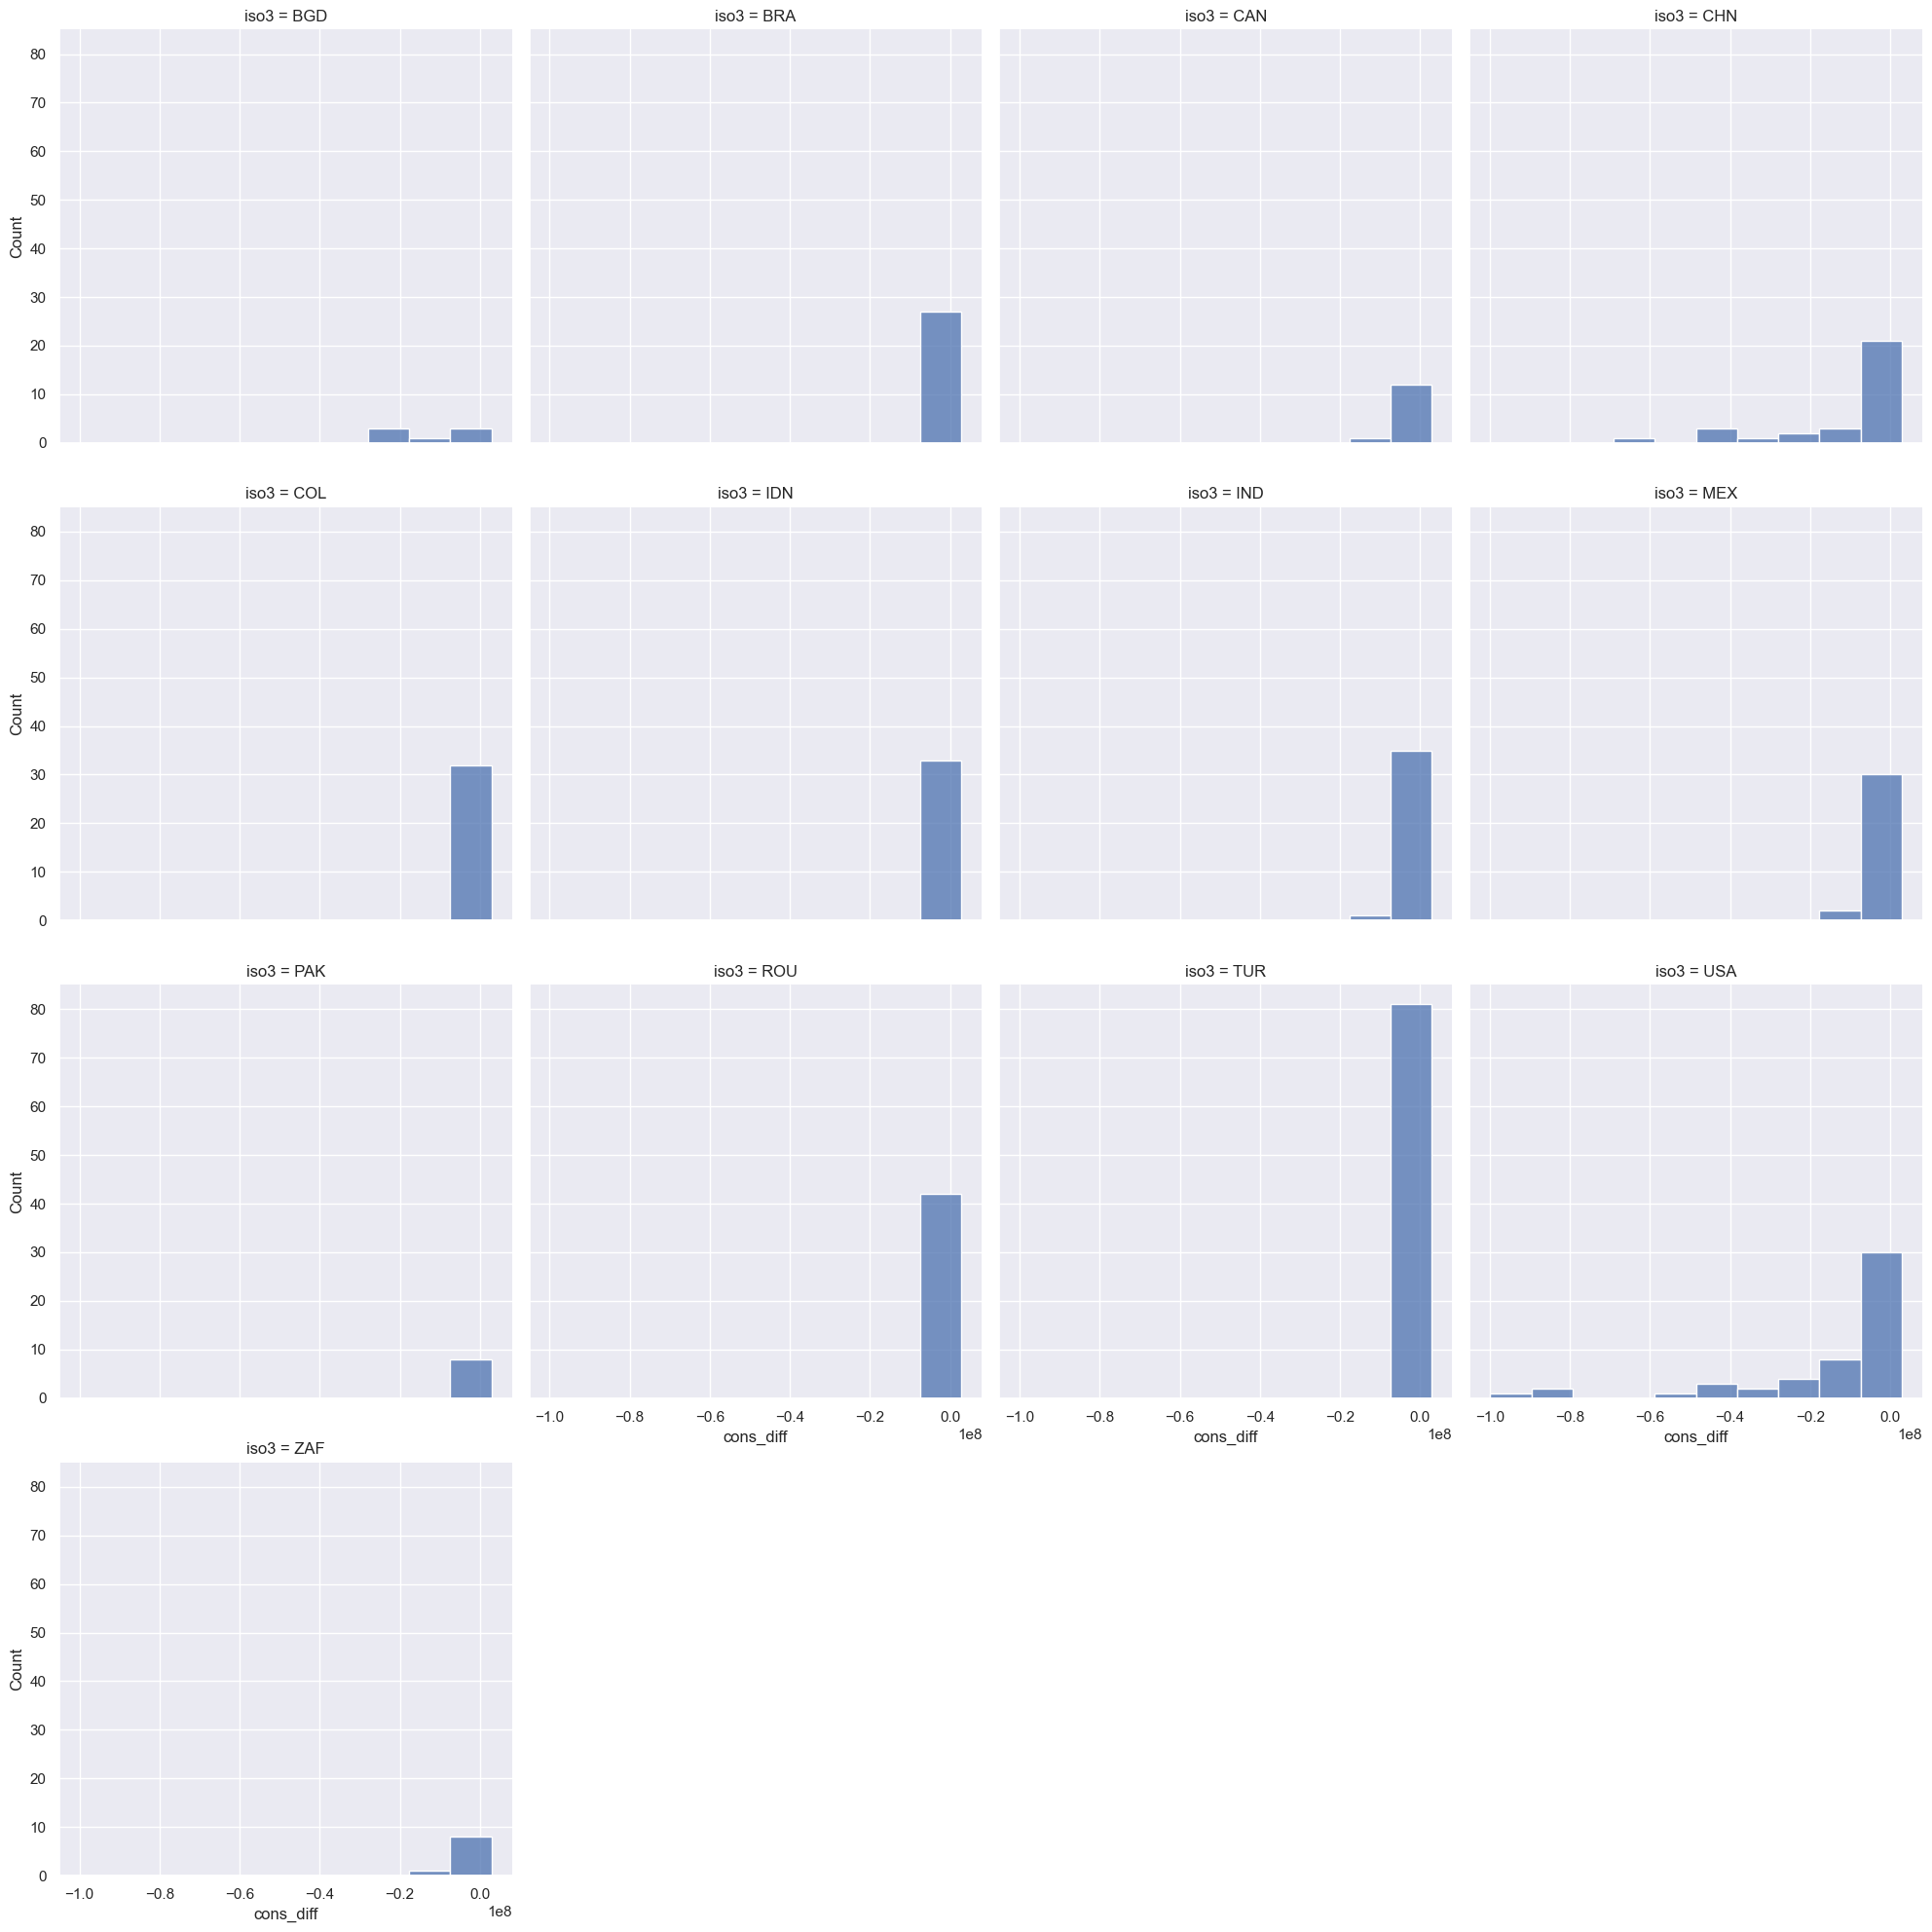

In [991]:
df = admin_current_status[admin_current_status['iso3'].isin(['USA', 'CHN', 'IND', 'CAN', 'BGD', 'BRA',
                                                             'ROU', 'ZAF', 'MEX', 'IND', 'COL', 
                                                             'TUR', 'IDN', 'PAK'])]

sns.displot(
    df, x="cons_diff", col="iso3", col_wrap=4, bins=10
)

In [992]:
# assessment

0.7377484049687882


<Axes: >

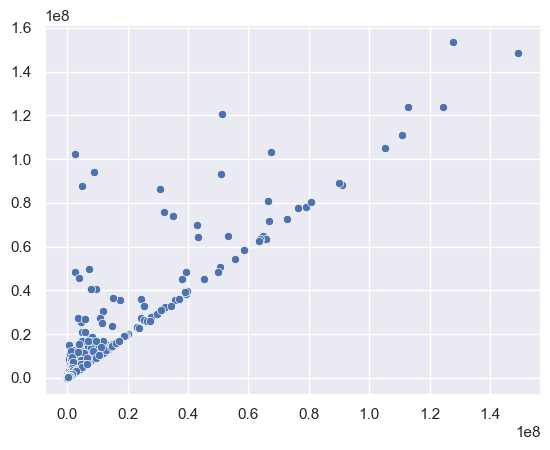

In [993]:
# consumption # this doesn't have to match perfectly. cons_val are estimates themselves, which on aggregation don't match perfectly with country level consumption estimates too well
cons_pred = df_mat_real.sum(axis=0)

print(r2_score(admin_current_status['cons'].values, #cons_val, 
               cons_pred))
sns.scatterplot(y=cons_pred, 
                x=admin_current_status['cons'].values#cons_val
               )

0.9584270524529572


<Axes: >

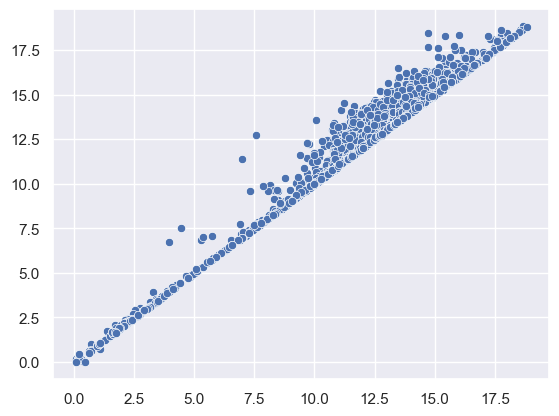

In [994]:
print(r2_score(np.log(admin_current_status['cons'].values+1), np.log(cons_pred+1)))
sns.scatterplot(y= np.log(cons_pred+1), x=np.log(admin_current_status['cons'].values+1))

0.9999999999999982


<Axes: xlabel='trade', ylabel='trade_pred'>

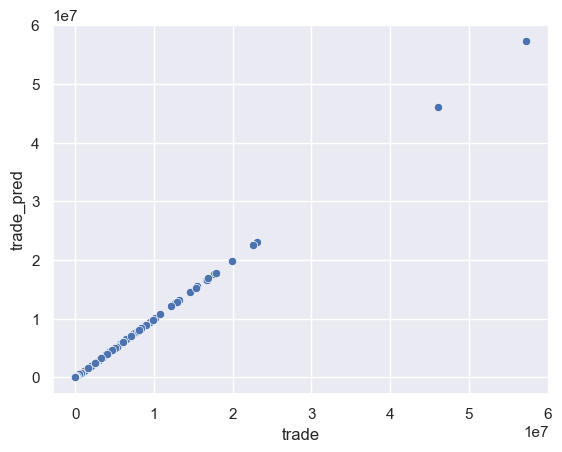

In [995]:
# trade # this should match very well, as this is observed data (kind off)
print(r2_score(trade_bal_pred[trade_bal_pred['trade']>0]['trade'], trade_bal_pred[trade_bal_pred['trade']>0]['trade_pred']))
sns.scatterplot(x=trade_bal_pred[trade_bal_pred['trade']>0]['trade'], y=trade_bal_pred[trade_bal_pred['trade']>0]['trade_pred'])

0.9999932186933023


<Axes: xlabel='trade', ylabel='trade_pred'>

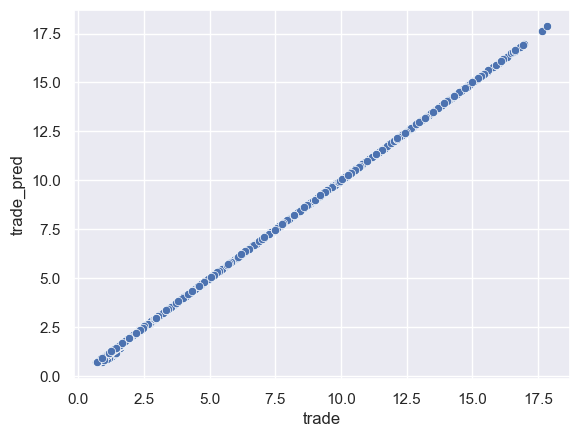

In [996]:
print(r2_score(np.log(trade_bal_pred[trade_bal_pred['trade']>0]['trade']+1), np.log(trade_bal_pred[trade_bal_pred['trade']>0]['trade_pred']+1)))
sns.scatterplot(x=np.log(trade_bal_pred[trade_bal_pred['trade']>0]['trade']+1), y=np.log(trade_bal_pred[trade_bal_pred['trade']>0]['trade_pred']+1))

In [772]:
df_mat_raw = pd.read_csv(f'../../data/admin_predictions/df_mat_raw.csv')

In [773]:
df_mat.head()

,from_id,from_iso3,to_id,to_iso3,trade_exists,trade,fixed,exclude,trade_real
0,AFG.10_1,AFG,AFG.10_1,AFG,0.000000,0.000000,0,0,0.0
1,AFG.10_1,AFG,AFG.11_1,AFG,0.196436,0.000000,0,0,0.0
2,AFG.10_1,AFG,AFG.12_1,AFG,0.298198,0.000000,0,0,0.0
3,AFG.10_1,AFG,AFG.13_1,AFG,0.209683,0.000000,0,0,0.0
4,AFG.10_1,AFG,AFG.14_1,AFG,0.505301,9.529335,0,0,0.0


In [774]:
df_mat_raw.head()

,from_id,from_iso3,to_id,to_iso3,trade_exists,trade
0,AFG.10_1,AFG,AFG.10_1,AFG,0.000000,0.000000
1,AFG.10_1,AFG,AFG.11_1,AFG,0.196436,0.000000
2,AFG.10_1,AFG,AFG.12_1,AFG,0.298198,0.000000
3,AFG.10_1,AFG,AFG.13_1,AFG,0.209683,0.000000
4,AFG.10_1,AFG,AFG.14_1,AFG,0.505301,9.529335


In [997]:
df_mat[df_mat['trade_real']>1].shape

(417505, 9)

In [998]:
df_mat_raw[df_mat_raw['trade']>1].shape

(4335065, 6)

0.26804821443523086


<Axes: xlabel='trade', ylabel='trade_real'>

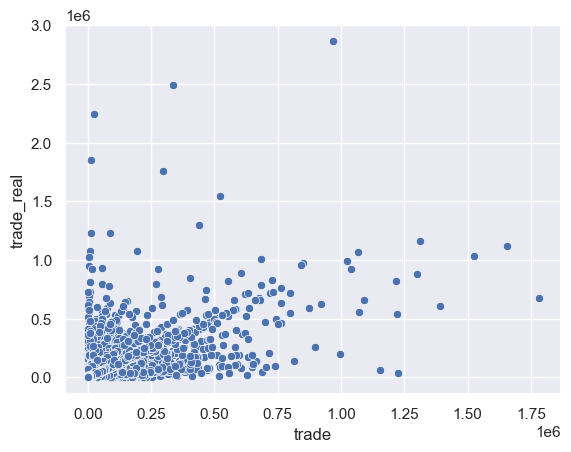

In [1010]:
mat = df_mat[['from_iso3', 'to_iso3', 'from_id', 'to_id', 'trade_real', 'trade_exists']].merge(df_mat_raw[['from_id', 'to_id', 'trade']])
row_cond = (mat['trade_real']>1) & (mat['from_iso3']!=mat['to_iso3'])
print(r2_score(mat[row_cond]['trade'], mat[row_cond]['trade_real']))
sns.scatterplot(x=mat[row_cond]['trade'], y=mat[row_cond]['trade_real'])

-1.0337155952707238


<Axes: xlabel='trade', ylabel='trade_real'>

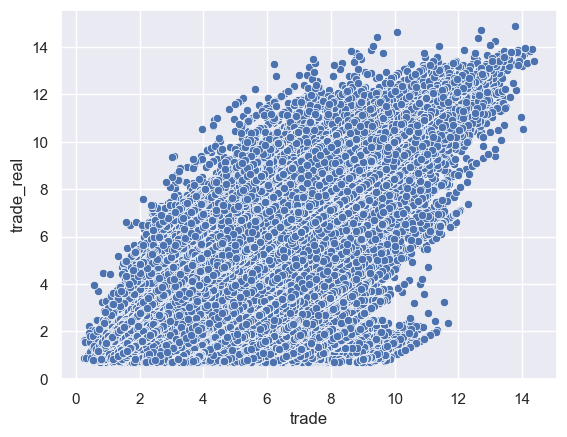

In [1011]:
print(r2_score(np.log(mat[row_cond]['trade']+1), np.log(mat[row_cond]['trade_real']+1)))
sns.scatterplot(x=np.log(mat[row_cond]['trade']+1), y=np.log(mat[row_cond]['trade_real']+1))

-2794.421497455415


<Axes: xlabel='trade', ylabel='trade_real'>

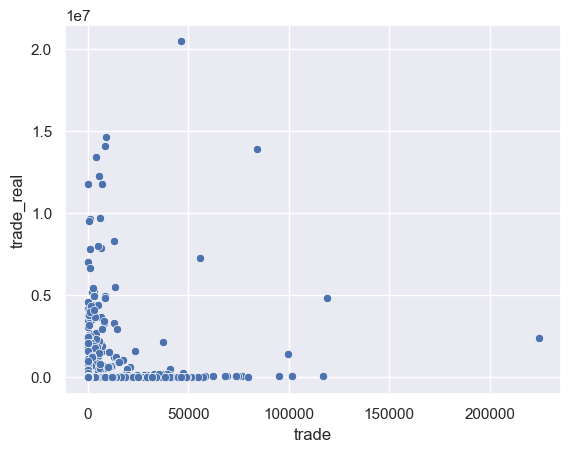

In [1012]:
row_cond = (mat['trade_real']>1) & (mat['from_iso3']==mat['to_iso3'])
print(r2_score(mat[row_cond]['trade'], mat[row_cond]['trade_real']))
sns.scatterplot(x=mat[row_cond]['trade'], y=mat[row_cond]['trade_real'])

-0.5051288164655219


<Axes: xlabel='trade', ylabel='trade_real'>

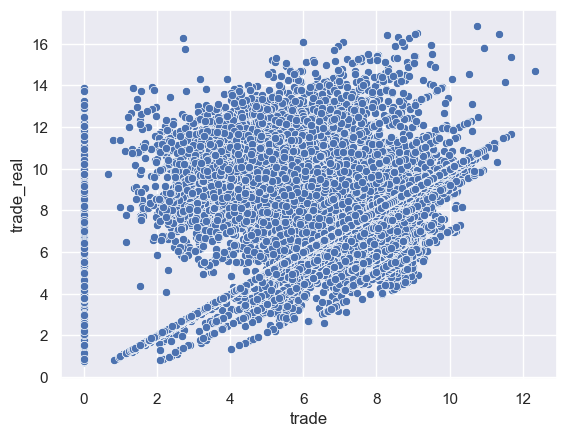

In [1013]:
print(r2_score(np.log(mat[row_cond]['trade']+1), np.log(mat[row_cond]['trade_real']+1)))
sns.scatterplot(x=np.log(mat[row_cond]['trade']+1), y=np.log(mat[row_cond]['trade_real']+1))

In [1025]:
trade_admin[(trade_admin['from_iso3']==trade_admin['to_iso3']) & (trade_admin['from_id']!=trade_admin['to_id'])
            & (trade_admin['from_iso3']=='IND')][[
    'from_id', 'to_id', 'trade_exists', 'trade'
]].sort_values('trade').tail()

,from_id,to_id,trade_exists,trade
37919,IND.34_1,IND.29_1,0.974325,101530.446483
37651,IND.5_1,IND.36_1,0.936836,111492.624711
37972,IND.34_1,IND.19_1,0.972192,117264.989628
37771,IND.34_1,IND.15_1,0.967193,118916.784947
37743,IND.34_1,IND.5_1,0.968682,224388.198798
